<a href="https://colab.research.google.com/github/OFazlyeva/yandex_practicum_projects/blob/main/Chicago_taxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Аналитика трафика такси


---



---



**Цель исследования:**

На основе данных поездок на такси в одном городе предстоит решить реальную проблему: определить периоды времени, когда возможно недостаточно водителей для удовлетворения спроса на поездки. Основная цель задания — рассчитать количество необходимых часов работы водителей и такой гарантированный доход, чтобы, с одной стороны, привлечь больше водителей во время пикового спроса, а с другой стороны, не потратить больше средств на стимулирование предложения, чем будет получено от дополнительных поездок.


---



---



**Этапы проекта:**

1. Подготовим данные для анализа
  * Найти аномалии в данных, принять решение о их сохранении или отбрасывании
2. Рассчитаем для каждого часа:
  * Количество машин на линии (только по данным начала поездок)
  * Количество поездок
  * Среднюю длительность поездки
  * Среднюю длину поездки
  * Среднюю тарифную стоимость поездки
  * Иные показатели, включая показатели из расчёта на одного водителя, включая общую выручку и выручку водителя (исходя из того, что водитель получает 60% тарифа за поездку и все чаевые)
3. Определим периоды когда водители получают
  * выручку исходя из тарифа ниже среднего
  * меньше чаевых
4. Определим критические периоды дефицита предложения
  * рассчитаем оптимальное число машин на линии для обеспечения нормального показателя покрытия
5. Визуализируем найденные в п.4 и важные рассчитанные ранее показатели с учётом недельных и суточных циклов

6. Определим периоды, в которые меры стимулирования предложения услуг такси нужны и будут наиболее эффективны

7. В рамках определённых в п.6 периодов оценим:
  * объём недополученной общей выручки из-за низкого предложения
  * дефицит количества машин на линии (сколько нужно вывести машин дополнительно, чтобы достичь нормального покрытия)
8. (опционально) Предложим меры стимулирования предложения и оцените их эффективность

9. Подготовим презентацию на 7-10 слайдов с основными результатами проекта.

---



---




## Загрузка и предобработка данных
<a id="start"></a>

In [ ]:
import pandas as pd
from pandas import Series
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from plotly import graph_objects as go


pd.set_option('display.float_format', '{:.2f}'.format)

In [ ]:
pd.options.display.float_format = '{:20,.2f}'.format

In [ ]:
! gdown 1RG36xXgLg7cj74g7mB7mF5DMs1daWl-2

Downloading...
From: https://drive.google.com/uc?id=1RG36xXgLg7cj74g7mB7mF5DMs1daWl-2
To: /content/Taxi_data.ftr
100% 79.9M/79.9M [00:00<00:00, 86.0MB/s]


In [ ]:
! gdown 19F-ewYuDVZ7R7PdcEmgGCzpXZeD0aLtX

Downloading...
From: https://drive.google.com/uc?id=19F-ewYuDVZ7R7PdcEmgGCzpXZeD0aLtX
To: /content/Estimated_coverage.ftr
100% 16.3k/16.3k [00:00<00:00, 31.3MB/s]


In [ ]:
df = pd.read_feather('/content/Taxi_data.ftr')

In [ ]:
df_cover = pd.read_feather('/content/Estimated_coverage.ftr')

In [ ]:

df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826887 entries, 0 to 1826886
Data columns (total 18 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   Trip Start Timestamp        1826887 non-null  datetime64[ns]
 1   Trip End Timestamp          1826887 non-null  datetime64[ns]
 2   Trip Seconds                1826871 non-null  float64       
 3   Trip Miles                  1826883 non-null  float64       
 4   Pickup Community Area       1602394 non-null  float64       
 5   Dropoff Community Area      1568478 non-null  float64       
 6   Fare                        1826885 non-null  float64       
 7   Tips                        1826885 non-null  float64       
 8   Tolls                       1826885 non-null  float64       
 9   Extras                      1826885 non-null  float64       
 10  Trip Total                  1826885 non-null  float64       
 11  Payment Type            

Столбцы:

* Trip Start Timestamp: дата и время начала поездки
* Trip End Timestamp: дата и время окончания поездки
* Trip Seconds: продолжительность поездки в секундах
* Trip Miles: расстояние, пройденное во время поездки в милях
* Pickup Community Area: зона, где был подобран клиент
* Dropoff Community Area: зона, где был высажен клиент
* Fare: сумма тарифа, взимаемая за поездку в долларах
* Tips: сумма чаевых за поездку
* Tolls: сумма, уплачиваемая во время поездки (за платные дороги)
* Extras: Дополнительные сборы за поездку
* Trip Total: общая сумма оплаты за поездку
* Payment Type: Тип оплаты поездки
* Company: Компания такси, связанная с поездкой
* Pickup Centroid Latitude, Pickup Centroid Longitude, Dropoff Centroid Latitude, Dropoff Centroid Longitude: координаты центров кластеров посадки/высадки
* Taxi ID: Уникальный идентификатор такси

Этот набор данных предоставляет ценную информацию для анализа поездок такси, включая продолжительность, расстояние, оплату и географические координаты мест посадки и высадки. Его можно использовать для получения информации о моделях использования такси, распределении платы за проезд, популярных местах посадки/высадки и многом другом. Источник: data.cityofchicago.org

In [ ]:
df_cover.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1413 entries, 0 to 1412
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Hour Trip Start     1413 non-null   datetime64[ns]
 1   Estimated coverage  1411 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.2 KB


Столбцы:

* Hour Trip Start: час начала поездки
* Estimated coverage: расчётная величина покрытия машинами

Рассчитанная на основании данных доля уникальных клиентов в этот час, которым был предложен вариант поездки по запросу (даже если они не воспользовались услугой).

In [ ]:
def get_info(data: pd.DataFrame):
    """функция для вывода основной информации по данным"""

    display(data.head())
    display(data.describe().T)
    print('----')
    print('Информация о пропусках и типах данных')
    print('----')
    print()
    display(data.info(show_counts=True))
    print('----')
    display(pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('rocket_r'))
    print()

In [ ]:
get_info(df)

Trip Start Timestamp  Trip End Timestamp         Trip Seconds  \
0  2015-02-06 06:45:00 2015-02-06 07:00:00               540.00   
1  2015-02-13 20:30:00 2015-02-13 20:45:00               600.00   
2  2015-03-11 23:30:00 2015-03-11 23:45:00               540.00   
3  2015-03-13 22:15:00 2015-03-13 22:15:00               360.00   
4  2015-03-13 22:15:00 2015-03-13 22:15:00                 0.00   

            Trip Miles  Pickup Community Area  Dropoff Community Area  \
0                 2.80                  21.00                   15.00   
1                 2.00                   8.00                   28.00   
2                 0.10                  28.00                    8.00   
3                 1.70                  33.00                   32.00   
4                 0.00                    NaN                     NaN   

                  Fare                 Tips                Tolls  \
0                 8.85                 0.00                 0.00   
1                 8.25                 1.00                 0.00   
2                 7.65                 0.00                 0.00   
3                 6.65                 0.00                 0.00   
4                40.85                 8.17                 0.00   

                Extras           Trip Total Payment Type  \
0                 0.00                 8.85    No Charge   
1                 0.00                 9.25  Credit Card   
2                 0.00                 7.65         Cash   
3                 1.00                 7.65  Credit Card   
4                 0.00                49.02  Credit Card   

                                    Company  Pickup Centroid Latitude  \
0                       Top Cab Affiliation                     41.94   
1                     KOAM Taxi Association                     41.89   
2                 Taxi Affiliation Services                     41.88   
3                   Choice Taxi Association                     41.85   
4  Chicago Elite Cab Corp. (Chicago Carriag                       NaN   

   Pickup Centroid Longitude  Dropoff Centroid Latitude  \
0                     -87.71                      41.95   
1                     -87.62                      41.88   
2                     -87.64                      41.89   
3                     -87.62                      41.87   
4                        NaN                        NaN   

   Dropoff Centroid Longitude  Taxi ID  
0                      -87.76      250  
1                      -87.66     1915  
2                      -87.63      110  
3                      -87.63     1802  
4                         NaN     3219

count                 mean  \
Trip Seconds                       1,826,871.00               665.94   
Trip Miles                         1,826,883.00                 2.17   
Pickup Community Area              1,602,394.00                22.43   
Dropoff Community Area             1,568,478.00                21.17   
Fare                               1,826,885.00                11.94   
Tips                               1,826,885.00                 1.36   
Tolls                              1,826,885.00                 0.00   
Extras                             1,826,885.00                 0.84   
Trip Total                         1,826,885.00                14.14   
Pickup Centroid Latitude           1,602,428.00                41.90   
Pickup Centroid Longitude          1,602,428.00               -87.66   
Dropoff Centroid Latitude          1,571,271.00                41.90   
Dropoff Centroid Longitude         1,571,271.00               -87.65   
Taxi ID                            1,826,887.00             1,202.99   

                                            std                  min  \
Trip Seconds                             679.62                 0.00   
Trip Miles                                 4.74                 0.00   
Pickup Community Area                     19.11                 1.00   
Dropoff Community Area                    17.63                 1.00   
Fare                                      15.60                 0.00   
Tips                                       2.41                 0.00   
Tolls                                      0.15                 0.00   
Extras                                    28.10                 0.00   
Trip Total                                32.85                 0.00   
Pickup Centroid Latitude                   0.04                41.66   
Pickup Centroid Longitude                  0.07               -87.91   
Dropoff Centroid Latitude                  0.04                41.66   
Dropoff Centroid Longitude                 0.06               -87.91   
Taxi ID                                  896.13                -1.00   

                                            25%                  50%  \
Trip Seconds                             240.00               480.00   
Trip Miles                                 0.00                 0.60   
Pickup Community Area                      8.00                21.00   
Dropoff Community Area                     8.00                16.00   
Fare                                       5.85                 7.85   
Tips                                       0.00                 0.00   
Tolls                                      0.00                 0.00   
Extras                                     0.00                 0.00   
Trip Total                                 6.85                 9.30   
Pickup Centroid Latitude                  41.88                41.89   
Pickup Centroid Longitude                -87.66               -87.63   
Dropoff Centroid Latitude                 41.88                41.89   
Dropoff Centroid Longitude               -87.66               -87.64   
Taxi ID                                  440.00             1,035.00   

                                            75%                  max  
Trip Seconds                             840.00            80,940.00  
Trip Miles                                 2.00               835.20  
Pickup Community Area                     32.00                77.00  
Dropoff Community Area                    32.00                77.00  
Fare                                      12.85             9,449.33  
Tips                                       2.00               396.25  
Tolls                                      0.00               100.00  
Extras                                     1.00             8,888.88  
Trip Total                                14.65             9,449.33  
Pickup Centroid Latitude                  41.91                42.02  
Pickup Centroid Lo

----
Информация о пропусках и типах данных
----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826887 entries, 0 to 1826886
Data columns (total 18 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   Trip Start Timestamp        1826887 non-null  datetime64[ns]
 1   Trip End Timestamp          1826887 non-null  datetime64[ns]
 2   Trip Seconds                1826871 non-null  float64       
 3   Trip Miles                  1826883 non-null  float64       
 4   Pickup Community Area       1602394 non-null  float64       
 5   Dropoff Community Area      1568478 non-null  float64       
 6   Fare                        1826885 non-null  float64       
 7   Tips                        1826885 non-null  float64       
 8   Tolls                       1826885 non-null  float64       
 9   Extras                      1826885 non-null  float64       
 10  Trip Total                  1826885 non-n

None

----


Наведем красоту, приведем названия столбцов к нормальному виду.

In [ ]:
df.columns = [x.lower().replace(' ', '_') for x in df.columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826887 entries, 0 to 1826886
Data columns (total 18 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   trip_start_timestamp        datetime64[ns]
 1   trip_end_timestamp          datetime64[ns]
 2   trip_seconds                float64       
 3   trip_miles                  float64       
 4   pickup_community_area       float64       
 5   dropoff_community_area      float64       
 6   fare                        float64       
 7   tips                        float64       
 8   tolls                       float64       
 9   extras                      float64       
 10  trip_total                  float64       
 11  payment_type                category      
 12  company                     category      
 13  pickup_centroid_latitude    float64       
 14  pickup_centroid_longitude   float64       
 15  dropoff_centroid_latitude   float64       
 16  dropoff_centroid_l

### Пропуски

Пойдем по порядку по необходимым нам столбцам.
В столбцах со временем начала и окончания поездки пропусков нет, посмотрим на сколько достоверные в них данные, например, время начала поездки не может быть позже времени высадки.

In [ ]:
df['time_check'] = df['trip_end_timestamp'] >= df['trip_start_timestamp']

In [ ]:
df.query('time_check == 0')

trip_start_timestamp  trip_end_timestamp  trip_seconds  \
297499   2015-02-23 15:15:00 2015-02-23 06:00:00           NaN   
392083   2015-02-24 13:00:00 2015-02-24 12:45:00           NaN   
902001   2015-03-13 15:15:00 2015-03-12 18:00:00           NaN   
998922   2015-02-18 19:45:00 2015-02-18 19:30:00           NaN   
1263976  2015-03-03 08:45:00 2015-03-03 08:30:00           NaN   
1497080  2015-03-23 07:30:00 2015-03-23 07:15:00           NaN   
1560199  2015-03-08 15:15:00 2015-03-08 05:45:00           NaN   

                  trip_miles  pickup_community_area  dropoff_community_area  \
297499                  5.50                   2.00                   11.00   
392083                  0.00                    NaN                     NaN   
902001                  4.50                   7.00                   32.00   
998922                  0.00                    NaN                     NaN   
1263976                 0.00                    NaN                     NaN   
1497080                 0.00                    NaN                     NaN   
1560199                 4.60                   6.00                   16.00   

                        fare                 tips                tolls  \
297499                 14.45                 0.00                 0.00   
392083                 19.85                 3.97                 0.00   
902001                 12.85                 0.00                 0.00   
998922                 12.05                 3.62                 0.00   
1263976                42.65                 8.53                 0.00   
1497080                35.25                 5.29                 0.00   
1560199                12.45                 0.00                 0.00   

                      extras           trip_total payment_type  \
297499                  0.00                14.45         Cash   
392083                  0.00                23.82  Credit Card   
902001                  0.00                12.85         Cash   
998922                  0.00                15.67  Credit Card   
1263976                 0.00                51.18  Credit Card   
1497080                 0.00                40.54  Credit Card   
1560199                 0.00                12.45         Cash   

                                          company  pickup_centroid_latitude  \
297499                  Taxi Affiliation Services                     42.00   
392083   Chicago Elite Cab Corp. (Chicago Carriag                       NaN   
902001                  Taxi Affiliation Services                     41.93   
998922   Chicago Elite Cab Corp. (Chicago Carriag                       NaN   
1263976  Chicago Elite Cab Corp. (Chicago Carriag                       NaN   
1497080  Chicago Elite Cab Corp. (Chicago Carriag                       NaN   
1560199                 Taxi Affiliation Services                     41.94   

         pickup_centroid_longitude  dropoff_centroid_latitude  \
297499                      -87.70                      41.98   
392083                         NaN                        NaN   
902001                      -87.65                      41.88   
998922                         NaN                        NaN   
1263976                        NaN                        NaN   
1497080                        NaN                        NaN   
1560199                     -87.66                      41.95   

         dropoff_centroid_longitude  taxi_id  time_check  
297499                       -87.77      243       False  
392083                          NaN     2417       False  
902001                       -87.62     2790       False  
998922                          NaN     3018       False  
1263976                         NaN     2681       False  
1497080                         NaN     2720       False  
1560199                      -87.72     2790       False

Пожалуй, избавимся от этих данных, так как при записи явно что-то пошло не так и время высадки раньше времени посадки, Неправильное время посадки может повлиять на результаты исследования.

In [ ]:
df = df.drop(df.query('time_check == 0').index).reset_index(drop=True)


In [ ]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826880 entries, 0 to 1826879
Data columns (total 19 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   trip_start_timestamp        1826880 non-null  datetime64[ns]
 1   trip_end_timestamp          1826880 non-null  datetime64[ns]
 2   trip_seconds                1826871 non-null  float64       
 3   trip_miles                  1826876 non-null  float64       
 4   pickup_community_area       1602391 non-null  float64       
 5   dropoff_community_area      1568475 non-null  float64       
 6   fare                        1826878 non-null  float64       
 7   tips                        1826878 non-null  float64       
 8   tolls                       1826878 non-null  float64       
 9   extras                      1826878 non-null  float64       
 10  trip_total                  1826878 non-null  float64       
 11  payment_type            

In [ ]:
df.loc[(df['trip_seconds'].isna())]

trip_start_timestamp  trip_end_timestamp  trip_seconds  \
157277   2015-02-13 10:15:00 2015-02-13 10:15:00           NaN   
252637   2015-02-13 13:00:00 2015-02-13 13:00:00           NaN   
458019   2015-02-28 10:00:00 2015-02-28 10:00:00           NaN   
595250   2015-02-27 22:45:00 2015-02-27 22:45:00           NaN   
785959   2015-02-28 02:00:00 2015-03-01 09:00:00           NaN   
1358163  2015-02-27 12:30:00 2015-02-27 12:30:00           NaN   
1467348  2015-03-20 23:15:00 2015-03-20 23:15:00           NaN   
1554932  2015-03-27 13:00:00 2015-03-27 13:00:00           NaN   
1757444  2015-02-19 19:00:00 2015-02-19 19:00:00           NaN   

                  trip_miles  pickup_community_area  dropoff_community_area  \
157277                  0.00                    NaN                     NaN   
252637                  0.00                  35.00                   35.00   
458019                  0.00                    NaN                     NaN   
595250                  0.00                    NaN                     NaN   
785959                  0.00                  43.00                   43.00   
1358163                 0.00                  21.00                   21.00   
1467348                 0.00                    NaN                     NaN   
1554932                 0.00                    NaN                     NaN   
1757444                 0.00                    NaN                     NaN   

                        fare                 tips                tolls  \
157277                 14.65                 2.93                 0.00   
252637                  3.25                 0.00                 0.00   
458019                 20.45                 4.09                 0.00   
595250                  6.65                 1.00                 0.00   
785959                  0.00                 0.00                 0.00   
1358163                 3.25                 0.00                 0.00   
1467348                12.65                 2.53                 0.00   
1554932                11.05                 2.50                 0.00   
1757444                21.25                 5.31                 0.00   

                      extras           trip_total payment_type  \
157277                  0.00                17.58  Credit Card   
252637                  0.00                 3.25         Cash   
458019                  0.00                24.54  Credit Card   
595250                  0.00                 7.65  Credit Card   
785959                  0.00                 0.00         Cash   
1358163                 0.00                 3.25         Cash   
1467348                 0.00                15.18  Credit Card   
1554932                 0.00                13.55  Credit Card   
1757444                 0.00                26.56  Credit Card   

                                          company  pickup_centroid_latitude  \
157277   Chicago Elite Cab Corp. (Chicago Carriag                       NaN   
252637   Chicago Elite Cab Corp. (Chicago Carriag                     41.83   
458019   Chicago Elite Cab Corp. (Chicago Carriag                       NaN   
595250                      T.A.S. - Payment Only                       NaN   
785959   Chicago Elite Cab Corp. (Chicago Carriag                     41.76   
1358163                 Taxi Affiliation Services                     41.94   
1467348  Chicago Elite Cab Corp. (Chicago Carriag                       NaN   
1554932  Chicago Elite Cab Corp. (Chicago Carriag                       NaN   
1757444  Chicago Elite Cab Corp. (Chicago Carriag                       NaN   

         pickup_centroid_longitude  dropoff_centroid_latitude  \
157277                         NaN                        NaN   
252637                      -87.62                      41.83   
458019                         NaN                        NaN   
595250                         NaN                        NaN   
785959                      -87.57    

In [ ]:
df.loc[(df['trip_miles'].isna())]

trip_start_timestamp  trip_end_timestamp         trip_seconds  \
35344    2015-02-11 13:30:00 2015-02-11 13:30:00               240.00   
62824    2015-02-19 15:00:00 2015-02-19 15:15:00               300.00   
442371   2015-02-03 16:45:00 2015-02-03 16:45:00                 0.00   
1595332  2015-02-10 10:45:00 2015-02-10 10:45:00               240.00   

         trip_miles  pickup_community_area  dropoff_community_area  \
35344           NaN                   1.00                    1.00   
62824           NaN                   1.00                    1.00   
442371          NaN                   1.00                    1.00   
1595332         NaN                   1.00                    1.00   

                        fare                 tips                tolls  \
35344                   5.05                 0.00                 0.00   
62824                   5.05                 0.00                 0.00   
442371                  3.25                 0.00                 0.00   
1595332                 5.05                 0.00                 0.00   

                      extras           trip_total payment_type  \
35344                   0.00                 5.05         Cash   
62824                   0.00                 5.05         Cash   
442371                  1.00                 4.25         Cash   
1595332                 0.00                 5.05         Cash   

                         company  pickup_centroid_latitude  \
35344    Choice Taxi Association                     42.01   
62824    Choice Taxi Association                     42.01   
442371   Choice Taxi Association                     42.01   
1595332  Choice Taxi Association                     42.01   

         pickup_centroid_longitude  dropoff_centroid_latitude  \
35344                       -87.67                      42.01   
62824                       -87.67                      42.01   
442371                      -87.67                      42.01   
1595332                     -87.67                      42.01   

         dropoff_centroid_longitude  taxi_id  time_check  
35344                        -87.67     1032        True  
62824                        -87.67     1380        True  
442371                       -87.67     2727        True  
1595332                      -87.67     1573        True

In [ ]:
df.loc[(df['trip_total'].isna())]

trip_start_timestamp  trip_end_timestamp         trip_seconds  \
1419981  2015-02-27 15:15:00 2015-02-27 15:15:00                 0.00   
1581154  2015-03-27 12:45:00 2015-03-27 12:45:00                60.00   

                  trip_miles  pickup_community_area  dropoff_community_area  \
1419981                15.50                  32.00                   32.00   
1581154                 0.00                  21.00                   21.00   

         fare  tips  tolls  extras  trip_total payment_type  \
1419981   NaN   NaN    NaN     NaN         NaN         Cash   
1581154   NaN   NaN    NaN     NaN         NaN      Unknown   

                           company  pickup_centroid_latitude  \
1419981  Taxi Affiliation Services                     41.88   
1581154  Taxi Affiliation Services                     41.94   

         pickup_centroid_longitude  dropoff_centroid_latitude  \
1419981                     -87.63                      41.88   
1581154                     -87.72                      41.94   

         dropoff_centroid_longitude  taxi_id  time_check  
1419981                      -87.63     1891        True  
1581154                      -87.72     3610        True

Строк с пропусками в столбцах с временем и длиной поездки, а также с суммой поездки можно удалить - их мало, они ни на что не повлияют.

In [ ]:
df = df.dropna(subset=['trip_seconds', 'trip_miles', 'trip_total'])

In [ ]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1826865 entries, 0 to 1826879
Data columns (total 19 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   trip_start_timestamp        1826865 non-null  datetime64[ns]
 1   trip_end_timestamp          1826865 non-null  datetime64[ns]
 2   trip_seconds                1826865 non-null  float64       
 3   trip_miles                  1826865 non-null  float64       
 4   pickup_community_area       1602382 non-null  float64       
 5   dropoff_community_area      1568466 non-null  float64       
 6   fare                        1826865 non-null  float64       
 7   tips                        1826865 non-null  float64       
 8   tolls                       1826865 non-null  float64       
 9   extras                      1826865 non-null  float64       
 10  trip_total                  1826865 non-null  float64       
 11  payment_type            

В остальных столбцах трогать пропуски не будем, для анализа они нам не понадобятся.

Теперь посмотрим 0 значения в нужных нам столбцах.

In [ ]:
df.query('trip_total == 0')

trip_start_timestamp  trip_end_timestamp         trip_seconds  \
2438     2015-02-05 20:30:00 2015-02-05 21:15:00             2,880.00   
3182     2015-02-03 09:45:00 2015-02-03 09:45:00                 0.00   
3948     2015-02-09 23:30:00 2015-02-09 23:30:00                 0.00   
4072     2015-02-13 19:45:00 2015-02-13 19:45:00                 0.00   
4867     2015-02-06 11:00:00 2015-02-06 11:00:00                 0.00   
...                      ...                 ...                  ...   
1824787  2015-02-26 16:00:00 2015-02-26 16:00:00                60.00   
1825861  2015-02-26 13:00:00 2015-02-26 13:15:00                60.00   
1826089  2015-02-26 11:30:00 2015-02-26 11:45:00                60.00   
1826282  2015-03-22 00:15:00 2015-03-22 00:15:00                 0.00   
1826518  2015-02-26 14:45:00 2015-02-26 14:45:00                 0.00   

                  trip_miles  pickup_community_area  dropoff_community_area  \
2438                    0.00                   5.00                   76.00   
3182                    0.00                    NaN                     NaN   
3948                    0.00                   3.00                     NaN   
4072                    0.00                  14.00                   14.00   
4867                    0.00                   6.00                     NaN   
...                      ...                    ...                     ...   
1824787                 0.00                  76.00                   76.00   
1825861                 0.00                    NaN                     NaN   
1826089                 0.00                    NaN                     NaN   
1826282                 0.00                   1.00                    1.00   
1826518                 0.00                   4.00                    4.00   

                        fare                 tips                tolls  \
2438                    0.00                 0.00                 0.00   
3182                    0.00                 0.00                 0.00   
3948                    0.00                 0.00                 0.00   
4072                    0.00                 0.00                 0.00   
4867                    0.00                 0.00                 0.00   
...                      ...                  ...                  ...   
1824787                 0.00                 0.00                 0.00   
1825861                 0.00                 0.00                 0.00   
1826089                 0.00                 0.00                 0.00   
1826282                 0.00                 0.00                 0.00   
1826518                 0.00                 0.00                 0.00   

                      extras           trip_total payment_type  \
2438                    0.00                 0.00         Cash   
3182                    0.00                 0.00  Credit Card   
3948                    0.00                 0.00         Cash   
4072                    0.00                 0.00         Cash   
4867                    0.00                 0.00         Cash   
...                      ...                  ...          ...   
1824787                 0.00                 0.00      Dispute   
1825861                 0.00                 0.00         Cash   
1826089                 0.00                 0.00         Cash   
1826282                 0.00                 0.00         Cash   
1826518                 0.00                 0.00         Cash   

                                          company  pickup_centroid_latitude  \
2438                    Taxi Affiliation Services                     41.95   
3182                    Dispatch Taxi Affiliation                       NaN   
3948                    Dispatch Taxi Affiliation                     41.97   
4072            Blue Ribbon Taxi Association Inc.                     41.97   
4867                    Dispatch Taxi Affiliation                     41.95   
...                       

Данные в сумме поездки могут быть равны, если поездка, например, отменена. Удалим их, нам они не нужны и их немного.

In [ ]:
df = df.drop(df.query('trip_total == 0').index).reset_index(drop=True)

In [ ]:
df.query('trip_miles == 0')

trip_start_timestamp  trip_end_timestamp         trip_seconds  \
4        2015-03-13 22:15:00 2015-03-13 22:15:00                 0.00   
11       2015-02-08 17:30:00 2015-02-08 17:45:00             1,200.00   
14       2015-03-14 00:30:00 2015-03-14 00:30:00               360.00   
15       2015-02-10 03:00:00 2015-02-10 03:15:00               660.00   
17       2015-03-12 09:15:00 2015-03-12 09:15:00                 0.00   
...                      ...                 ...                  ...   
1824941  2015-03-22 00:30:00 2015-03-22 00:30:00                 0.00   
1824943  2015-03-15 03:30:00 2015-03-15 03:45:00               780.00   
1824945  2015-03-22 00:30:00 2015-03-22 00:30:00               300.00   
1824946  2015-03-15 10:00:00 2015-03-15 10:30:00             2,040.00   
1824947  2015-03-21 17:15:00 2015-03-21 17:30:00               120.00   

                  trip_miles  pickup_community_area  dropoff_community_area  \
4                       0.00                    NaN                     NaN   
11                      0.00                  56.00                    8.00   
14                      0.00                   8.00                    8.00   
15                      0.00                  24.00                   31.00   
17                      0.00                    NaN                     NaN   
...                      ...                    ...                     ...   
1824941                 0.00                    NaN                     NaN   
1824943                 0.00                   7.00                    8.00   
1824945                 0.00                   8.00                    8.00   
1824946                 0.00                   2.00                     NaN   
1824947                 0.00                  33.00                   33.00   

                        fare                 tips                tolls  \
4                      40.85                 8.17                 0.00   
11                     26.45                 5.00                 0.00   
14                      5.25                 0.00                 0.00   
15                     10.05                 0.00                 0.00   
17                      8.85                 2.66                 0.00   
...                      ...                  ...                  ...   
1824941                11.85                 2.37                 0.00   
1824943                10.65                 2.10                 0.00   
1824945                 4.85                 0.00                 0.00   
1824946                47.25                17.55                 0.00   
1824947                 4.25                 0.00                 0.00   

                      extras           trip_total payment_type  \
4                       0.00                49.02  Credit Card   
11                      3.00                34.45  Credit Card   
14                      2.50                 7.75         Cash   
15                      0.00                10.05         Cash   
17                      0.00                11.51  Credit Card   
...                      ...                  ...          ...   
1824941                 0.00                14.22  Credit Card   
1824943                 0.00                12.75  Credit Card   
1824945                 0.00                 4.85         Cash   
1824946                23.00                87.80  Credit Card   
1824947                 1.00                 5.25         Cash   

                                          company  pickup_centroid_latitude  \
4        Chicago Elite Cab Corp. (Chicago Carriag                       NaN   
11                      Taxi Affiliation Services                     41.79   
14              Blue Ribbon Taxi Association Inc.                     41.89   
15                      Taxi Affiliation Services                     41.90   
17       Chicago Elite Cab Corp. (Chicago Carriag                       NaN   
...                       

In [ ]:
df.query('trip_seconds == 0')

trip_start_timestamp  trip_end_timestamp         trip_seconds  \
4        2015-03-13 22:15:00 2015-03-13 22:15:00                 0.00   
17       2015-03-12 09:15:00 2015-03-12 09:15:00                 0.00   
46       2015-02-06 06:45:00 2015-02-06 06:45:00                 0.00   
48       2015-02-06 13:00:00 2015-02-06 13:00:00                 0.00   
57       2015-02-10 06:15:00 2015-02-10 06:15:00                 0.00   
...                      ...                 ...                  ...   
1824919  2015-02-19 18:15:00 2015-02-19 18:15:00                 0.00   
1824928  2015-02-19 18:15:00 2015-02-19 18:15:00                 0.00   
1824932  2015-03-15 08:15:00 2015-03-15 08:15:00                 0.00   
1824938  2015-03-21 23:00:00 2015-03-21 23:00:00                 0.00   
1824941  2015-03-22 00:30:00 2015-03-22 00:30:00                 0.00   

                  trip_miles  pickup_community_area  dropoff_community_area  \
4                       0.00                    NaN                     NaN   
17                      0.00                    NaN                     NaN   
46                      0.00                  76.00                   76.00   
48                      0.00                    NaN                     NaN   
57                      0.00                    NaN                     NaN   
...                      ...                    ...                     ...   
1824919                 0.00                  32.00                   32.00   
1824928                 0.00                   7.00                     NaN   
1824932                 0.00                  76.00                   76.00   
1824938                 0.00                    NaN                     NaN   
1824941                 0.00                    NaN                     NaN   

                        fare                 tips                tolls  \
4                      40.85                 8.17                 0.00   
17                      8.85                 2.66                 0.00   
46                      3.25                40.00                 0.00   
48                      7.85                 1.57                 0.00   
57                      6.05                 1.21                 0.00   
...                      ...                  ...                  ...   
1824919                 3.45                 0.00                 0.00   
1824928                24.25                 0.00                 0.00   
1824932                 3.25                11.00                 0.00   
1824938                39.45                 5.92                 0.00   
1824941                11.85                 2.37                 0.00   

                      extras           trip_total payment_type  \
4                       0.00                49.02  Credit Card   
17                      0.00                11.51  Credit Card   
46                      0.00                43.25  Credit Card   
48                      0.00                 9.42  Credit Card   
57                      0.00                 7.26  Credit Card   
...                      ...                  ...          ...   
1824919                 0.00                 3.45         Cash   
1824928                 0.00                24.25         Cash   
1824932                51.75                66.00  Credit Card   
1824938                 0.00                45.37  Credit Card   
1824941                 0.00                14.22  Credit Card   

                                          company  pickup_centroid_latitude  \
4        Chicago Elite Cab Corp. (Chicago Carriag                       NaN   
17       Chicago Elite Cab Corp. (Chicago Carriag                       NaN   
46                      Taxi Affiliation Services                     41.98   
48       Chicago Elite Cab Corp. (Chicago Carriag                       NaN   
57       Chicago Elite Cab Corp. (Chicago Carriag                       NaN   
...                       

Восстановим на сколько это возможно, время поездки в секундах.

In [ ]:
df['time_check'] = (df['trip_end_timestamp'] - df['trip_start_timestamp']).dt.total_seconds()


In [ ]:
df[['trip_start_timestamp', 'trip_end_timestamp', 'trip_seconds', 'time_check']]

trip_start_timestamp  trip_end_timestamp         trip_seconds  \
0        2015-02-06 06:45:00 2015-02-06 07:00:00               540.00   
1        2015-02-13 20:30:00 2015-02-13 20:45:00               600.00   
2        2015-03-11 23:30:00 2015-03-11 23:45:00               540.00   
3        2015-03-13 22:15:00 2015-03-13 22:15:00               360.00   
4        2015-03-13 22:15:00 2015-03-13 22:15:00                 0.00   
...                      ...                 ...                  ...   
1824945  2015-03-22 00:30:00 2015-03-22 00:30:00               300.00   
1824946  2015-03-15 10:00:00 2015-03-15 10:30:00             2,040.00   
1824947  2015-03-21 17:15:00 2015-03-21 17:30:00               120.00   
1824948  2015-03-15 10:00:00 2015-03-15 10:30:00             1,320.00   
1824949  2015-03-21 17:45:00 2015-03-21 17:45:00               780.00   

                  time_check  
0                     900.00  
1                     900.00  
2                     900.00  
3                       0.00  
4                       0.00  
...                      ...  
1824945                 0.00  
1824946             1,800.00  
1824947               900.00  
1824948             1,800.00  
1824949                 0.00  

[1824950 rows x 4 columns]

Видим, что данные в столбцах со временем начала и окончания поездки округлены до 15 минут. К тому же в этих столбцах есть одинаковые значения, т.е. поездка была менее 15 минут, а значит восстановить данные мы в них вряд ли сможем используя только столбцы со временем. Проверим сколько у нас строк с неодинаковыми столбцами времени.

In [ ]:
df.query('trip_seconds == 0 and trip_start_timestamp!=trip_end_timestamp')

Empty DataFrame
Columns: [trip_start_timestamp, trip_end_timestamp, trip_seconds, trip_miles, pickup_community_area, dropoff_community_area, fare, tips, tolls, extras, trip_total, payment_type, company, pickup_centroid_latitude, pickup_centroid_longitude, dropoff_centroid_latitude, dropoff_centroid_longitude, taxi_id, time_check]
Index: []

Их нет, а значит восстановить используя только столбцы времени мы не можем.
Так как поездки менее 15 минут, возможно это отмененные поездки, за которые взяли деньги за ожидание (так как у нас строки с 0 значением в стоимости поездки уже удалены), проверим, есть ли у нас длина поездки у этих строк.

In [ ]:
df.query('trip_seconds == 0 and trip_miles != 0')

trip_start_timestamp  trip_end_timestamp         trip_seconds  \
110      2015-03-13 21:15:00 2015-03-13 21:15:00                 0.00   
243      2015-02-09 19:30:00 2015-02-09 19:30:00                 0.00   
828      2015-02-01 05:30:00 2015-02-01 05:30:00                 0.00   
3172     2015-02-14 00:30:00 2015-02-14 00:30:00                 0.00   
4764     2015-02-06 02:00:00 2015-02-06 02:00:00                 0.00   
...                      ...                 ...                  ...   
1817013  2015-03-23 21:15:00 2015-03-23 21:15:00                 0.00   
1819695  2015-03-22 00:00:00 2015-03-22 00:00:00                 0.00   
1822526  2015-02-26 15:00:00 2015-02-26 15:00:00                 0.00   
1822568  2015-02-26 13:45:00 2015-02-26 13:45:00                 0.00   
1823330  2015-02-22 14:30:00 2015-02-22 14:30:00                 0.00   

                  trip_miles  pickup_community_area  dropoff_community_area  \
110                     0.50                  21.00                   21.00   
243                     0.20                   8.00                    8.00   
828                     0.10                  22.00                   22.00   
3172                    0.10                  35.00                   35.00   
4764                    0.30                   2.00                    2.00   
...                      ...                    ...                     ...   
1817013                 0.10                   5.00                    5.00   
1819695                 0.20                  28.00                   28.00   
1822526                 0.10                  33.00                   33.00   
1822568                 7.40                  16.00                   16.00   
1823330                 0.10                  24.00                   24.00   

                        fare                 tips                tolls  \
110                     4.05                 0.00                 0.00   
243                     3.25                 0.00                 0.00   
828                     3.25                 0.00                 0.00   
3172                    3.25                 0.00                 0.00   
4764                    3.65                 0.00                 0.00   
...                      ...                  ...                  ...   
1817013                 3.25                 0.00                 0.00   
1819695                 3.25                 0.00                 0.00   
1822526                 3.25                 0.00                 0.00   
1822568                 3.25                 0.00                 0.00   
1823330                 3.25                 0.00                 0.00   

                      extras           trip_total payment_type  \
110                     0.00                 4.05         Cash   
243                     0.00                 3.25         Cash   
828                     0.00                 3.25         Cash   
3172                    0.00                 3.25         Cash   
4764                    0.00                 3.65         Cash   
...                      ...                  ...          ...   
1817013                 0.00                 3.25         Cash   
1819695                 1.00                 4.25         Cash   
1822526                 0.00                 3.25         Cash   
1822568                 0.00                 3.25         Cash   
1823330                 0.00                 3.25    No Charge   

                           company  pickup_centroid_latitude  \
110      Taxi Affiliation Services                     41.94   
243        Choice Taxi Association                     41.89   
828      Taxi Affiliation Services                     41.92   
3172     Taxi Affiliation Services                     41.84   
4764      Northwest Management LLC                     42.00   
...                            ...                       ...   
1817013   Northwest Management LLC                  

У большинства строк нет и длины поездки.
Посмотрим что со стоимостью поездки.

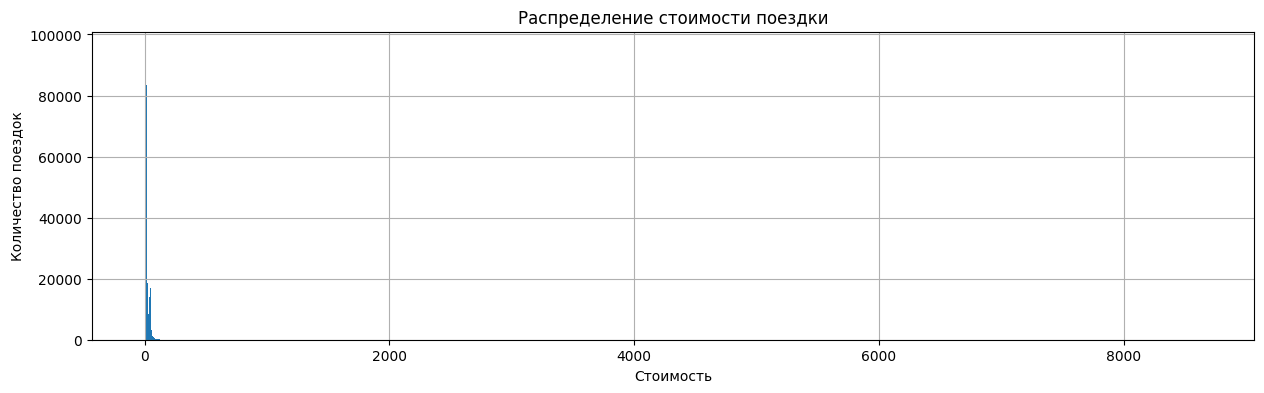

In [ ]:
df.query('trip_seconds == 0')['trip_total'].hist(bins=1000, figsize=(15, 4))
plt.title('Распределение стоимости поездки')
plt.xlabel('Стоимость')
plt.ylabel('Количество поездок')
plt.show()

Судя по всему есть большие выбросы.

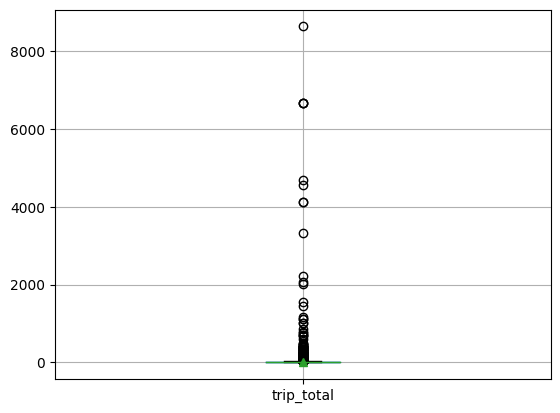

In [ ]:
df.query('trip_seconds == 0').boxplot('trip_total', showmeans=True, grid=True)
plt.show()

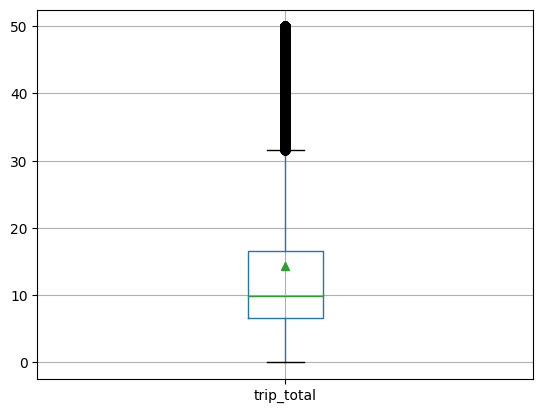

In [ ]:
df.query('trip_seconds == 0 and trip_total < 50').boxplot('trip_total', showmeans=True, grid=True)
plt.show()

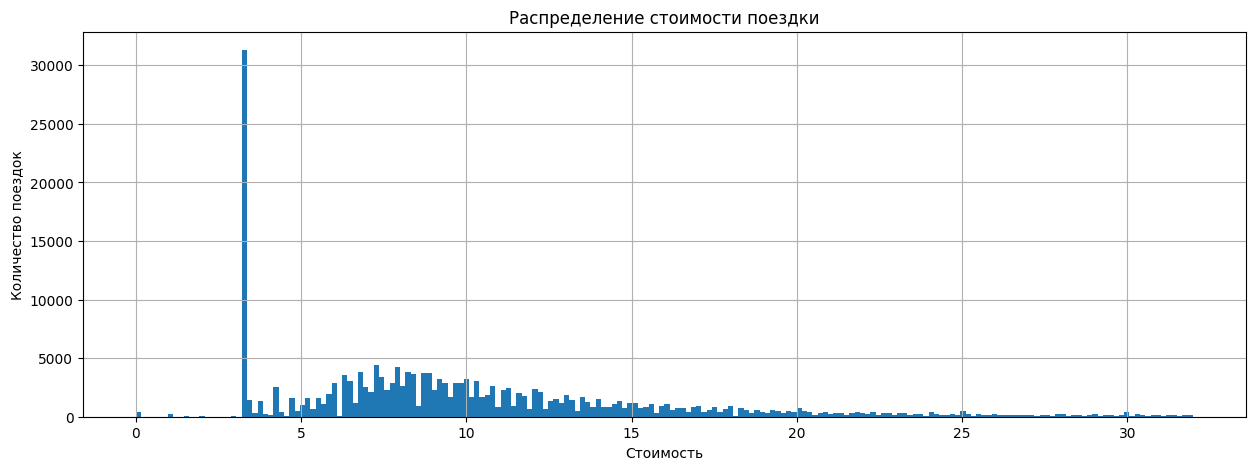

In [ ]:
df.query('trip_seconds == 0 and trip_total < 32')['trip_total'].hist(bins=200, figsize=(15, 5))
plt.title('Распределение стоимости поездки')
plt.xlabel('Стоимость')
plt.ylabel('Количество поездок')
plt.show()

In [ ]:
display(((df['trip_seconds'] == 0).sum())/(df['trip_start_timestamp'].count().sum())*100)

13.386996904024768

Итого, делаем вывод, что с большой долей вероятности поездки с 0 временем поездки - это несостоявшиеся поездки менее 15 минут, за которые были взяты деньги за ожидание. Чаще всего за такую отмененную поездку брали около 3 долларов. Также в данных есть огромные выбросы более 8000 долларов, как мне кажется, это какой-то сбой.

Итак, по сути машина была подана, но этим не воспользовались, поэтому удалять данные не будем. С выбросами разберемся дальше.

In [ ]:
#df = df.drop(df.query('trip_seconds == 0').index).reset_index(drop=True)

In [ ]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1824950 entries, 0 to 1824949
Data columns (total 19 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   trip_start_timestamp        1824950 non-null  datetime64[ns]
 1   trip_end_timestamp          1824950 non-null  datetime64[ns]
 2   trip_seconds                1824950 non-null  float64       
 3   trip_miles                  1824950 non-null  float64       
 4   pickup_community_area       1600934 non-null  float64       
 5   dropoff_community_area      1567331 non-null  float64       
 6   fare                        1824950 non-null  float64       
 7   tips                        1824950 non-null  float64       
 8   tolls                       1824950 non-null  float64       
 9   extras                      1824950 non-null  float64       
 10  trip_total                  1824950 non-null  float64       
 11  payment_type            

Теперь посмотрим вторую таблицу

In [ ]:
get_info(df_cover)

Hour Trip Start   Estimated coverage
0 2015-02-01 00:00:00                 0.36
1 2015-02-01 01:00:00                 0.61
2 2015-02-01 02:00:00                 0.74
3 2015-02-01 03:00:00                 0.73
4 2015-02-01 04:00:00                 0.79

count                 mean  \
Estimated coverage             1,411.00                 0.73   

                                    std                  min  \
Estimated coverage                 0.08                 0.00   

                                    25%                  50%  \
Estimated coverage                 0.71                 0.73   

                                    75%                  max  
Estimated coverage                 0.76                 1.00

----
Информация о пропусках и типах данных
----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1413 entries, 0 to 1412
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Hour Trip Start     1413 non-null   datetime64[ns]
 1   Estimated coverage  1411 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.2 KB


None

----


In [ ]:
df_cover.columns = [x.lower().replace(' ', '_') for x in df_cover.columns]

In [ ]:
df_cover.loc[(df_cover['estimated_coverage'].isna())]

hour_trip_start  estimated_coverage
75   2015-02-04 04:00:00                 NaN
1250 2015-03-25 06:00:00                 NaN

Скорее всего здесь данные отсутствуют из-за отсутствия покрытия в определенный час. Заполним 0.

In [ ]:
df_cover['estimated_coverage'] = df_cover['estimated_coverage'].fillna(0)

In [ ]:
get_info(df_cover)

hour_trip_start   estimated_coverage
0 2015-02-01 00:00:00                 0.36
1 2015-02-01 01:00:00                 0.61
2 2015-02-01 02:00:00                 0.74
3 2015-02-01 03:00:00                 0.73
4 2015-02-01 04:00:00                 0.79

count                 mean  \
estimated_coverage             1,413.00                 0.73   

                                    std                  min  \
estimated_coverage                 0.08                 0.00   

                                    25%                  50%  \
estimated_coverage                 0.71                 0.73   

                                    75%                  max  
estimated_coverage                 0.76                 1.00

----
Информация о пропусках и типах данных
----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1413 entries, 0 to 1412
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   hour_trip_start     1413 non-null   datetime64[ns]
 1   estimated_coverage  1413 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.2 KB


None

----


### Дубликаты

In [ ]:
df.duplicated().sum()

1713

In [ ]:
df = df.drop_duplicates().reset_index(drop=True)

In [ ]:
df.head()

trip_start_timestamp  trip_end_timestamp         trip_seconds  \
0  2015-02-06 06:45:00 2015-02-06 07:00:00               540.00   
1  2015-02-13 20:30:00 2015-02-13 20:45:00               600.00   
2  2015-03-11 23:30:00 2015-03-11 23:45:00               540.00   
3  2015-03-13 22:15:00 2015-03-13 22:15:00               360.00   
4  2015-03-13 22:15:00 2015-03-13 22:15:00                 0.00   

            trip_miles  pickup_community_area  dropoff_community_area  \
0                 2.80                  21.00                   15.00   
1                 2.00                   8.00                   28.00   
2                 0.10                  28.00                    8.00   
3                 1.70                  33.00                   32.00   
4                 0.00                    NaN                     NaN   

                  fare                 tips                tolls  \
0                 8.85                 0.00                 0.00   
1                 8.25                 1.00                 0.00   
2                 7.65                 0.00                 0.00   
3                 6.65                 0.00                 0.00   
4                40.85                 8.17                 0.00   

                extras           trip_total payment_type  \
0                 0.00                 8.85    No Charge   
1                 0.00                 9.25  Credit Card   
2                 0.00                 7.65         Cash   
3                 1.00                 7.65  Credit Card   
4                 0.00                49.02  Credit Card   

                                    company  pickup_centroid_latitude  \
0                       Top Cab Affiliation                     41.94   
1                     KOAM Taxi Association                     41.89   
2                 Taxi Affiliation Services                     41.88   
3                   Choice Taxi Association                     41.85   
4  Chicago Elite Cab Corp. (Chicago Carriag                       NaN   

   pickup_centroid_longitude  dropoff_centroid_latitude  \
0                     -87.71                      41.95   
1                     -87.62                      41.88   
2                     -87.64                      41.89   
3                     -87.62                      41.87   
4                        NaN                        NaN   

   dropoff_centroid_longitude  taxi_id           time_check  
0                      -87.76      250               900.00  
1                      -87.66     1915               900.00  
2                      -87.63      110               900.00  
3                      -87.63     1802                 0.00  
4                         NaN     3219                 0.00

От явных дубликатов избавились.

In [ ]:
df['payment_type'].unique()

['No Charge', 'Credit Card', 'Cash', 'Unknown', 'Dispute']
Categories (5, object): ['Cash', 'Credit Card', 'Dispute', 'No Charge', 'Unknown']

In [ ]:
sorted(df['company'].unique())

['0118 - 42111 Godfrey S.Awir',
 '0694 - 59280 Chinesco Trans Inc',
 '1085 - 72312 N and W Cab Co',
 '1247 - 72807 Daniel Ayertey',
 '1408 - 89599 Donald Barnes',
 '2092 - 61288 Sbeih company',
 '2192 - 73487 Zeymane Corp',
 '2241 - 44667 Manuel Alonso',
 '2733 - 74600 Benny Jona',
 '2823 - 73307 Seung Lee',
 '3011 - 66308 JBL Cab Inc.',
 '3094 - 24059 G.L.B. Cab Co',
 '3141 - 87803 Zip Cab',
 '3141 - Zip Cab',
 '3152 - 97284 Crystal Abernathy',
 '3201 - C&D Cab Co Inc',
 '3253 - 91138 Gaither Cab Co.',
 '3385 - 23210  Eman Cab',
 '3556 - 36214 RC Andrews Cab',
 "3591 - 63480 Chuk's Cab",
 '3620 - 52292 David K. Cab Corp.',
 '3623 - 72222 Arrington Enterprises',
 '3669 - 85800 Jordan Taxi Inc',
 '3897 - 57856 Ilie Malec',
 '4053 - 40193 Adwar H. Nikola',
 '4197 - 41842 Royal Star',
 '4615 - 83503 Tyrone Henderson',
 '4623 - 27290 Jay Kim',
 '4787 - 56058 Reny Cab Co',
 '5006 - 39261 Salifu Bawa',
 '5062 - 34841 Sam Mestas',
 '5074 - 54002 Ahzmi Inc',
 '5129 - 98755 Mengisti Taxi',
 '57

In [ ]:
df_cover.duplicated().sum()

0

От дубликатов избавились.

### Аномалии

Проверим выбросы в количественных переменных.

In [ ]:
df[['trip_seconds', 'trip_miles', 'fare', 'tips', 'trip_total']].describe().T

count                 mean                  std  \
trip_seconds         1,823,237.00               666.91               679.17   
trip_miles           1,823,237.00                 2.17                 4.74   
fare                 1,823,237.00                11.95                15.59   
tips                 1,823,237.00                 1.36                 2.41   
trip_total           1,823,237.00                14.16                32.87   

                              min                  25%                  50%  \
trip_seconds                 0.00               240.00               480.00   
trip_miles                   0.00                 0.00                 0.60   
fare                         0.00                 5.85                 8.05   
tips                         0.00                 0.00                 0.00   
trip_total                   0.01                 6.85                 9.35   

                              75%                  max  
trip_seconds               840.00            80,940.00  
trip_miles                   2.00               835.20  
fare                        12.85             9,449.33  
tips                         2.00               396.25  
trip_total                  14.65             9,449.33

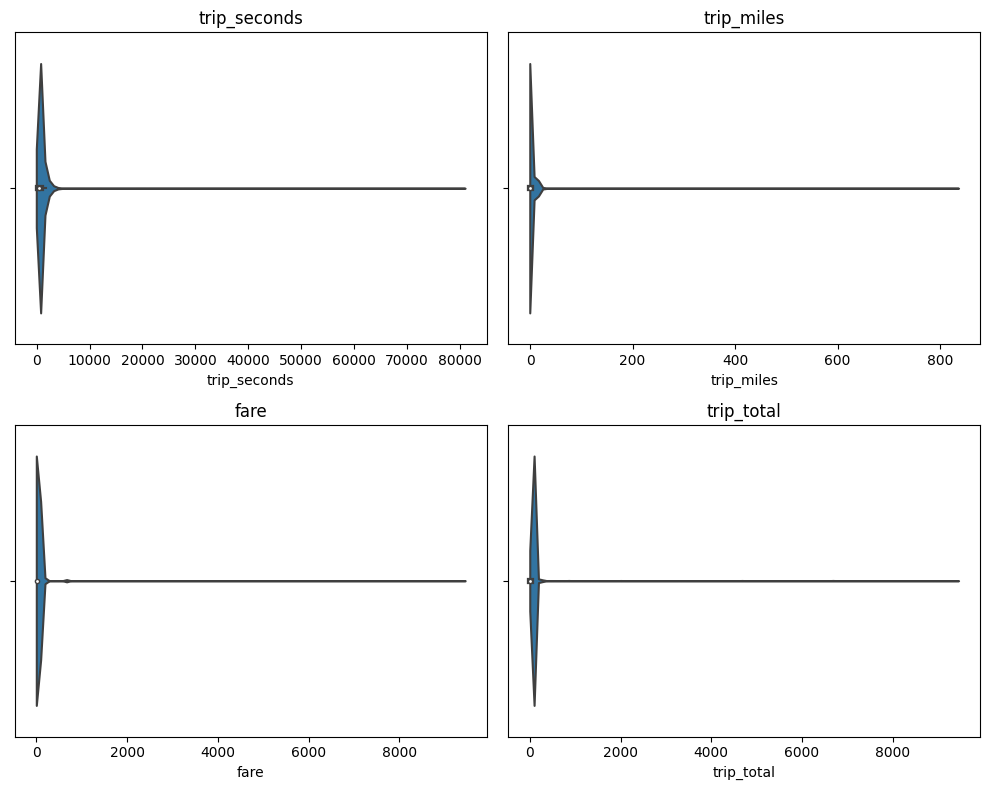

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

columns = ['trip_seconds', 'trip_miles', 'fare', 'trip_total']

for i, column in enumerate(columns):
    ax = axes[i // 2, i % 2]
    sns.violinplot(x=column, data=df, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

Посчитаем верхнюю границу усов у ящика с усами, так как на графике это не очень наглядно.

In [ ]:
def get_whisker(data: Series):
    """функция для вывода верхнего уса и количества выбросов"""

    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    whisker_up = q3 + 1.5 * iqr
    print('Верхний ус =', whisker_up)
    print('Количество строк выше верхнего уса -', (((data > whisker_up).sum()) / data.count() * 100).round(2), '%')

In [ ]:
get_whisker(df["trip_seconds"])

Верхний ус = 1740.0
Количество строк выше верхнего уса - 6.25 %


In [ ]:
get_whisker(df["trip_miles"])

Верхний ус = 5.0
Количество строк выше верхнего уса - 11.33 %


In [ ]:
get_whisker(df["trip_total"])

Верхний ус = 26.35
Количество строк выше верхнего уса - 12.92 %


Выбросов очень много, изучим их, сделав срез, по самому большому проценту выбросов - стоимости.

In [ ]:
df_outliers = df.query('trip_total > 27')

In [ ]:
df_outliers[['trip_seconds', 'trip_miles', 'fare', 'tips', 'trip_total']].describe().T

count                 mean                  std  \
trip_seconds           231,841.00             1,627.20             1,182.94   
trip_miles             231,841.00                 8.43                 9.23   
fare                   231,841.00                35.39                34.17   
tips                   231,841.00                 4.85                 4.59   
trip_total             231,841.00                44.13                85.59   

                              min                  25%                  50%  \
trip_seconds                 0.00             1,200.00             1,620.00   
trip_miles                   0.00                 0.00                 8.00   
fare                         0.00                29.65                34.85   
tips                         0.00                 0.00                 5.61   
trip_total                  27.04                35.45                40.85   

                              75%                  max  
trip_seconds             2,220.00            48,900.00  
trip_miles                  16.80               835.20  
fare                        37.65             9,449.33  
tips                         7.65               396.25  
trip_total                  46.62             9,449.33

In [ ]:
df_outliers.query('trip_miles < 1 and trip_seconds == 0').sort_values(by='trip_total', ascending=False).count()

trip_start_timestamp          45109
trip_end_timestamp            45109
trip_seconds                  45109
trip_miles                    45109
pickup_community_area          1625
dropoff_community_area         1282
fare                          45109
tips                          45109
tolls                         45109
extras                        45109
trip_total                    45109
payment_type                  45109
company                       45109
pickup_centroid_latitude       1630
pickup_centroid_longitude      1630
dropoff_centroid_latitude      1287
dropoff_centroid_longitude     1287
taxi_id                       45109
time_check                    45109
dtype: int64

Удалим строки с несостоявшимися поездками, они определенно не могут столько стоить.

In [ ]:
df = df.drop(df_outliers.query('trip_miles < 1 and trip_seconds == 0').index).reset_index(drop=True)

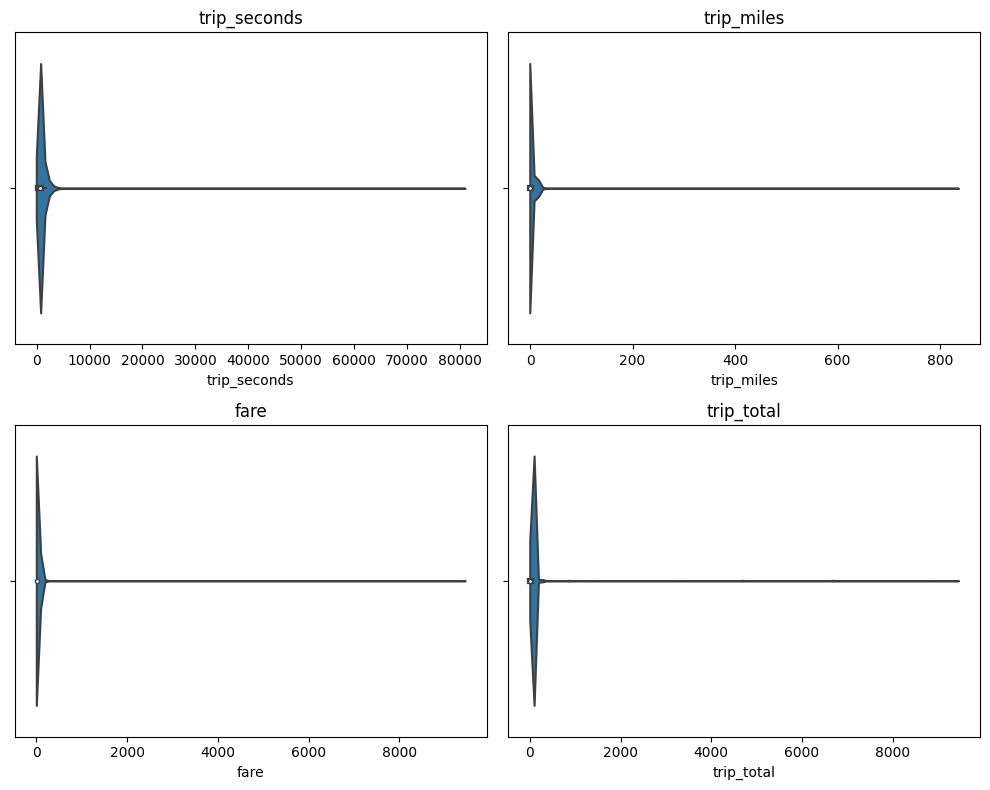

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

columns = ['trip_seconds', 'trip_miles', 'fare', 'trip_total']

for i, column in enumerate(columns):
    ax = axes[i // 2, i % 2]
    sns.violinplot(x=column, data=df, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

Сделаем срез еще раз.

In [ ]:
df_outliers = df.query('trip_total > 27')

In [ ]:
df_outliers[['trip_seconds', 'trip_miles', 'fare', 'tips', 'trip_total']].describe().T

count                 mean                  std  \
trip_seconds           186,732.00             2,020.28               971.21   
trip_miles             186,732.00                10.46                 9.20   
fare                   186,732.00                34.53                27.02   
tips                   186,732.00                 4.50                 4.46   
trip_total             186,732.00                43.47                85.61   

                              min                  25%                  50%  \
trip_seconds                 0.00             1,440.00             1,800.00   
trip_miles                   0.00                 0.90                12.90   
fare                         0.01                29.45                34.65   
tips                         0.00                 0.00                 5.00   
trip_total                  27.04                35.05                40.25   

                              75%                  max  
trip_seconds             2,400.00            48,900.00  
trip_miles                  17.40               835.20  
fare                        37.05             9,449.33  
tips                         7.55               300.00  
trip_total                  46.10             9,449.33

In [ ]:
get_whisker(df_outliers["trip_total"])

Верхний ус = 62.67500000000001
Количество строк выше верхнего уса - 4.51 %


In [ ]:
get_whisker(df_outliers["trip_miles"])

Верхний ус = 42.15
Количество строк выше верхнего уса - 0.18 %


In [ ]:
df_outliers.sort_values(by='trip_miles', ascending=False)

trip_start_timestamp  trip_end_timestamp         trip_seconds  \
177357   2015-02-13 15:00:00 2015-02-13 15:00:00                 0.00   
898139   2015-03-10 13:15:00 2015-03-10 13:15:00                60.00   
153130   2015-02-10 22:15:00 2015-02-11 06:00:00            27,720.00   
1726641  2015-03-29 06:15:00 2015-03-29 13:00:00            24,480.00   
803233   2015-03-02 08:00:00 2015-03-02 08:30:00             1,920.00   
...                      ...                 ...                  ...   
444688   2015-02-25 00:45:00 2015-02-25 01:30:00             3,180.00   
640705   2015-02-09 12:45:00 2015-02-09 14:30:00             6,660.00   
1373586  2015-03-08 01:15:00 2015-03-08 01:45:00             1,620.00   
444744   2015-02-25 16:45:00 2015-02-25 17:30:00             1,980.00   
1542856  2015-03-22 20:30:00 2015-03-22 21:00:00             1,800.00   

                  trip_miles  pickup_community_area  dropoff_community_area  \
177357                835.20                  32.00                   32.00   
898139                762.40                  65.00                   65.00   
153130                516.90                  34.00                     NaN   
1726641               402.40                   8.00                     NaN   
803233                300.70                   5.00                   30.00   
...                      ...                    ...                     ...   
444688                  0.00                   8.00                     NaN   
640705                  0.00                   3.00                    3.00   
1373586                 0.00                  56.00                    3.00   
444744                  0.00                  76.00                    4.00   
1542856                 0.00                  33.00                   76.00   

                        fare                 tips                tolls  \
177357                 37.25                 0.00                 0.00   
898139                 36.25                 0.00                 0.00   
153130                930.85                 0.00                 0.00   
1726641               740.25                 0.00                 0.00   
803233                 26.45                 0.00                 0.00   
...                      ...                  ...                  ...   
444688                 51.65                 0.00                 0.00   
640705                 39.85                 0.00                 0.00   
1373586                37.65                 7.90                 0.00   
444744                 27.05                 0.00                 0.00   
1542856                39.85                 0.00                 0.00   

                      extras           trip_total payment_type  \
177357                  3.00                40.25         Cash   
898139                  2.00                38.25         Cash   
153130                  0.00               930.85         Cash   
1726641                 0.00               740.25         Cash   
803233                  3.00                29.45         Cash   
...                      ...                  ...          ...   
444688                  1.00                52.65         Cash   
640705                  0.00                39.85         Cash   
1373586                 2.00                47.55  Credit Card   
444744                  2.00                29.05         Cash   
1542856                 2.00                41.85         Cash   

                                   company  pickup_centroid_latitude  \
177357           Taxi Affiliation Services                     41.87   
898139           Taxi Affiliation Services                     41.77   
153130           Taxi Affiliation Services                     41.84   
1726641          Taxi Affiliation Services                     41.89   
803233           Taxi Affiliation Services                     41.95   
...                                    ...                       ...

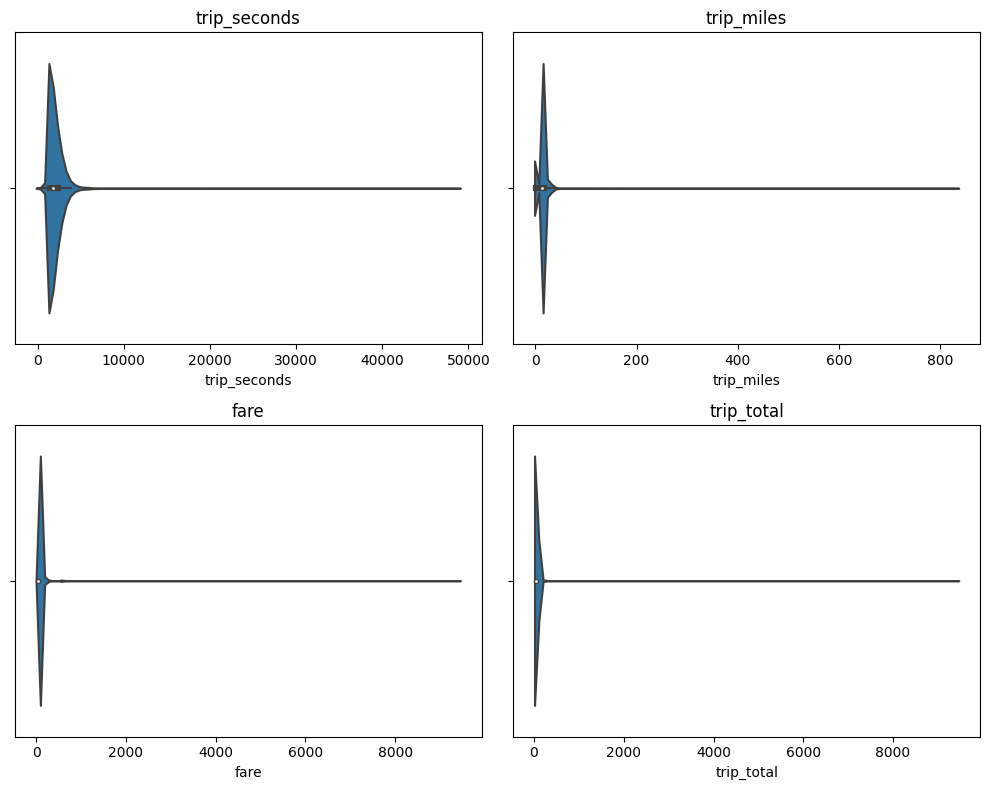

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

columns = ['trip_seconds', 'trip_miles', 'fare', 'trip_total']

for i, column in enumerate(columns):
    ax = axes[i // 2, i % 2]
    sns.violinplot(x=column, data=df_outliers, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

От одного конца Чикаго до другого (с севера на юг) около 30 миль, Поэтому даже предположив, что клиент прокатился по кругу около 60 миль, вряд ли он бы проехал 800 миль - это расстояние от Чикаго до Далласа по прямой, практически через четверть страны. но удалять ничего не будем, могли ведь и Вегас вечером в пятницу рвануть.

In [ ]:
#df = df.drop(df.query('trip_miles > 60').index).reset_index(drop=True)

In [ ]:
get_whisker(df["trip_total"])

Верхний ус = 24.675
Количество строк выше верхнего уса - 11.35 %


In [ ]:
get_whisker(df["trip_seconds"])

Верхний ус = 1800.0
Количество строк выше верхнего уса - 5.9 %


In [ ]:
df.query('trip_total > 1000')

trip_start_timestamp  trip_end_timestamp         trip_seconds  \
23018    2015-02-12 17:45:00 2015-02-12 17:45:00               300.00   
53484    2015-02-16 19:30:00 2015-02-16 19:45:00               360.00   
60880    2015-02-18 14:45:00 2015-02-18 14:45:00               300.00   
123596   2015-03-17 23:00:00 2015-03-17 23:00:00               300.00   
152524   2015-02-11 12:30:00 2015-02-11 12:45:00             1,380.00   
160681   2015-02-11 00:15:00 2015-02-11 00:15:00                60.00   
181857   2015-03-19 06:45:00 2015-03-19 07:15:00             1,440.00   
274503   2015-03-24 20:45:00 2015-03-24 21:00:00               780.00   
319252   2015-02-03 15:00:00 2015-02-03 15:30:00             1,500.00   
326006   2015-02-20 13:45:00 2015-02-20 13:45:00               360.00   
350839   2015-02-20 10:30:00 2015-02-20 10:30:00               360.00   
352670   2015-02-18 15:00:00 2015-02-18 15:00:00               120.00   
360088   2015-02-21 00:45:00 2015-02-21 00:45:00                60.00   
368049   2015-02-23 12:30:00 2015-02-23 12:45:00               300.00   
400678   2015-02-18 12:15:00 2015-02-18 12:30:00               420.00   
432795   2015-02-20 12:45:00 2015-02-20 13:00:00               600.00   
444473   2015-02-28 01:30:00 2015-02-28 01:30:00               360.00   
451890   2015-02-28 08:00:00 2015-02-28 08:15:00               420.00   
506684   2015-02-23 00:30:00 2015-02-23 00:45:00               840.00   
521387   2015-02-28 11:45:00 2015-02-28 12:00:00               480.00   
523043   2015-02-07 17:15:00 2015-02-07 17:30:00               420.00   
567268   2015-03-04 15:45:00 2015-03-04 15:45:00               240.00   
615588   2015-03-07 08:45:00 2015-03-07 09:00:00               420.00   
624207   2015-02-05 19:30:00 2015-02-05 19:45:00               780.00   
629115   2015-03-04 19:15:00 2015-03-04 19:30:00               360.00   
633429   2015-02-05 22:15:00 2015-02-05 22:30:00               300.00   
652666   2015-02-17 16:30:00 2015-02-17 16:45:00               240.00   
669228   2015-02-27 11:00:00 2015-02-27 11:30:00             1,080.00   
690504   2015-03-08 22:15:00 2015-03-08 22:15:00               300.00   
776037   2015-03-02 07:00:00 2015-03-02 07:15:00               840.00   
876598   2015-03-20 02:30:00 2015-03-20 02:30:00               240.00   
884199   2015-03-12 22:45:00 2015-03-12 23:15:00             1,680.00   
890245   2015-03-14 19:30:00 2015-03-14 19:30:00               540.00   
890815   2015-02-17 19:00:00 2015-02-17 19:00:00               480.00   
913768   2015-03-12 21:30:00 2015-03-12 21:45:00               840.00   
930979   2015-03-13 10:30:00 2015-03-13 10:30:00               540.00   
947200   2015-03-14 22:45:00 2015-03-14 22:45:00                60.00   
1027146  2015-02-27 07:30:00 2015-02-27 07:30:00               120.00   
1034801  2015-03-14 19:45:00 2015-03-14 20:00:00             1,260.00   
1113276  2015-03-11 20:00:00 2015-03-11 20:00:00               120.00   
1258989  2015-03-17 16:30:00 2015-03-17 16:30:00               600.00   
1317007  2015-03-28 15:00:00 2015-03-28 15:00:00                60.00   
1336177  2015-02-27 18:45:00 2015-02-27 18:45:00               360.00   
1411079  2015-03-28 17:30:00 2015-03-28 17:45:00               780.00   
1412404  2015-03-21 10:45:00 2015-03-21 11:00:00               660.00   
1421170  2015-03-20 23:30:00 2015-03-20 23:45:00               720.00   
1483081  2015-03-03 22:15:00 2015-03-03 22:30:00               480.00   
1501508  2015-03-21 00:30:00 2015-03-21 00:45:00               240.00   
1531219  2015-03-11 22:15:00 2015-03-11 22:30:00               300.00   
1533670  2015-03-04 10:30:00 2015-03-04 10:45:00               960.00   
1563741  2015-03-11 21:00:00 2015-03-11 21:00:00               480.00   
1595177  2015-03-17 22:30:00 2015-03-17 22:45:00                60.00   
1635251  2015-03-29 00:15:00 2015-03-29 00:30:00               300.00   
1645692  2015-03-06 20:45:00 2015-03-06 20:45:00               240

In [ ]:
df_outliers[['trip_seconds', 'trip_miles', 'fare', 'tips', 'trip_total']].describe().T

count                 mean                  std  \
trip_seconds           186,732.00             2,020.28               971.21   
trip_miles             186,732.00                10.46                 9.20   
fare                   186,732.00                34.53                27.02   
tips                   186,732.00                 4.50                 4.46   
trip_total             186,732.00                43.47                85.61   

                              min                  25%                  50%  \
trip_seconds                 0.00             1,440.00             1,800.00   
trip_miles                   0.00                 0.90                12.90   
fare                         0.01                29.45                34.65   
tips                         0.00                 0.00                 5.00   
trip_total                  27.04                35.05                40.25   

                              75%                  max  
trip_seconds             2,400.00            48,900.00  
trip_miles                  17.40               835.20  
fare                        37.05             9,449.33  
tips                         7.55               300.00  
trip_total                  46.10             9,449.33

In [ ]:
get_whisker(df_outliers["trip_total"])

Верхний ус = 62.67500000000001
Количество строк выше верхнего уса - 4.51 %


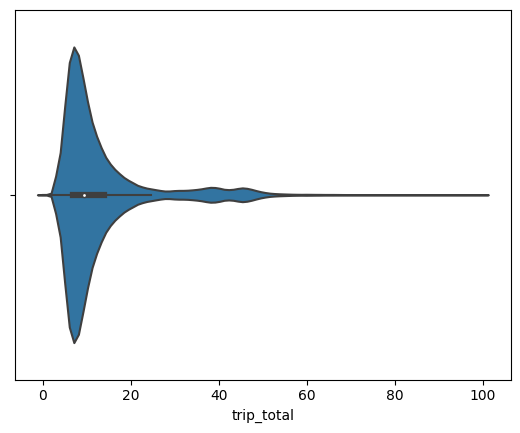

In [ ]:
sns.violinplot(x=df.query('trip_total<100')["trip_total"])
plt.show()

Стоимость на самом деле странная, хотя может быть это поездки випов или на вертолетах, но удалять не будем, лучше будем использовать в дальнейшем исследовании медиану, она менее подвергнута влиянию выбросов.

In [ ]:
#df = df.drop(df.query('trip_total > 100').index).reset_index(drop=True)

In [ ]:
df.query('trip_seconds > 2880').sort_values(by='trip_seconds', ascending=True)

trip_start_timestamp  trip_end_timestamp         trip_seconds  \
1226796  2015-03-02 10:15:00 2015-03-02 11:00:00             2,940.00   
306472   2015-02-13 19:45:00 2015-02-13 20:30:00             2,940.00   
1075317  2015-03-19 17:15:00 2015-03-19 18:00:00             2,940.00   
1075683  2015-02-19 19:45:00 2015-02-19 20:30:00             2,940.00   
1581870  2015-02-10 08:30:00 2015-02-10 09:30:00             2,940.00   
...                      ...                 ...                  ...   
344640   2015-02-03 20:45:00 2015-02-04 08:15:00            41,700.00   
438189   2015-02-19 02:30:00 2015-02-19 15:30:00            46,920.00   
454811   2015-02-24 21:15:00 2015-02-25 10:30:00            47,580.00   
352208   2015-02-03 05:00:00 2015-02-03 18:30:00            48,900.00   
508331   2015-02-20 23:45:00 2015-02-21 22:15:00            80,940.00   

                  trip_miles  pickup_community_area  dropoff_community_area  \
1226796                34.10                  76.00                     NaN   
306472                  0.90                  76.00                   77.00   
1075317                 0.90                  56.00                    6.00   
1075683                15.20                  76.00                    6.00   
1581870                 1.00                   8.00                   76.00   
...                      ...                    ...                     ...   
344640                  0.70                   6.00                   77.00   
438189                 55.80                   2.00                   28.00   
454811                 43.40                   7.00                   56.00   
352208                 21.90                  24.00                     NaN   
508331                  5.40                   8.00                   21.00   

                        fare                 tips                tolls  \
1226796                66.25                20.65                 0.00   
306472                 33.25                 3.75                 0.00   
1075317                36.65                 7.70                 0.00   
1075683                34.65                 9.15                 0.00   
1581870                39.25                 7.50                 0.00   
...                      ...                  ...                  ...   
344640                244.05                 0.00                 0.00   
438189                322.05                 0.00                 0.00   
454811                320.05                 0.00                 0.00   
352208                 42.85                 0.00                 0.00   
508331                 13.85                 4.75                 0.00   

                      extras           trip_total payment_type  \
1226796                37.00               123.90  Credit Card   
306472                  3.00                40.00  Credit Card   
1075317                 2.00                46.35  Credit Card   
1075683                 2.00                45.80  Credit Card   
1581870                 2.50                49.25  Credit Card   
...                      ...                  ...          ...   
344640                  0.00               244.05         Cash   
438189                  1.00               323.05    No Charge   
454811                  0.00               320.05         Cash   
352208                  2.00                44.85         Cash   
508331                  2.00                20.60  Credit Card   

                                   company  pickup_centroid_latitude  \
1226796          Taxi Affiliation Services                     41.98   
306472           Taxi Affiliation Services                     41.98   
1075317          Taxi Affiliation Services                     41.79   
1075683          Taxi Affiliation Services                     41.98   
1581870  Blue Ribbon Taxi Association Inc.                     41.89   
...                                    ...                       ...

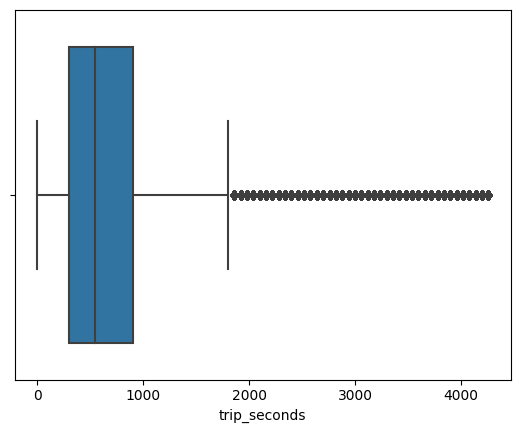

In [ ]:
sns.boxplot(x=df.query('trip_seconds < 4320')["trip_seconds"])
plt.show()

In [ ]:
get_whisker(df["trip_seconds"])

Верхний ус = 1800.0
Количество строк выше верхнего уса - 5.9 %


А вот слишком долгие поездки подозрительны, вряд ли клиенты катаются на такси по несколько дней подряд, скорее всего это ошибка. Предположим, что самая длинная поездка - 8 часов и удалим все, что больше по времени.

In [ ]:
df = df.drop(df.query('trip_seconds > 2880').index).reset_index(drop=True)

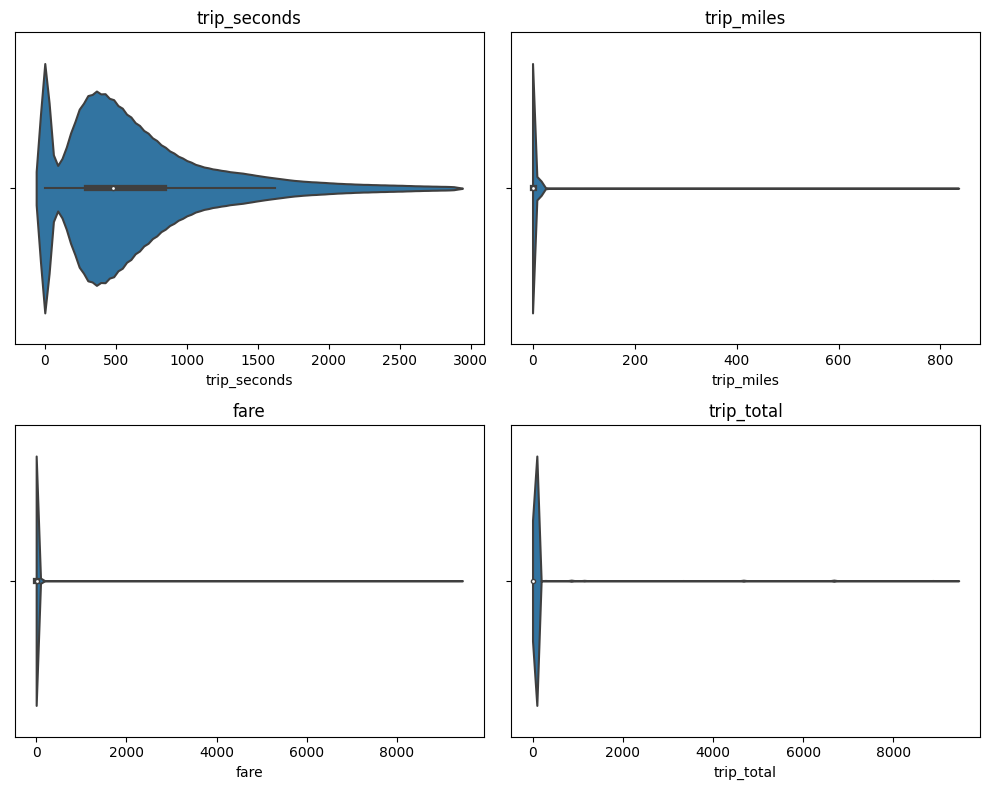

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

columns = ['trip_seconds', 'trip_miles', 'fare', 'trip_total']

for i, column in enumerate(columns):
    ax = axes[i // 2, i % 2]
    sns.violinplot(x=column, data=df, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

Пожалуй, остальное оставим. Проверим айди такси, я видела там отрицательные значения.

In [ ]:
df.query('taxi_id == -1')

trip_start_timestamp  trip_end_timestamp         trip_seconds  \
168885   2015-02-12 23:30:00 2015-02-12 23:45:00               720.00   
247902   2015-03-24 18:15:00 2015-03-24 18:15:00                 0.00   
278026   2015-03-24 18:15:00 2015-03-24 18:15:00                 0.00   
599716   2015-03-03 11:45:00 2015-03-03 11:45:00                60.00   
628121   2015-03-04 16:00:00 2015-03-04 16:00:00                60.00   
642898   2015-02-17 20:15:00 2015-02-17 20:15:00                 0.00   
652800   2015-03-04 16:00:00 2015-03-04 16:00:00                60.00   
972499   2015-02-17 20:15:00 2015-02-17 20:15:00                60.00   
1315382  2015-03-28 18:15:00 2015-03-28 18:15:00                60.00   
1716655  2015-02-17 20:00:00 2015-02-17 20:00:00                60.00   
1718662  2015-02-17 20:00:00 2015-02-17 20:00:00                 0.00   

                  trip_miles  pickup_community_area  dropoff_community_area  \
168885                  0.00                  16.00                   16.00   
247902                  0.00                  16.00                   16.00   
278026                  0.00                  16.00                   16.00   
599716                  0.00                  28.00                   28.00   
628121                  0.00                  16.00                   16.00   
642898                  0.00                  16.00                   16.00   
652800                  0.00                  16.00                   16.00   
972499                  0.00                  16.00                   16.00   
1315382                 0.00                  16.00                   16.00   
1716655                 0.00                  16.00                   16.00   
1718662                 0.00                  16.00                   16.00   

                        fare                 tips                tolls  \
168885                  6.25                 0.00                 0.00   
247902                  2.25                 0.00                 0.00   
278026                  2.25                 0.00                 0.00   
599716                 50.00                 0.00                 1.90   
628121                 40.58                 0.00                 0.00   
642898                  2.25                 0.00                 0.00   
652800                 40.00                 0.00                 1.90   
972499                  2.25                 0.00                 0.00   
1315382                36.00                 0.00                 0.00   
1716655                 2.45                 0.00                 0.00   
1718662                 2.25                 0.00                 0.00   

                      extras           trip_total payment_type  \
168885                  0.00                 6.25         Cash   
247902                  3.50                 5.75         Cash   
278026                  0.50                 2.75         Cash   
599716                 50.00               101.90         Cash   
628121                  0.00                40.58         Cash   
642898                  2.50                 4.75         Cash   
652800                 20.00                61.90         Cash   
972499                  3.00                 5.25         Cash   
1315382                 0.00                36.00         Cash   
1716655                 0.00                 2.45         Cash   
1718662                 0.00                 2.25         Cash   

                           company  pickup_centroid_latitude  \
168885   Dispatch Taxi Affiliation                     41.95   
247902   Dispatch Taxi Affiliation                     41.95   
278026   Dispatch Taxi Affiliation                     41.95   
599716   Dispatch Taxi Affiliation                     41.89   
628121   Dispatch Taxi Affiliation                     41.95   
642898   Dispatch Taxi Affiliation                     41.95   
652800   Dispatch Taxi Affiliation                  

Айди точно не должны быть отрицательными, к тому же сами данные не несут большой ценности, удаляем.

In [ ]:
df = df.drop(df.query('taxi_id == -1').index).reset_index(drop=True)

In [ ]:
df.describe().T

count                 mean  \
trip_seconds                       1,754,826.00               642.25   
trip_miles                         1,754,826.00                 2.11   
pickup_community_area              1,575,714.00                22.03   
dropoff_community_area             1,544,166.00                20.96   
fare                               1,754,826.00                10.86   
tips                               1,754,826.00                 1.20   
tolls                              1,754,826.00                 0.00   
extras                             1,754,826.00                 0.79   
trip_total                         1,754,826.00                12.85   
pickup_centroid_latitude           1,575,740.00                41.90   
pickup_centroid_longitude          1,575,740.00               -87.65   
dropoff_centroid_latitude          1,546,883.00                41.90   
dropoff_centroid_longitude         1,546,883.00               -87.65   
taxi_id                            1,754,826.00             1,157.72   
time_check                         1,754,826.00               644.22   

                                            std                  min  \
trip_seconds                             546.16                 0.00   
trip_miles                                 4.47                 0.00   
pickup_community_area                     18.63                 1.00   
dropoff_community_area                    17.35                 1.00   
fare                                      11.81                 0.00   
tips                                       2.05                 0.00   
tolls                                      0.15                 0.00   
extras                                    26.58                 0.00   
trip_total                                29.68                 0.01   
pickup_centroid_latitude                   0.04                41.66   
pickup_centroid_longitude                  0.06               -87.91   
dropoff_centroid_latitude                  0.04                41.66   
dropoff_centroid_longitude                 0.05               -87.91   
taxi_id                                  862.22                 1.00   
time_check                               658.95                 0.00   

                                            25%                  50%  \
trip_seconds                             300.00               480.00   
trip_miles                                 0.00                 0.70   
pickup_community_area                      8.00                16.00   
dropoff_community_area                     8.00                15.00   
fare                                       5.85                 7.85   
tips                                       0.00                 0.00   
tolls                                      0.00                 0.00   
extras                                     0.00                 0.00   
trip_total                                 6.85                 9.05   
pickup_centroid_latitude                  41.88                41.89   
pickup_centroid_longitude                -87.66               -87.63   
dropoff_centroid_latitude                 41.88                41.89   
dropoff_centroid_longitude               -87.66               -87.64   
taxi_id                                  424.00               998.00   
time_check                                 0.00               900.00   

                                            75%                  max  
trip_seconds                             840.00             2,880.00  
trip_miles                                 2.00               835.20  
pickup_community_area                     32.00                77.00  
dropoff_community_area                    32.00                77.00  
fare                                      11.85             9,449.33  
tips                                       2.00               300.00  
tolls                                      0.00               100.00  
extras         

In [ ]:
df_cover.describe().T

count                 mean  \
estimated_coverage             1,413.00                 0.73   

                                    std                  min  \
estimated_coverage                 0.08                 0.00   

                                    25%                  50%  \
estimated_coverage                 0.71                 0.73   

                                    75%                  max  
estimated_coverage                 0.76                 1.00

Во второй таблице все ок. Постарались избавиться от аномалий и при этом не удалять сильно много данных. Приступим к исследовательскому анализу.

## Исследовательский анализ данных

### Почасовые показатели

#### Количество машин на линии
Для начала добавим новый столбец с округлением времени начала поездки до ближайшего часа.

In [ ]:
df['hour_trip_start'] = df['trip_start_timestamp'].dt.floor('H')
df.head()

trip_start_timestamp  trip_end_timestamp         trip_seconds  \
0  2015-02-06 06:45:00 2015-02-06 07:00:00               540.00   
1  2015-02-13 20:30:00 2015-02-13 20:45:00               600.00   
2  2015-03-11 23:30:00 2015-03-11 23:45:00               540.00   
3  2015-03-13 22:15:00 2015-03-13 22:15:00               360.00   
4  2015-02-08 03:15:00 2015-02-08 03:30:00               540.00   

            trip_miles  pickup_community_area  dropoff_community_area  \
0                 2.80                  21.00                   15.00   
1                 2.00                   8.00                   28.00   
2                 0.10                  28.00                    8.00   
3                 1.70                  33.00                   32.00   
4                 2.60                   8.00                    8.00   

                  fare                 tips                tolls  \
0                 8.85                 0.00                 0.00   
1                 8.25                 1.00                 0.00   
2                 7.65                 0.00                 0.00   
3                 6.65                 0.00                 0.00   
4                 9.05                 0.00                 0.00   

                extras           trip_total payment_type  \
0                 0.00                 8.85    No Charge   
1                 0.00                 9.25  Credit Card   
2                 0.00                 7.65         Cash   
3                 1.00                 7.65  Credit Card   
4                 1.50                10.55         Cash   

                     company  pickup_centroid_latitude  \
0        Top Cab Affiliation                     41.94   
1      KOAM Taxi Association                     41.89   
2  Taxi Affiliation Services                     41.88   
3    Choice Taxi Association                     41.85   
4  Taxi Affiliation Services                     41.89   

   pickup_centroid_longitude  dropoff_centroid_latitude  \
0                     -87.71                      41.95   
1                     -87.62                      41.88   
2                     -87.64                      41.89   
3                     -87.62                      41.87   
4                     -87.63                      41.90   

   dropoff_centroid_longitude  taxi_id           time_check  \
0                      -87.76      250               900.00   
1                      -87.66     1915               900.00   
2                      -87.63      110               900.00   
3                      -87.63     1802                 0.00   
4                      -87.65     1953               900.00   

      hour_trip_start  
0 2015-02-06 06:00:00  
1 2015-02-13 20:00:00  
2 2015-03-11 23:00:00  
3 2015-03-13 22:00:00  
4 2015-02-08 03:00:00

In [ ]:
car_per_hour = df.groupby('hour_trip_start')['taxi_id'].nunique().reset_index(name='car_count')
car_per_hour['hour'] = car_per_hour['hour_trip_start'].dt.hour
car_per_hour['month'] = car_per_hour['hour_trip_start'].dt.month_name()
car_per_hour['week'] = car_per_hour['hour_trip_start'].dt.isocalendar().week
car_per_hour['day'] = car_per_hour['hour_trip_start'].dt.day
car_per_hour['weekday'] = car_per_hour['hour_trip_start'].dt.weekday+1
car_per_hour

hour_trip_start  car_count  hour     month  week  day  weekday
0    2015-02-01 00:00:00          6     0  February     5    1        7
1    2015-02-01 01:00:00          7     1  February     5    1        7
2    2015-02-01 02:00:00        840     2  February     5    1        7
3    2015-02-01 03:00:00        976     3  February     5    1        7
4    2015-02-01 04:00:00        452     4  February     5    1        7
...                  ...        ...   ...       ...   ...  ...      ...
1405 2015-03-31 19:00:00        794    19     March    14   31        2
1406 2015-03-31 20:00:00        847    20     March    14   31        2
1407 2015-03-31 21:00:00          6    21     March    14   31        2
1408 2015-03-31 22:00:00          8    22     March    14   31        2
1409 2015-03-31 23:00:00         18    23     March    14   31        2

[1410 rows x 7 columns]

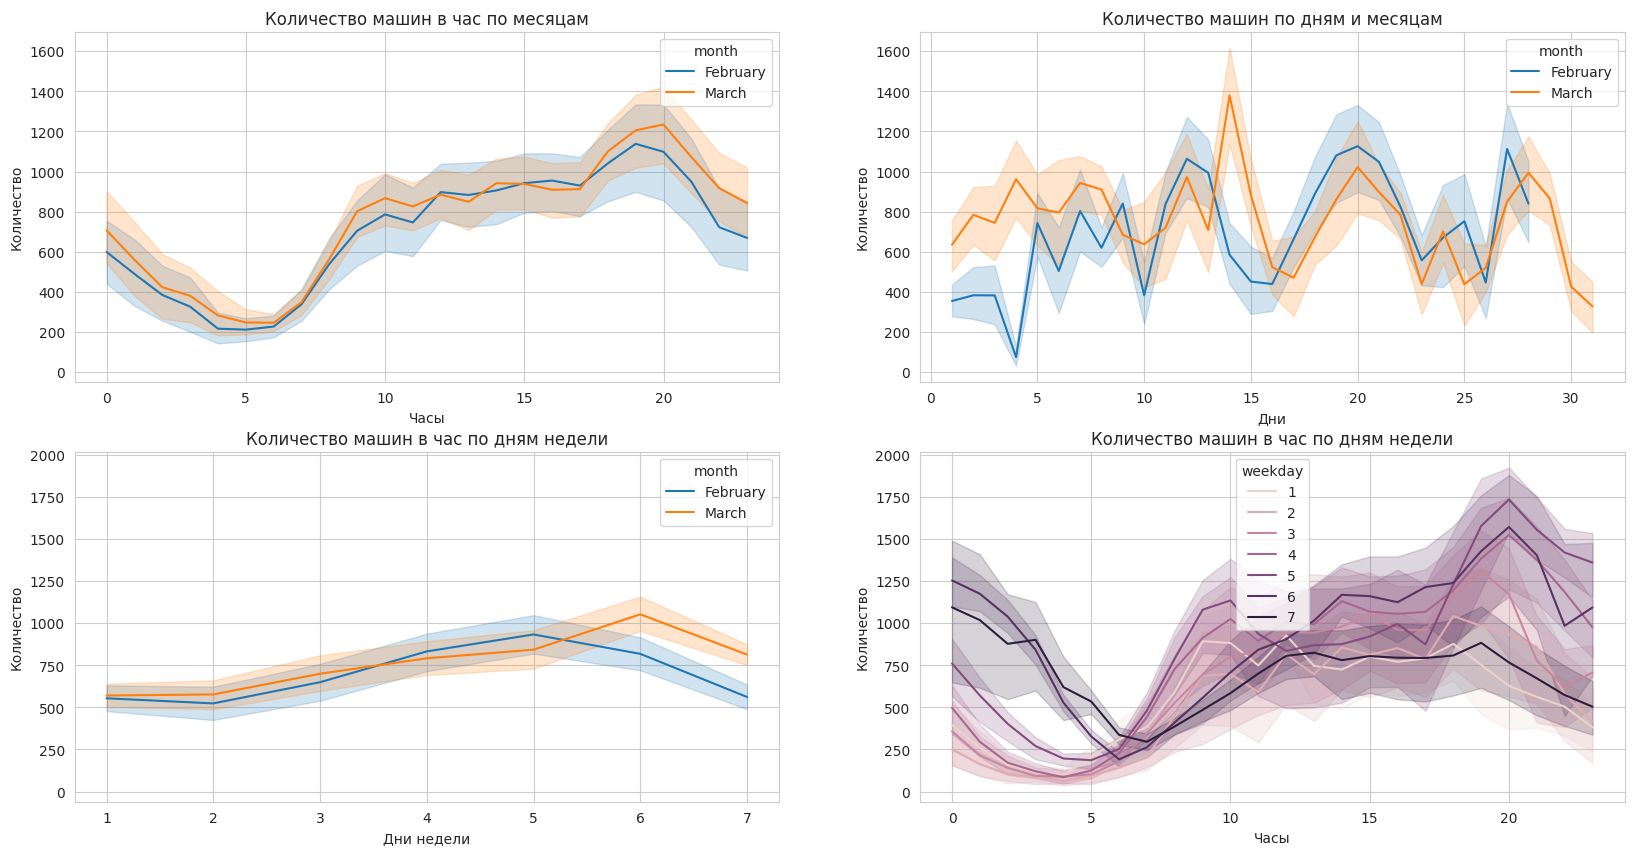

In [ ]:
plt.figure(figsize = (20, 10))
sns.set_style("whitegrid")

ax1=sns.lineplot(data=car_per_hour,
                  x="hour",
                  y="car_count",
                  hue="month",
                  ax=plt.subplot(2, 2, 1))
ax1.set_title('Количество машин в час по месяцам')
ax1.set_xlabel('Часы')
ax1.set_ylabel('Количество')

ax2 = sns.lineplot(data=car_per_hour,
                  x="day",
                  y="car_count",
                  hue="month",
                  ax=plt.subplot(2, 2, 2, sharey=ax1))
ax2.set_title('Количество машин по дням и месяцам')
ax2.set_xlabel('Дни')
ax2.set_ylabel('Количество')

ax3 = sns.lineplot(data=car_per_hour,
                  x="weekday",
                  y="car_count",
                  hue="month",
                  ax=plt.subplot(2, 2, 3))
ax3.set_title('Количество машин в час по дням недели')
ax3.set_xlabel('Дни недели')
ax3.set_ylabel('Количество')

ax4 = sns.lineplot(data=car_per_hour,
                  x="hour",
                  y="car_count",
                  hue="weekday",
                  ax=plt.subplot(2, 2, 4, sharey=ax3))
ax4.set_title('Количество машин в час по дням недели')
ax4.set_xlabel('Часы')
ax4.set_ylabel('Количество');

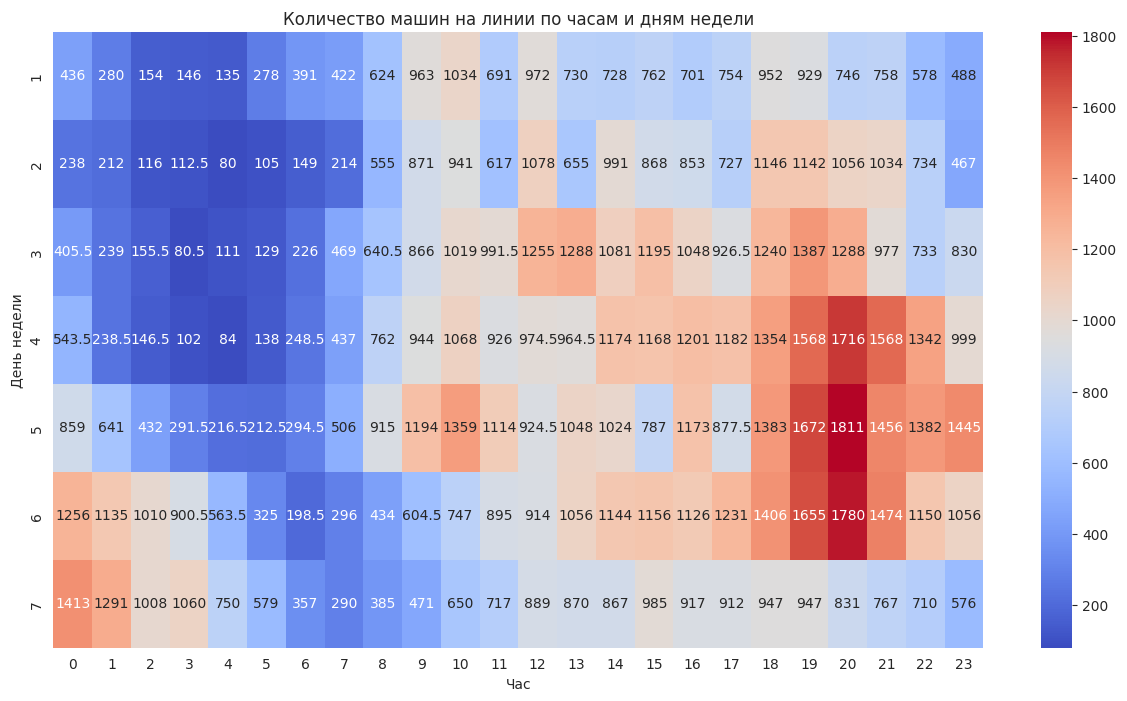

In [ ]:
pivot_table = car_per_hour.pivot_table(index='weekday', columns='hour', values='car_count', aggfunc='median')
plt.figure(figsize=(15, 8))

sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt=".4g")
plt.title('Количество машин на линии по часам и дням недели')
plt.xlabel('Час')
plt.ylabel('День недели')
plt.show()

Итак, у нас есть данные за 2 месяца - февраль и март.
Видим интересные закономерности:
1. Меньше всего машин на линии в промежуток времени с 4 до 6 утра, больше всего - в 7-8 вечера, причем в марте машин больше. В период с 10 утра до 5 вечера количество машин приблизительно одинаковое.
2. Видны всплески количества машин в середине месяцев, особенно 14 марта. В этот день был St. Patrick's Day Parade.
3. По дням недели наибольшее количество машин на линии - ближе к выходным. В марте - в субботу, а в феврале в пятницу. Возможно это связано с тем, что в выходные пытаются подработать те, кто работают пятидневку.
4. Если смотреть количество машин в разбивке по часам и дням недели, то в выходные ночью машин больше, чем в будни. А вот вечером больше всего машин в четверг, пятницу и субботу. Во второй половине недели днем машин больше, чем в воскресенье, понедельник и вторник.

#### Количество поездок

In [ ]:
trip_per_hour = df.groupby('hour_trip_start')['trip_seconds'].size().reset_index(name='trip_count')
trip_per_hour['hour'] = trip_per_hour['hour_trip_start'].dt.hour
trip_per_hour['month'] = trip_per_hour['hour_trip_start'].dt.month_name()
trip_per_hour['week'] = trip_per_hour['hour_trip_start'].dt.isocalendar().week
trip_per_hour['day'] = trip_per_hour['hour_trip_start'].dt.day
trip_per_hour['weekday'] = trip_per_hour['hour_trip_start'].dt.weekday+1
trip_per_hour

hour_trip_start  trip_count  hour     month  week  day  weekday
0    2015-02-01 00:00:00          10     0  February     5    1        7
1    2015-02-01 01:00:00          15     1  February     5    1        7
2    2015-02-01 02:00:00        1196     2  February     5    1        7
3    2015-02-01 03:00:00        2003     3  February     5    1        7
4    2015-02-01 04:00:00         591     4  February     5    1        7
...                  ...         ...   ...       ...   ...  ...      ...
1405 2015-03-31 19:00:00        1014    19     March    14   31        2
1406 2015-03-31 20:00:00        1131    20     March    14   31        2
1407 2015-03-31 21:00:00          15    21     March    14   31        2
1408 2015-03-31 22:00:00          11    22     March    14   31        2
1409 2015-03-31 23:00:00          18    23     March    14   31        2

[1410 rows x 7 columns]

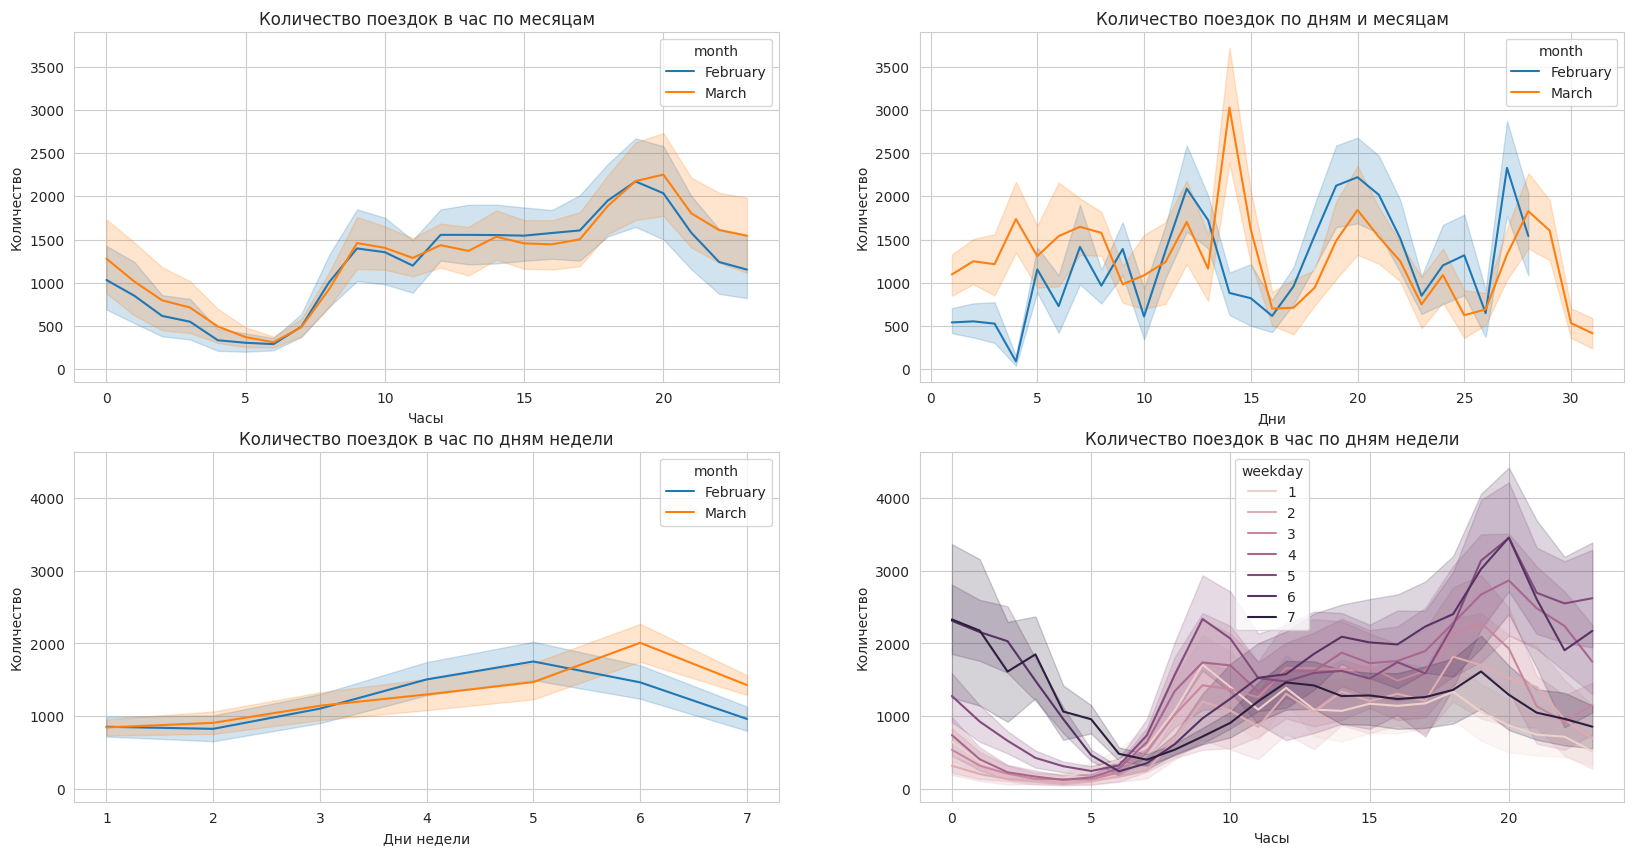

In [ ]:
plt.figure(figsize = (20, 10))
sns.set_style("whitegrid")

ax1=sns.lineplot(data=trip_per_hour,
                  x="hour",
                  y="trip_count",
                  hue="month",
                  ax=plt.subplot(2, 2, 1))
ax1.set_title('Количество поездок в час по месяцам')
ax1.set_xlabel('Часы')
ax1.set_ylabel('Количество')

ax2 = sns.lineplot(data=trip_per_hour,
                  x="day",
                  y="trip_count",
                  hue="month",
                  ax=plt.subplot(2, 2, 2, sharey=ax1))
ax2.set_title('Количество поездок по дням и месяцам')
ax2.set_xlabel('Дни')
ax2.set_ylabel('Количество')

ax3 = sns.lineplot(data=trip_per_hour,
                  x="weekday",
                  y="trip_count",
                  hue="month",
                  ax=plt.subplot(2, 2, 3))
ax3.set_title('Количество поездок в час по дням недели')
ax3.set_xlabel('Дни недели')
ax3.set_ylabel('Количество')

ax4 = sns.lineplot(data=trip_per_hour,
                  x="hour",
                  y="trip_count",
                  hue="weekday",
                  ax=plt.subplot(2, 2, 4, sharey=ax3))
ax4.set_title('Количество поездок в час по дням недели')
ax4.set_xlabel('Часы')
ax4.set_ylabel('Количество');

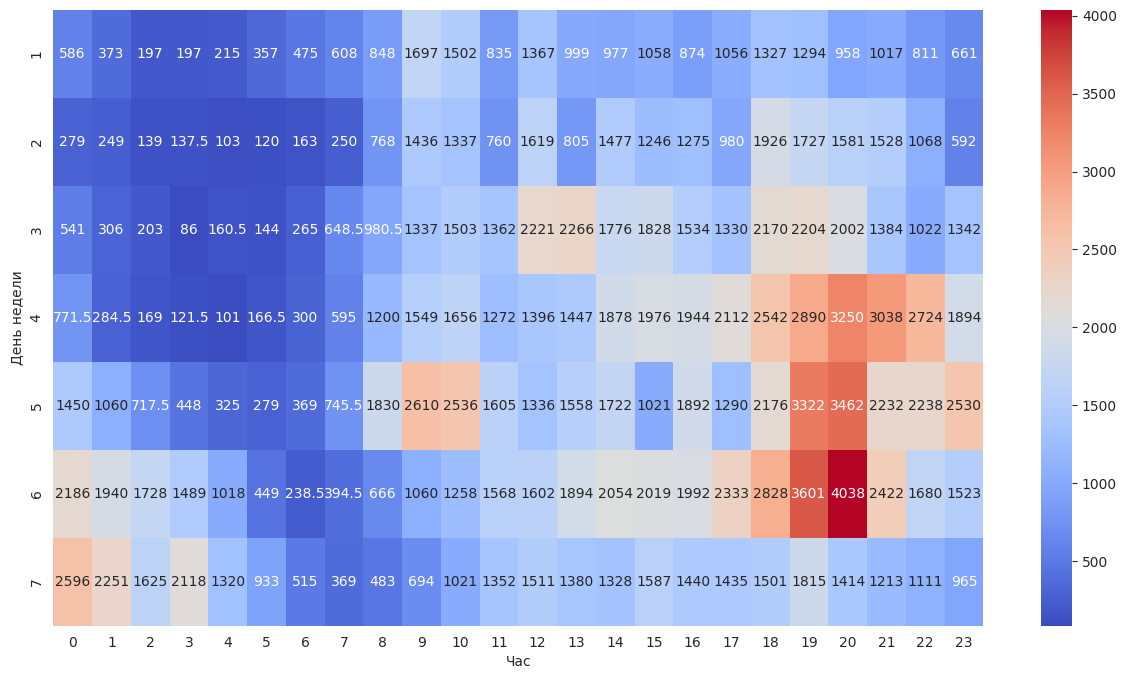

In [ ]:
pivot_table = trip_per_hour.pivot_table(index='weekday', columns='hour', values='trip_count', aggfunc='median')
plt.figure(figsize=(15, 8))

sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt=".4g")
plt.title('')
plt.xlabel('Час')
plt.ylabel('День недели')
plt.show()

Вцелом количество поездок практически полностью повторяет закономерности распределения количества машин на линии, кроме распределения по часам и дням недели.

Количество поездок в полночь и час ночи почти одинаковое в субботу и воскрсенье, а также с 6 до 9 вечера в пятницу и субботу, а вот машин в субботу вечером и в воскресенье ночью в это время меньше, что может говорить об их недостатке.

#### Средняя длительность поездки

In [ ]:
trip_duration = df.groupby('hour_trip_start')['trip_seconds'].median().reset_index(name='trip_duration')
trip_duration['hour'] = trip_duration['hour_trip_start'].dt.hour
trip_duration['month'] = trip_duration['hour_trip_start'].dt.month_name()
trip_duration['week'] = trip_duration['hour_trip_start'].dt.isocalendar().week
trip_duration['day'] = trip_duration['hour_trip_start'].dt.day
trip_duration['weekday'] = trip_duration['hour_trip_start'].dt.weekday+1
trip_duration

hour_trip_start        trip_duration  hour     month  week  day  \
0    2015-02-01 00:00:00               660.00     0  February     5    1   
1    2015-02-01 01:00:00               540.00     1  February     5    1   
2    2015-02-01 02:00:00               480.00     2  February     5    1   
3    2015-02-01 03:00:00               420.00     3  February     5    1   
4    2015-02-01 04:00:00               420.00     4  February     5    1   
...                  ...                  ...   ...       ...   ...  ...   
1405 2015-03-31 19:00:00               540.00    19     March    14   31   
1406 2015-03-31 20:00:00               480.00    20     March    14   31   
1407 2015-03-31 21:00:00               420.00    21     March    14   31   
1408 2015-03-31 22:00:00               300.00    22     March    14   31   
1409 2015-03-31 23:00:00               240.00    23     March    14   31   

      weekday  
0           7  
1           7  
2           7  
3           7  
4           7  
...       ...  
1405        2  
1406        2  
1407        2  
1408        2  
1409        2  

[1410 rows x 7 columns]

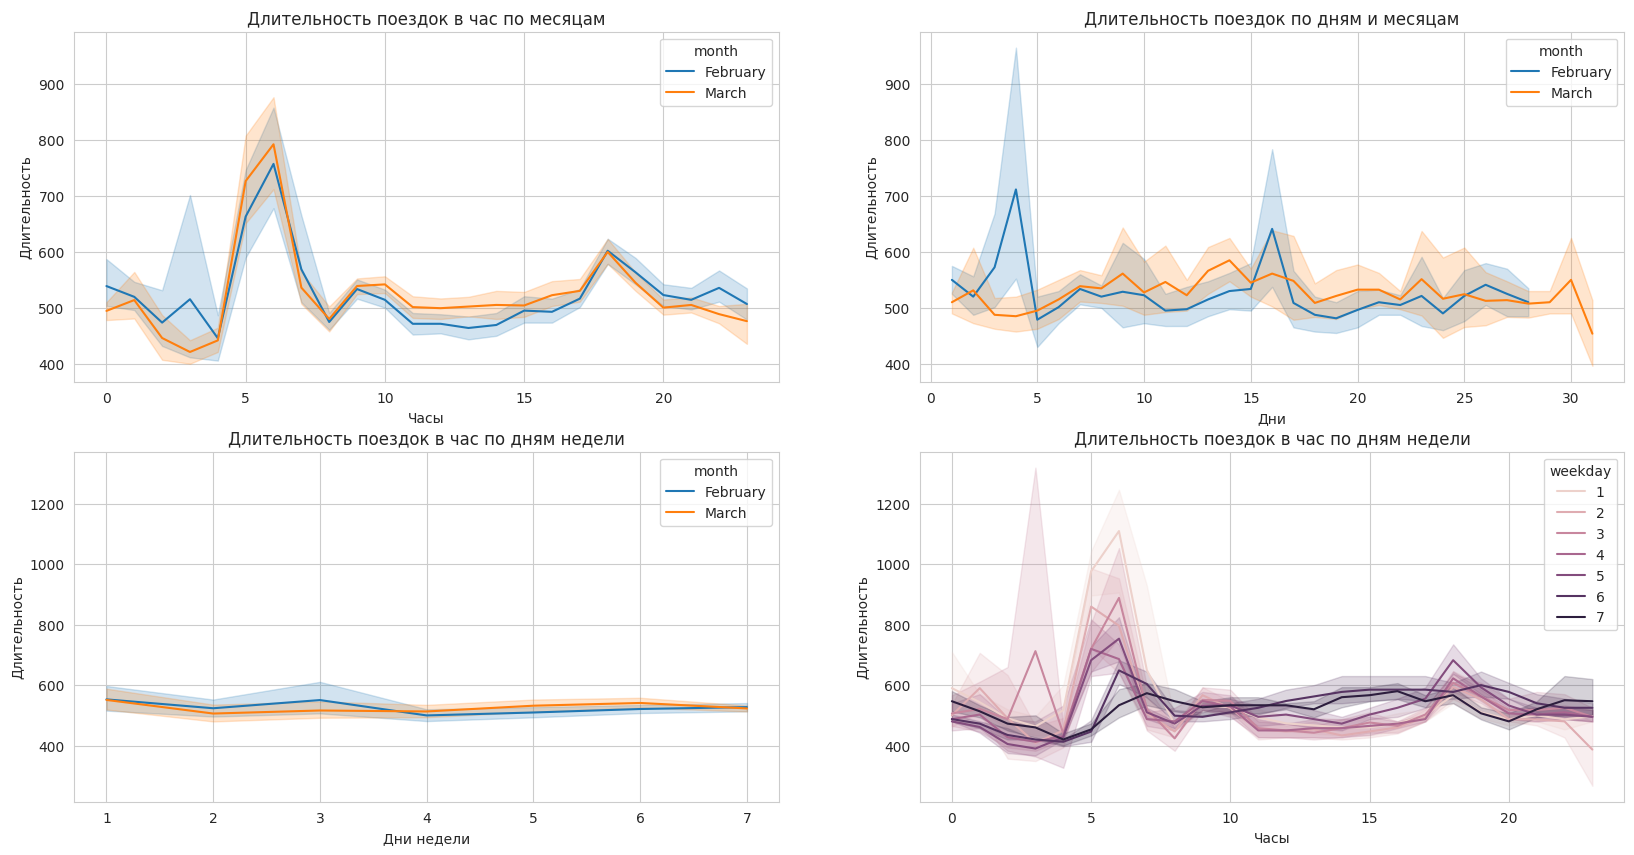

In [ ]:
plt.figure(figsize = (20, 10))
sns.set_style("whitegrid")

ax1=sns.lineplot(data=trip_duration,
                  x="hour",
                  y="trip_duration",
                  hue="month",
                  ax=plt.subplot(2, 2, 1))
ax1.set_title('Длительность поездок в час по месяцам')
ax1.set_xlabel('Часы')
ax1.set_ylabel('Длительность')

ax2 = sns.lineplot(data=trip_duration,
                  x="day",
                  y="trip_duration",
                  hue="month",
                  ax=plt.subplot(2, 2, 2, sharey=ax1))
ax2.set_title('Длительность поездок по дням и месяцам')
ax2.set_xlabel('Дни')
ax2.set_ylabel('Длительность')

ax3 = sns.lineplot(data=trip_duration,
                  x="weekday",
                  y="trip_duration",
                  hue="month",
                  ax=plt.subplot(2, 2, 3))
ax3.set_title('Длительность поездок в час по дням недели')
ax3.set_xlabel('Дни недели')
ax3.set_ylabel('Длительность')

ax4 = sns.lineplot(data=trip_duration,
                  x="hour",
                  y="trip_duration",
                  hue="weekday",
                  ax=plt.subplot(2, 2, 4, sharey=ax3))
ax4.set_title('Длительность поездок в час по дням недели')
ax4.set_xlabel('Часы')
ax4.set_ylabel('Длительность');

Видим следующие закономерности:
1. В 5 и 6 утра по будням (особенно в понедельник) резко увеличивается длительность поездки, что скорее всего связно с поездками на работу с другого конца города. В субботу этот всплеск сдвигается примерно на час (возможно, люди едут за город), а в воскресенье его почти нет.
2. Всплеск длительности 4 февраля, когда было выступление Джорджа Фримена в Чикаго - люди явно добирались издалека или стояли в пробках. 16 февраля тоже что-то было, это был понедельник, возможно были большие пробки.

#### Средняя длина поездки

In [ ]:
trip_length = df.groupby('hour_trip_start')['trip_miles'].median().reset_index(name='trip_length')
trip_length['hour'] = trip_length['hour_trip_start'].dt.hour
trip_length['month'] = trip_length['hour_trip_start'].dt.month_name()
trip_length['week'] = trip_length['hour_trip_start'].dt.isocalendar().week
trip_length['day'] = trip_length['hour_trip_start'].dt.day
trip_length['weekday'] = trip_length['hour_trip_start'].dt.weekday+1
trip_length

hour_trip_start          trip_length  hour     month  week  day  \
0    2015-02-01 00:00:00                 0.10     0  February     5    1   
1    2015-02-01 01:00:00                 0.90     1  February     5    1   
2    2015-02-01 02:00:00                 0.50     2  February     5    1   
3    2015-02-01 03:00:00                 0.60     3  February     5    1   
4    2015-02-01 04:00:00                 0.70     4  February     5    1   
...                  ...                  ...   ...       ...   ...  ...   
1405 2015-03-31 19:00:00                 0.70    19     March    14   31   
1406 2015-03-31 20:00:00                 0.80    20     March    14   31   
1407 2015-03-31 21:00:00                 0.80    21     March    14   31   
1408 2015-03-31 22:00:00                 0.00    22     March    14   31   
1409 2015-03-31 23:00:00                 0.05    23     March    14   31   

      weekday  
0           7  
1           7  
2           7  
3           7  
4           7  
...       ...  
1405        2  
1406        2  
1407        2  
1408        2  
1409        2  

[1410 rows x 7 columns]

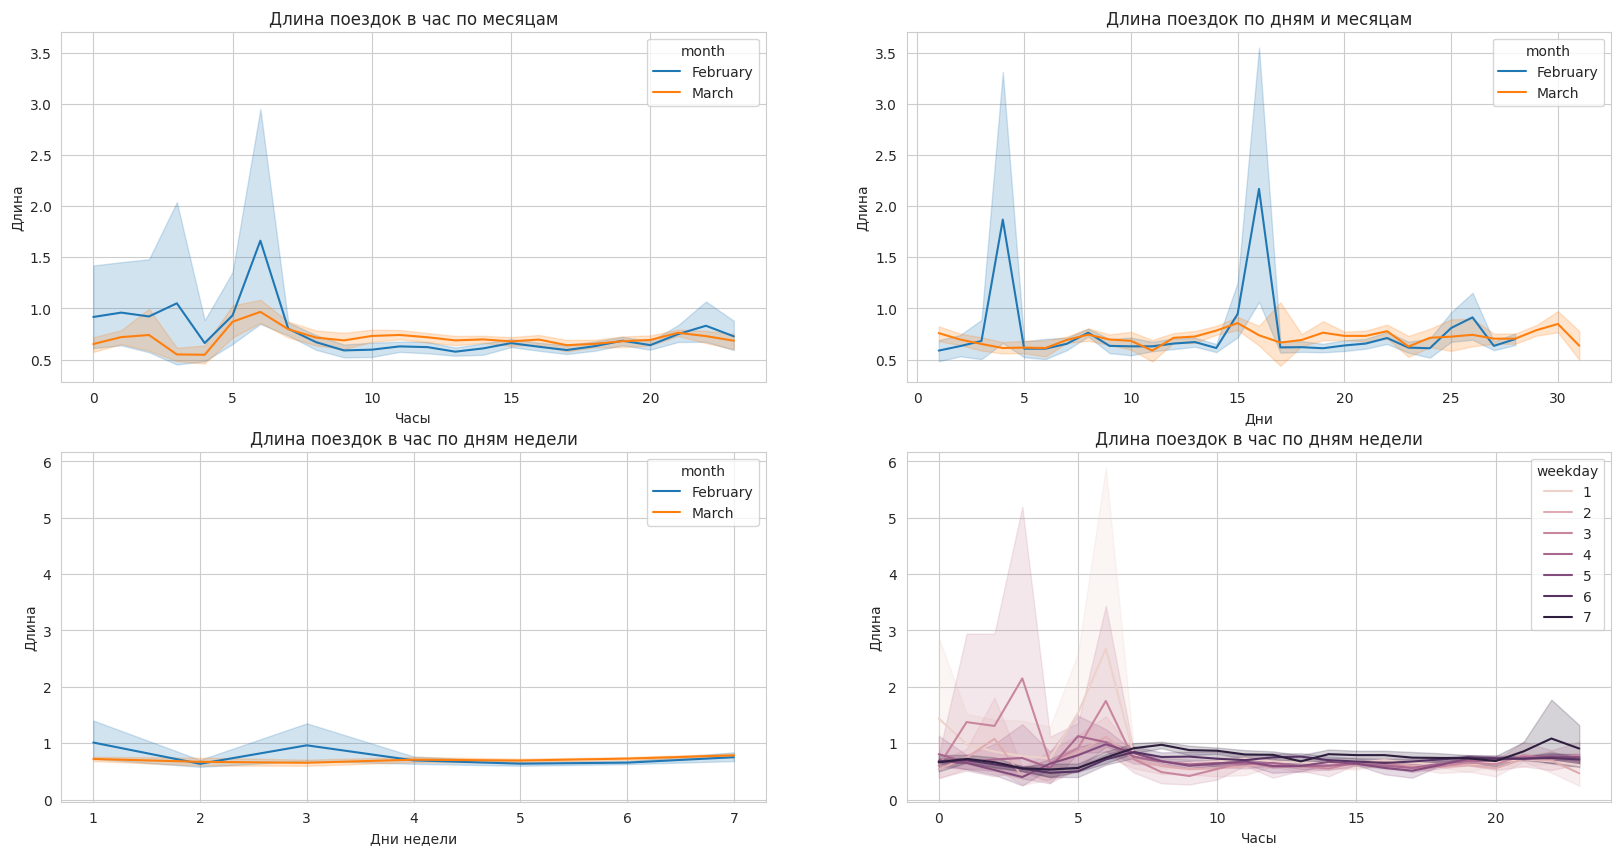

In [ ]:
plt.figure(figsize = (20, 10))
sns.set_style("whitegrid")

ax1=sns.lineplot(data=trip_length,
                  x="hour",
                  y="trip_length",
                  hue="month",
                  ax=plt.subplot(2, 2, 1))
ax1.set_title('Длина поездок в час по месяцам')
ax1.set_xlabel('Часы')
ax1.set_ylabel('Длина')

ax2 = sns.lineplot(data=trip_length,
                  x="day",
                  y="trip_length",
                  hue="month",
                  ax=plt.subplot(2, 2, 2, sharey=ax1))
ax2.set_title('Длина поездок по дням и месяцам')
ax2.set_xlabel('Дни')
ax2.set_ylabel('Длина')

ax3 = sns.lineplot(data=trip_length,
                  x="weekday",
                  y="trip_length",
                  hue="month",
                  ax=plt.subplot(2, 2, 3))
ax3.set_title('Длина поездок в час по дням недели')
ax3.set_xlabel('Дни недели')
ax3.set_ylabel('Длина')

ax4 = sns.lineplot(data=trip_length,
                  x="hour",
                  y="trip_length",
                  hue="weekday",
                  ax=plt.subplot(2, 2, 4, sharey=ax3))
ax4.set_title('Длина поездок в час по дням недели')
ax4.set_xlabel('Часы')
ax4.set_ylabel('Длина');

Длина поездок вцелом так же коррелирует с длительностью поездок и имеет те же закономерности, кроме того, что в феврале утренние поездки были длиннее.

#### Средняя тарифная стоимость поездки

In [ ]:
fare_avg = df.groupby('hour_trip_start')['fare'].median().reset_index(name='fare_avg')
fare_avg['hour'] = fare_avg['hour_trip_start'].dt.hour
fare_avg['month'] = fare_avg['hour_trip_start'].dt.month_name()
fare_avg['week'] = fare_avg['hour_trip_start'].dt.isocalendar().week
fare_avg['day'] = fare_avg['hour_trip_start'].dt.day
fare_avg['weekday'] = fare_avg['hour_trip_start'].dt.weekday+1
fare_avg

hour_trip_start             fare_avg  hour     month  week  day  \
0    2015-02-01 00:00:00                 9.35     0  February     5    1   
1    2015-02-01 01:00:00                 7.85     1  February     5    1   
2    2015-02-01 02:00:00                 8.05     2  February     5    1   
3    2015-02-01 03:00:00                 7.85     3  February     5    1   
4    2015-02-01 04:00:00                 8.05     4  February     5    1   
...                  ...                  ...   ...       ...   ...  ...   
1405 2015-03-31 19:00:00                 7.45    19     March    14   31   
1406 2015-03-31 20:00:00                 7.85    20     March    14   31   
1407 2015-03-31 21:00:00                 6.45    21     March    14   31   
1408 2015-03-31 22:00:00                11.05    22     March    14   31   
1409 2015-03-31 23:00:00                 9.55    23     March    14   31   

      weekday  
0           7  
1           7  
2           7  
3           7  
4           7  
...       ...  
1405        2  
1406        2  
1407        2  
1408        2  
1409        2  

[1410 rows x 7 columns]

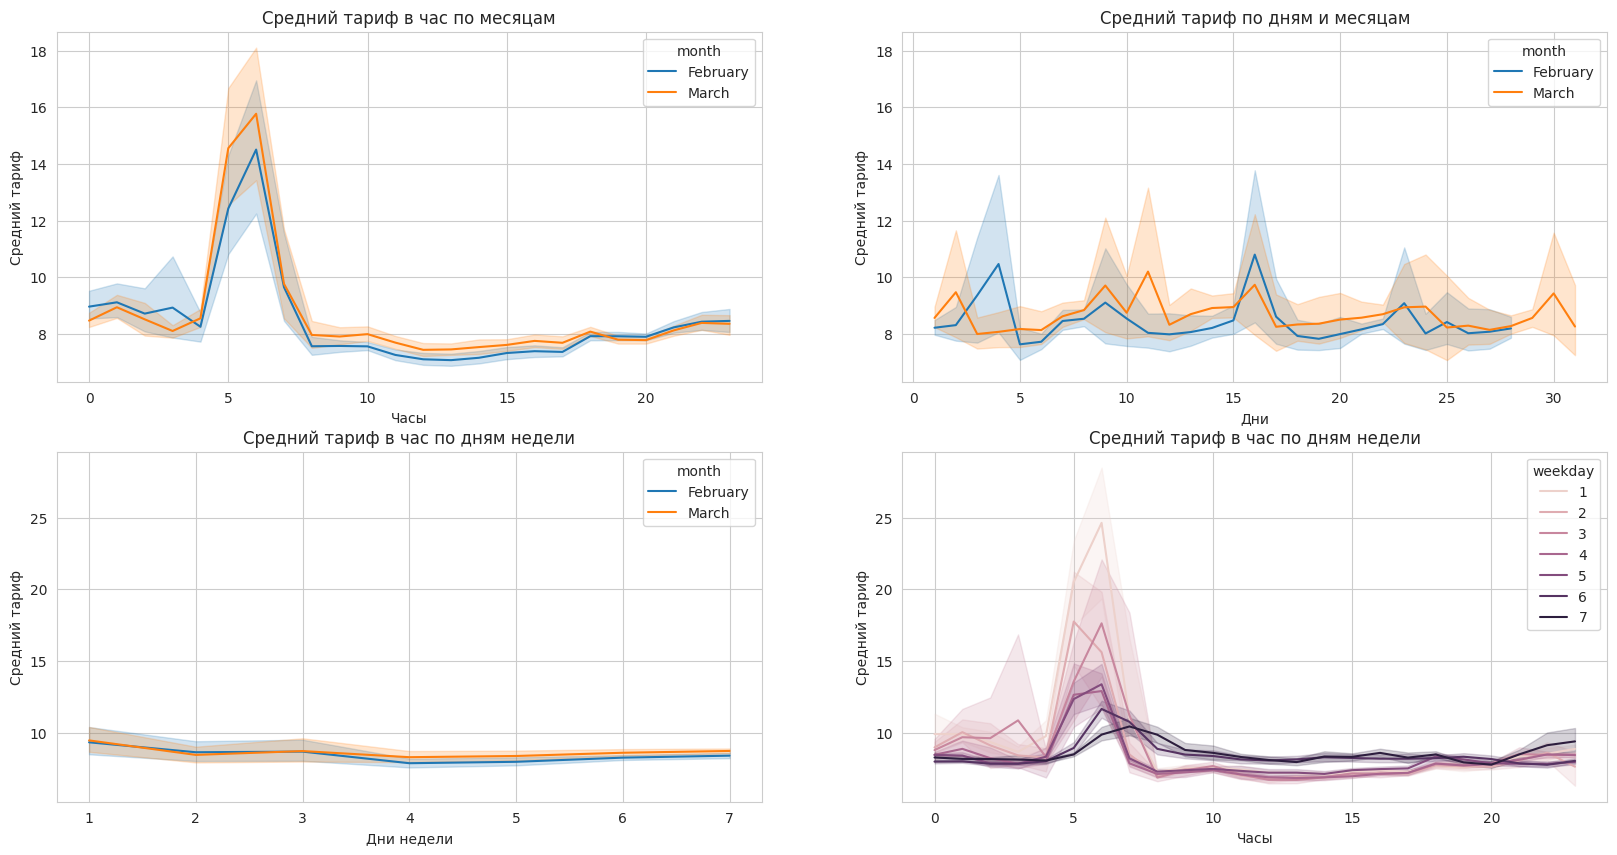

In [ ]:
plt.figure(figsize = (20, 10))
sns.set_style("whitegrid")

ax1=sns.lineplot(data=fare_avg,
                  x="hour",
                  y="fare_avg",
                  hue="month",
                  ax=plt.subplot(2, 2, 1))
ax1.set_title('Средний тариф в час по месяцам')
ax1.set_xlabel('Часы')
ax1.set_ylabel('Средний тариф')

ax2 = sns.lineplot(data=fare_avg,
                  x="day",
                  y="fare_avg",
                  hue="month",
                  ax=plt.subplot(2, 2, 2, sharey=ax1))
ax2.set_title('Средний тариф по дням и месяцам')
ax2.set_xlabel('Дни')
ax2.set_ylabel('Средний тариф')

ax3 = sns.lineplot(data=fare_avg,
                  x="weekday",
                  y="fare_avg",
                  hue="month",
                  ax=plt.subplot(2, 2, 3))
ax3.set_title('Средний тариф в час по дням недели')
ax3.set_xlabel('Дни недели')
ax3.set_ylabel('Средний тариф')

ax4 = sns.lineplot(data=fare_avg,
                  x="hour",
                  y="fare_avg",
                  hue="weekday",
                  ax=plt.subplot(2, 2, 4, sharey=ax3))
ax4.set_title('Средний тариф в час по дням недели')
ax4.set_xlabel('Часы')
ax4.set_ylabel('Средний тариф');

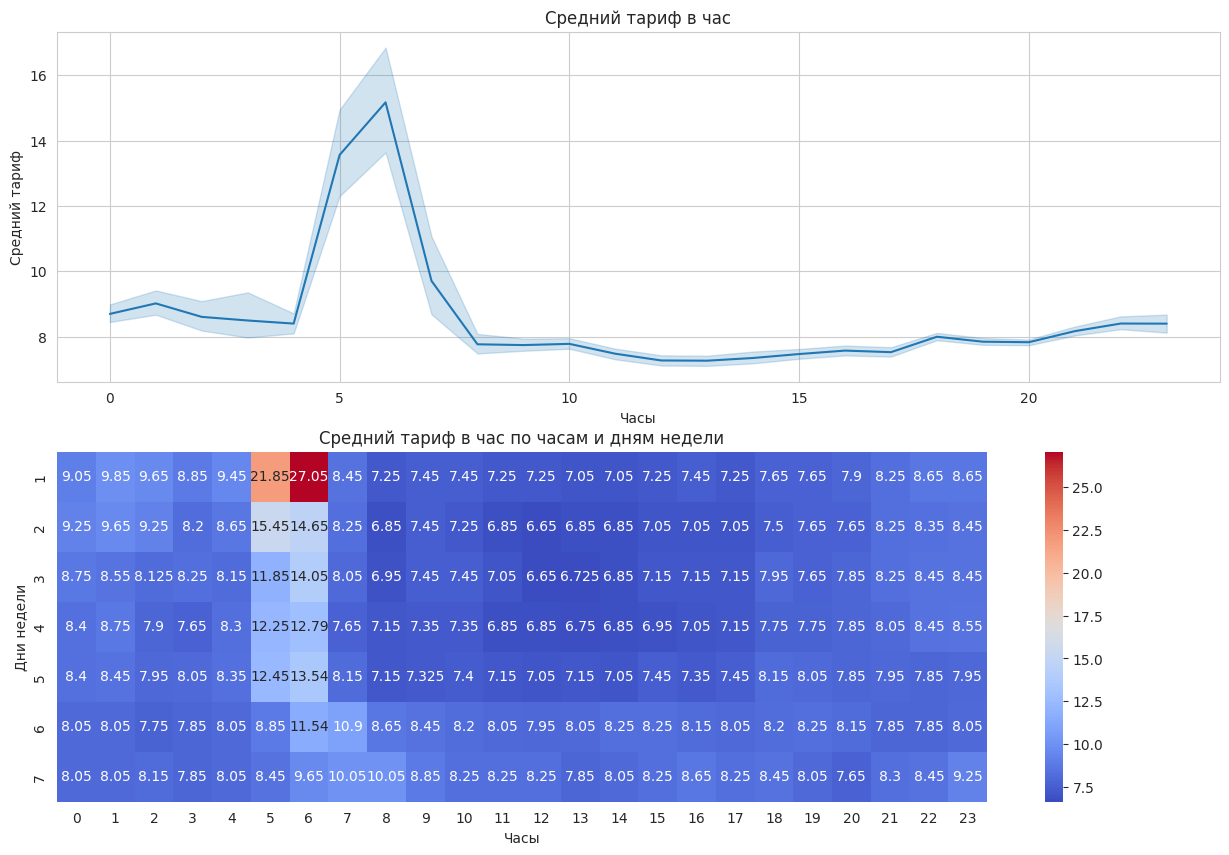

In [ ]:
pivot_table = fare_avg.pivot_table(index='weekday', columns='hour', values='fare_avg', aggfunc='median')

plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")

ax1=sns.lineplot(data=fare_avg,
                  x="hour",
                  y="fare_avg",
                  ax=plt.subplot(2, 1, 1))
ax1.set_title('Средний тариф в час')
ax1.set_xlabel('Часы')
ax1.set_ylabel('Средний тариф')

ax2=sns.heatmap(pivot_table,
                annot=True,
                cmap='coolwarm',
                fmt=".4g",
                  ax=plt.subplot(2, 1, 2))
ax2.set_title('Средний тариф в час по часам и дням недели')
ax2.set_xlabel('Часы')
ax2.set_ylabel('Дни недели')
plt.show()

Вцелом все вполне закономерно - самый высокий тариф утром с 5 до 7 утра так как спрос явно высок. В выходные в это время тариф ниже.

#### Средняя общая выручка и выручка водителя

Для начала посчитаем общую выручку.

In [ ]:
total_revenue = df.groupby('hour_trip_start')['trip_total'].median().reset_index(name='total_revenue')
total_revenue['hour'] = total_revenue['hour_trip_start'].dt.hour
total_revenue['month'] = total_revenue['hour_trip_start'].dt.month_name()
total_revenue['week'] = total_revenue['hour_trip_start'].dt.isocalendar().week
total_revenue['day'] = total_revenue['hour_trip_start'].dt.day
total_revenue['weekday'] = total_revenue['hour_trip_start'].dt.weekday+1
total_revenue

hour_trip_start        total_revenue  hour     month  week  day  \
0    2015-02-01 00:00:00                10.35     0  February     5    1   
1    2015-02-01 01:00:00                 9.65     1  February     5    1   
2    2015-02-01 02:00:00                 9.75     2  February     5    1   
3    2015-02-01 03:00:00                 9.60     3  February     5    1   
4    2015-02-01 04:00:00                 9.65     4  February     5    1   
...                  ...                  ...   ...       ...   ...  ...   
1405 2015-03-31 19:00:00                 8.65    19     March    14   31   
1406 2015-03-31 20:00:00                 9.15    20     March    14   31   
1407 2015-03-31 21:00:00                 8.25    21     March    14   31   
1408 2015-03-31 22:00:00                11.05    22     March    14   31   
1409 2015-03-31 23:00:00                11.00    23     March    14   31   

      weekday  
0           7  
1           7  
2           7  
3           7  
4           7  
...       ...  
1405        2  
1406        2  
1407        2  
1408        2  
1409        2  

[1410 rows x 7 columns]

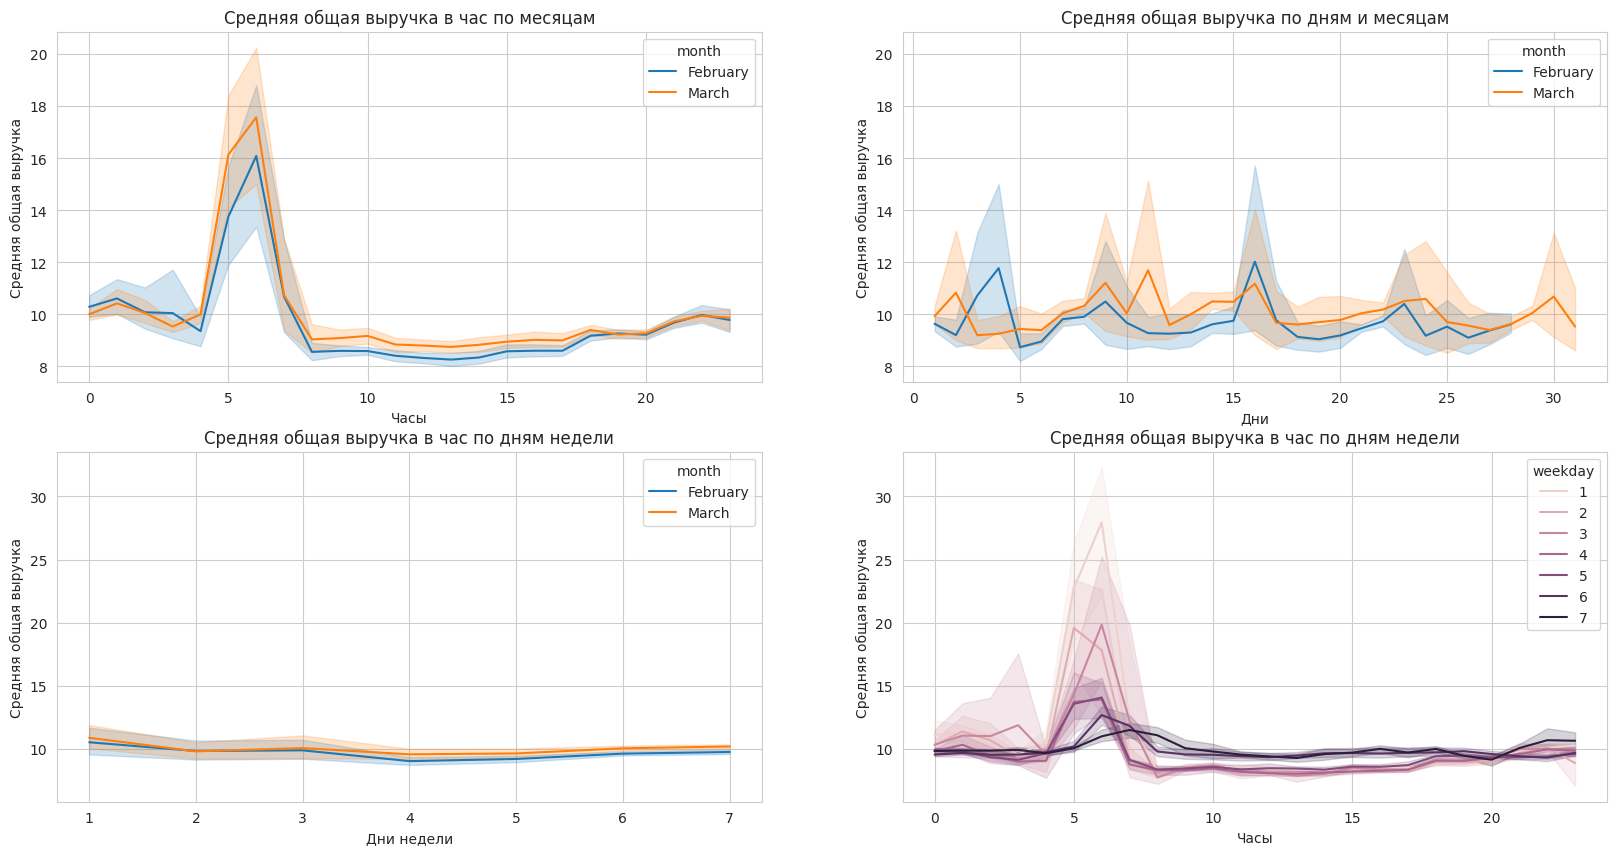

In [ ]:
plt.figure(figsize = (20, 10))
sns.set_style("whitegrid")

ax1=sns.lineplot(data=total_revenue,
                  x="hour",
                  y="total_revenue",
                  hue="month",
                  ax=plt.subplot(2, 2, 1))
ax1.set_title('Средняя общая выручка в час по месяцам')
ax1.set_xlabel('Часы')
ax1.set_ylabel('Средняя общая выручка')

ax2 = sns.lineplot(data=total_revenue,
                  x="day",
                  y="total_revenue",
                  hue="month",
                  ax=plt.subplot(2, 2, 2, sharey=ax1))
ax2.set_title('Средняя общая выручка по дням и месяцам')
ax2.set_xlabel('Дни')
ax2.set_ylabel('Средняя общая выручка')

ax3 = sns.lineplot(data=total_revenue,
                  x="weekday",
                  y="total_revenue",
                  hue="month",
                  ax=plt.subplot(2, 2, 3))
ax3.set_title('Средняя общая выручка в час по дням недели')
ax3.set_xlabel('Дни недели')
ax3.set_ylabel('Средняя общая выручка')

ax4 = sns.lineplot(data=total_revenue,
                  x="hour",
                  y="total_revenue",
                  hue="weekday",
                  ax=plt.subplot(2, 2, 4, sharey=ax3))
ax4.set_title('Средняя общая выручка в час по дням недели')
ax4.set_xlabel('Часы')
ax4.set_ylabel('Средняя общая выручка');

Самая высокая выручка - в понедельник утром. Ближе к выходным утренняя выручка падает. А вот дневная выручка в будни ниже, чем в выходные.

А теперь посчитаем среднюю выручку водителя исходя из того, что водитель получает 60% тарифа за поездку и все чаевые. Для этого для начала посчитаем выручку водителя по каждой поездке.

In [ ]:
df['driver_revenue'] = (df['fare']*0.6) + df['tips']
df.head()

trip_start_timestamp  trip_end_timestamp         trip_seconds  \
0  2015-02-06 06:45:00 2015-02-06 07:00:00               540.00   
1  2015-02-13 20:30:00 2015-02-13 20:45:00               600.00   
2  2015-03-11 23:30:00 2015-03-11 23:45:00               540.00   
3  2015-03-13 22:15:00 2015-03-13 22:15:00               360.00   
4  2015-02-08 03:15:00 2015-02-08 03:30:00               540.00   

            trip_miles  pickup_community_area  dropoff_community_area  \
0                 2.80                  21.00                   15.00   
1                 2.00                   8.00                   28.00   
2                 0.10                  28.00                    8.00   
3                 1.70                  33.00                   32.00   
4                 2.60                   8.00                    8.00   

                  fare                 tips                tolls  \
0                 8.85                 0.00                 0.00   
1                 8.25                 1.00                 0.00   
2                 7.65                 0.00                 0.00   
3                 6.65                 0.00                 0.00   
4                 9.05                 0.00                 0.00   

                extras  ...  payment_type                    company  \
0                 0.00  ...     No Charge        Top Cab Affiliation   
1                 0.00  ...   Credit Card      KOAM Taxi Association   
2                 0.00  ...          Cash  Taxi Affiliation Services   
3                 1.00  ...   Credit Card    Choice Taxi Association   
4                 1.50  ...          Cash  Taxi Affiliation Services   

  pickup_centroid_latitude  pickup_centroid_longitude  \
0                    41.94                     -87.71   
1                    41.89                     -87.62   
2                    41.88                     -87.64   
3                    41.85                     -87.62   
4                    41.89                     -87.63   

   dropoff_centroid_latitude  dropoff_centroid_longitude  taxi_id  \
0                      41.95                      -87.76      250   
1                      41.88                      -87.66     1915   
2                      41.89                      -87.63      110   
3                      41.87                      -87.63     1802   
4                      41.90                      -87.65     1953   

            time_check     hour_trip_start       driver_revenue  
0               900.00 2015-02-06 06:00:00                 5.31  
1               900.00 2015-02-13 20:00:00                 5.95  
2               900.00 2015-03-11 23:00:00                 4.59  
3                 0.00 2015-03-13 22:00:00                 3.99  
4               900.00 2015-02-08 03:00:00                 5.43  

[5 rows x 21 columns]

In [ ]:
driver_revenue = df.groupby('hour_trip_start')['driver_revenue', 'fare'].median().reset_index()
driver_revenue['hour'] = driver_revenue['hour_trip_start'].dt.hour
driver_revenue['month'] = driver_revenue['hour_trip_start'].dt.month_name()
driver_revenue['week'] = driver_revenue['hour_trip_start'].dt.isocalendar().week
driver_revenue['day'] = driver_revenue['hour_trip_start'].dt.day
driver_revenue['weekday'] = driver_revenue['hour_trip_start'].dt.weekday+1
driver_revenue

<ipython-input-99-ddd7c915d8ca>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  driver_revenue = df.groupby('hour_trip_start')['driver_revenue', 'fare'].median().reset_index()


hour_trip_start       driver_revenue                 fare  hour  \
0    2015-02-01 00:00:00                 5.61                 9.35     0   
1    2015-02-01 01:00:00                 5.99                 7.85     1   
2    2015-02-01 02:00:00                 5.86                 8.05     2   
3    2015-02-01 03:00:00                 5.79                 7.85     3   
4    2015-02-01 04:00:00                 5.99                 8.05     4   
...                  ...                  ...                  ...   ...   
1405 2015-03-31 19:00:00                 5.39                 7.45    19   
1406 2015-03-31 20:00:00                 5.83                 7.85    20   
1407 2015-03-31 21:00:00                 4.95                 6.45    21   
1408 2015-03-31 22:00:00                 6.63                11.05    22   
1409 2015-03-31 23:00:00                 6.67                 9.55    23   

         month  week  day  weekday  
0     February     5    1        7  
1     February     5    1        7  
2     February     5    1        7  
3     February     5    1        7  
4     February     5    1        7  
...        ...   ...  ...      ...  
1405     March    14   31        2  
1406     March    14   31        2  
1407     March    14   31        2  
1408     March    14   31        2  
1409     March    14   31        2  

[1410 rows x 8 columns]

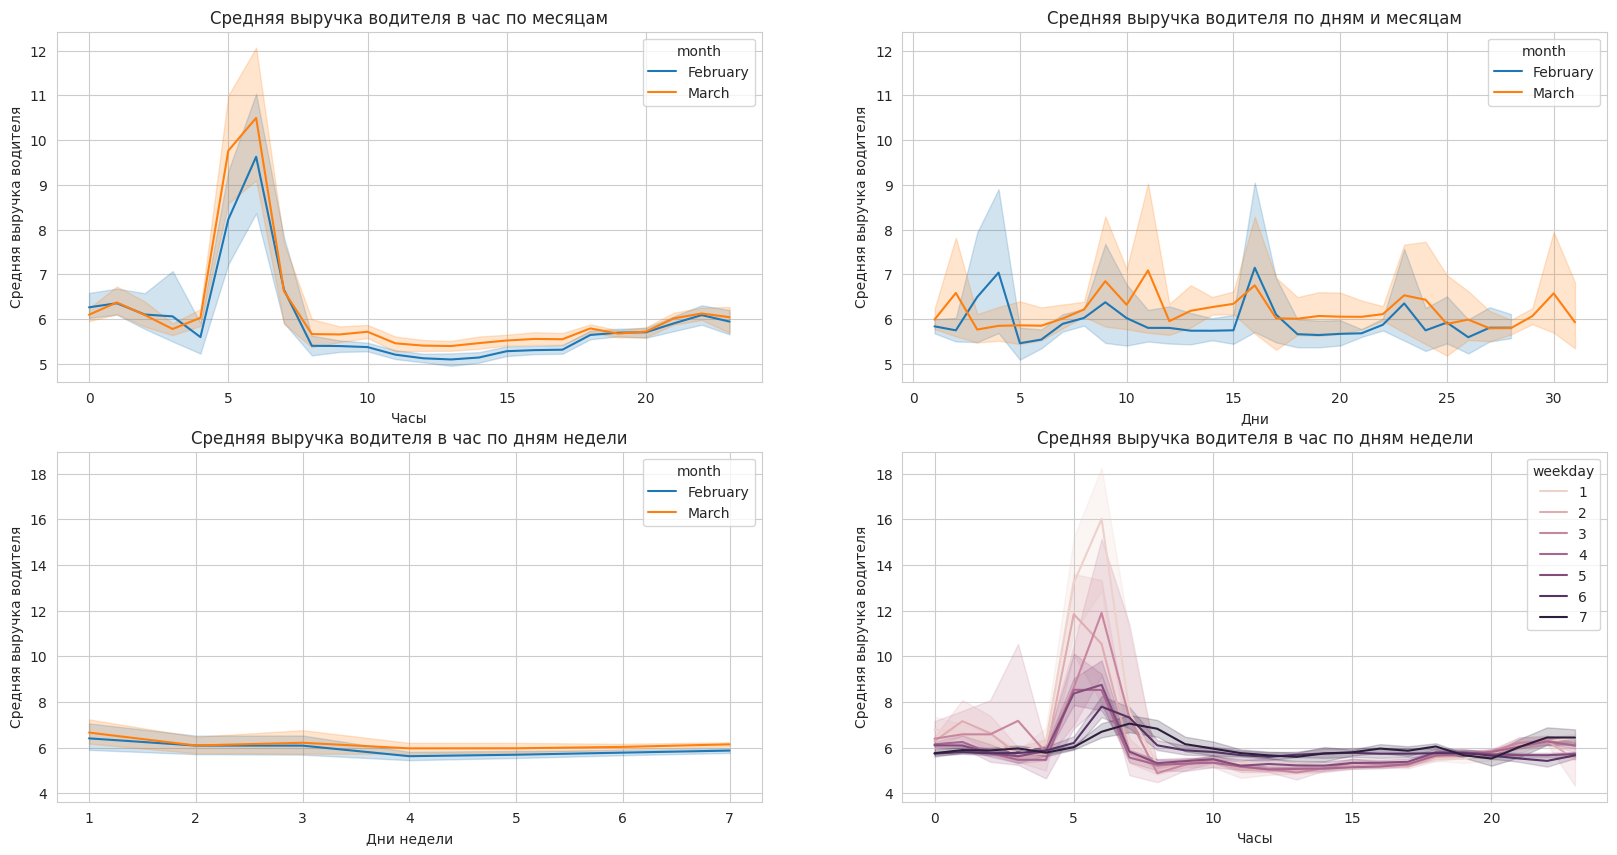

In [ ]:
plt.figure(figsize = (20, 10))
sns.set_style("whitegrid")

ax1=sns.lineplot(data=driver_revenue,
                  x="hour",
                  y="driver_revenue",
                  hue="month",
                  ax=plt.subplot(2, 2, 1))
ax1.set_title('Средняя выручка водителя в час по месяцам')
ax1.set_xlabel('Часы')
ax1.set_ylabel('Средняя выручка водителя')

ax2 = sns.lineplot(data=driver_revenue,
                  x="day",
                  y="driver_revenue",
                  hue="month",
                  ax=plt.subplot(2, 2, 2, sharey=ax1))
ax2.set_title('Средняя выручка водителя по дням и месяцам')
ax2.set_xlabel('Дни')
ax2.set_ylabel('Средняя выручка водителя')

ax3 = sns.lineplot(data=driver_revenue,
                  x="weekday",
                  y="driver_revenue",
                  hue="month",
                  ax=plt.subplot(2, 2, 3))
ax3.set_title('Средняя выручка водителя в час по дням недели')
ax3.set_xlabel('Дни недели')
ax3.set_ylabel('Средняя выручка водителя')

ax4 = sns.lineplot(data=driver_revenue,
                  x="hour",
                  y="driver_revenue",
                  hue="weekday",
                  ax=plt.subplot(2, 2, 4, sharey=ax3))
ax4.set_title('Средняя выручка водителя в час по дням недели')
ax4.set_xlabel('Часы')
ax4.set_ylabel('Средняя выручка водителя');

Сердняя выручка водителя в час за одну поездку аналогична общей выручке. В будни днем выручка меньше, чем в выходные.

### Выручка водителей
Определим периоды когда водители получают
- выручку исходя из тарифа ниже среднего
- меньше чаевых

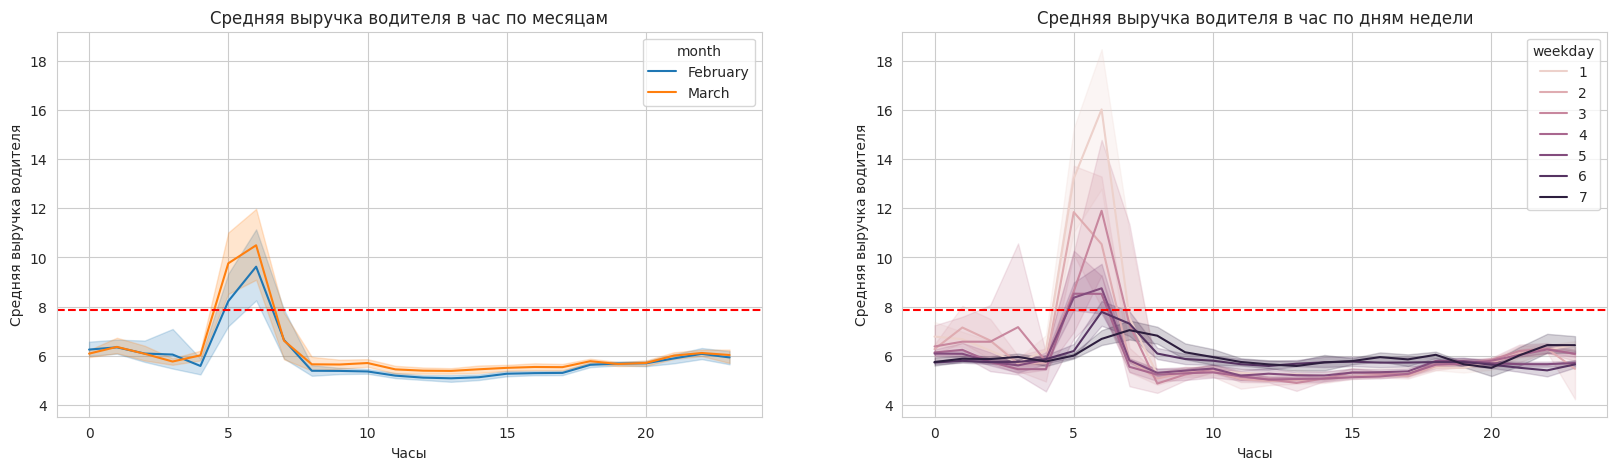

In [ ]:
plt.figure(figsize = (20, 5))
sns.set_style("whitegrid")

ax1=sns.lineplot(data=driver_revenue,
                  x="hour",
                  y="driver_revenue",
                  hue="month",
                  ax=plt.subplot(1, 2, 1))
plt.axhline(y=df['fare'].median(), color='red', linestyle='--', label='Средний тариф')
ax1.set_title('Средняя выручка водителя в час по месяцам')
ax1.set_xlabel('Часы')
ax1.set_ylabel('Средняя выручка водителя')

ax2 = sns.lineplot(data=driver_revenue,
                  x="hour",
                  y="driver_revenue",
                  hue="weekday",
                  ax=plt.subplot(1, 2, 2, sharey=ax1))
plt.axhline(y=df['fare'].median(), color='red', linestyle='--', label='Средний тариф')
ax2.set_title('Средняя выручка водителя в час по дням недели')
ax2.set_xlabel('Часы')
ax2.set_ylabel('Средняя выручка водителя');

In [ ]:
df['fare'].median()

7.85

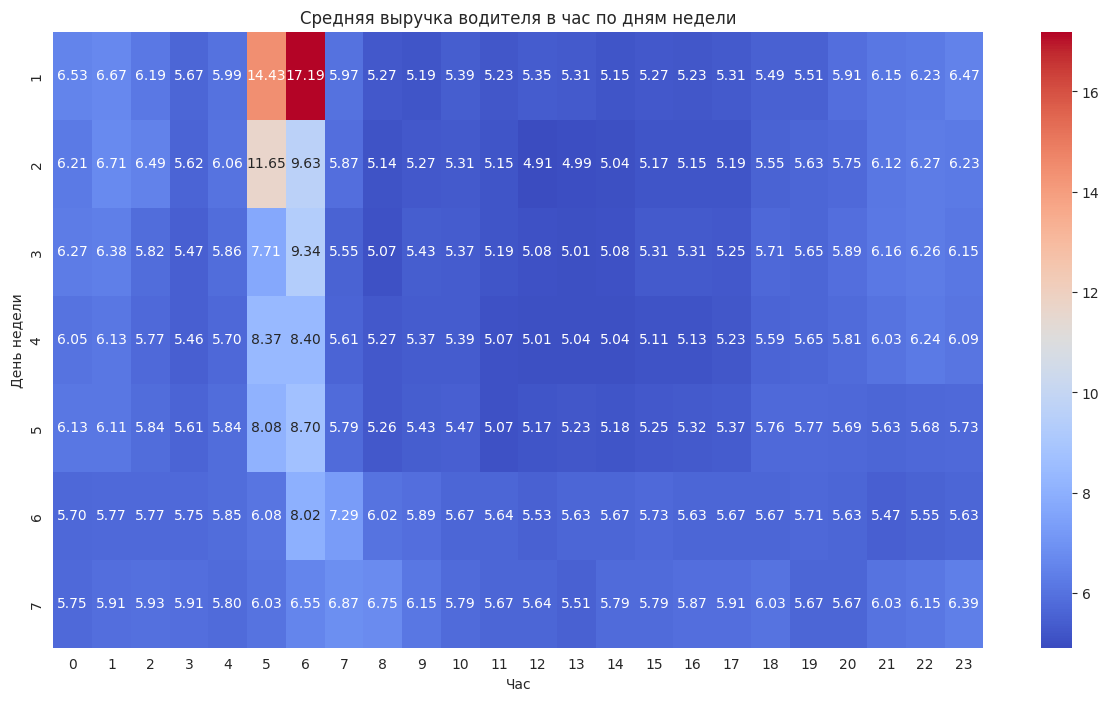

In [ ]:
pivot_table = driver_revenue.pivot_table(index='weekday', columns='hour', values='driver_revenue', aggfunc='median')
plt.figure(figsize=(15, 8))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Средняя выручка водителя в час по дням недели')
plt.xlabel('Час')
plt.ylabel('День недели')
plt.show()

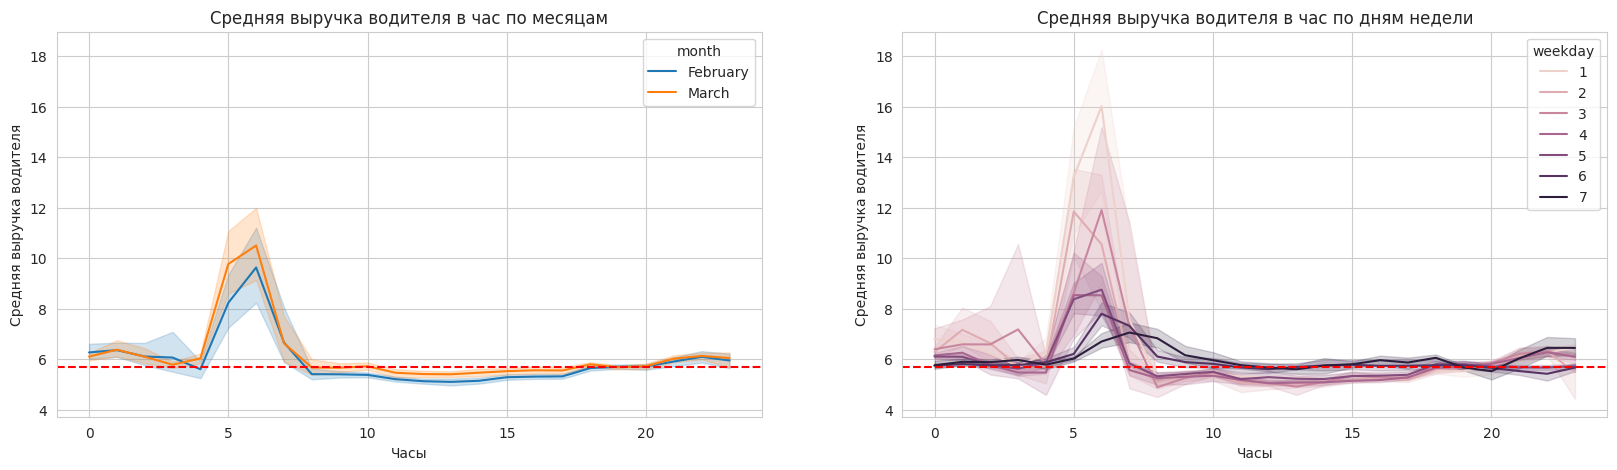

In [ ]:
plt.figure(figsize = (20, 5))
sns.set_style("whitegrid")

ax1=sns.lineplot(data=driver_revenue,
                  x="hour",
                  y="driver_revenue",
                  hue="month",
                  ax=plt.subplot(1, 2, 1))
plt.axhline(y=driver_revenue['driver_revenue'].median(), color='red', linestyle='--', label='Средний тариф')
ax1.set_title('Средняя выручка водителя в час по месяцам')
ax1.set_xlabel('Часы')
ax1.set_ylabel('Средняя выручка водителя')

ax2 = sns.lineplot(data=driver_revenue,
                  x="hour",
                  y="driver_revenue",
                  hue="weekday",
                  ax=plt.subplot(1, 2, 2, sharey=ax1))
plt.axhline(y=driver_revenue['driver_revenue'].median(), color='red', linestyle='--', label='Средний тариф')
ax2.set_title('Средняя выручка водителя в час по дням недели')
ax2.set_xlabel('Часы')
ax2.set_ylabel('Средняя выручка водителя');

In [ ]:
tips_avg = df.groupby('hour_trip_start')['tips'].median().reset_index(name='tips_avg')
tips_avg['hour'] = tips_avg['hour_trip_start'].dt.hour
tips_avg['month'] = tips_avg['hour_trip_start'].dt.month_name()
tips_avg['weekday'] = tips_avg['hour_trip_start'].dt.weekday+1
tips_avg

hour_trip_start             tips_avg  hour     month  weekday
0    2015-02-01 00:00:00                 0.00     0  February        7
1    2015-02-01 01:00:00                 0.00     1  February        7
2    2015-02-01 02:00:00                 0.00     2  February        7
3    2015-02-01 03:00:00                 0.00     3  February        7
4    2015-02-01 04:00:00                 0.00     4  February        7
...                  ...                  ...   ...       ...      ...
1405 2015-03-31 19:00:00                 0.00    19     March        2
1406 2015-03-31 20:00:00                 0.00    20     March        2
1407 2015-03-31 21:00:00                 0.00    21     March        2
1408 2015-03-31 22:00:00                 0.00    22     March        2
1409 2015-03-31 23:00:00                 1.94    23     March        2

[1410 rows x 5 columns]

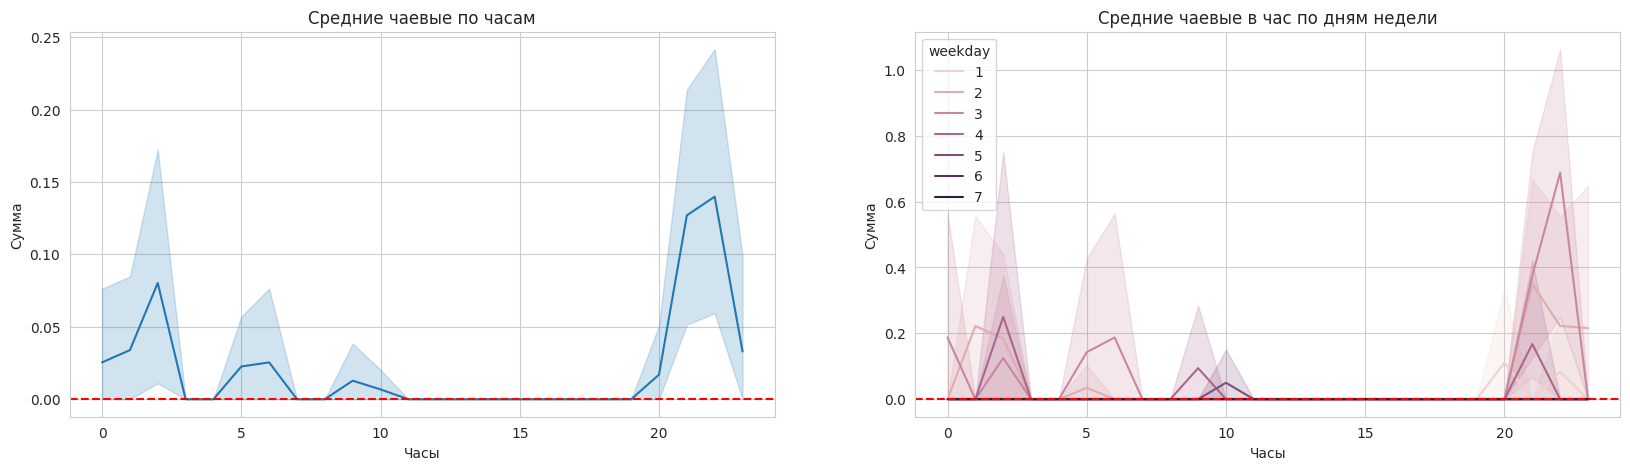

In [ ]:
plt.figure(figsize = (20, 5))
sns.set_style("whitegrid")

ax1=sns.lineplot(data=tips_avg,
                  x="hour",
                  y="tips_avg",
                  ax=plt.subplot(1, 2, 1))
plt.axhline(y=df['tips'].median(), color='red', linestyle='--')
ax1.set_title('Средние чаевые по часам')
ax1.set_xlabel('Часы')
ax1.set_ylabel('Сумма')

ax2 = sns.lineplot(data=tips_avg,
                  x="hour",
                  y="tips_avg",
                  hue="weekday",
                  ax=plt.subplot(1, 2, 2))
plt.axhline(y=df['tips'].median(), color='red', linestyle='--')
ax2.set_title('Средние чаевые в час по дням недели')
ax2.set_xlabel('Часы')
ax2.set_ylabel('Сумма');

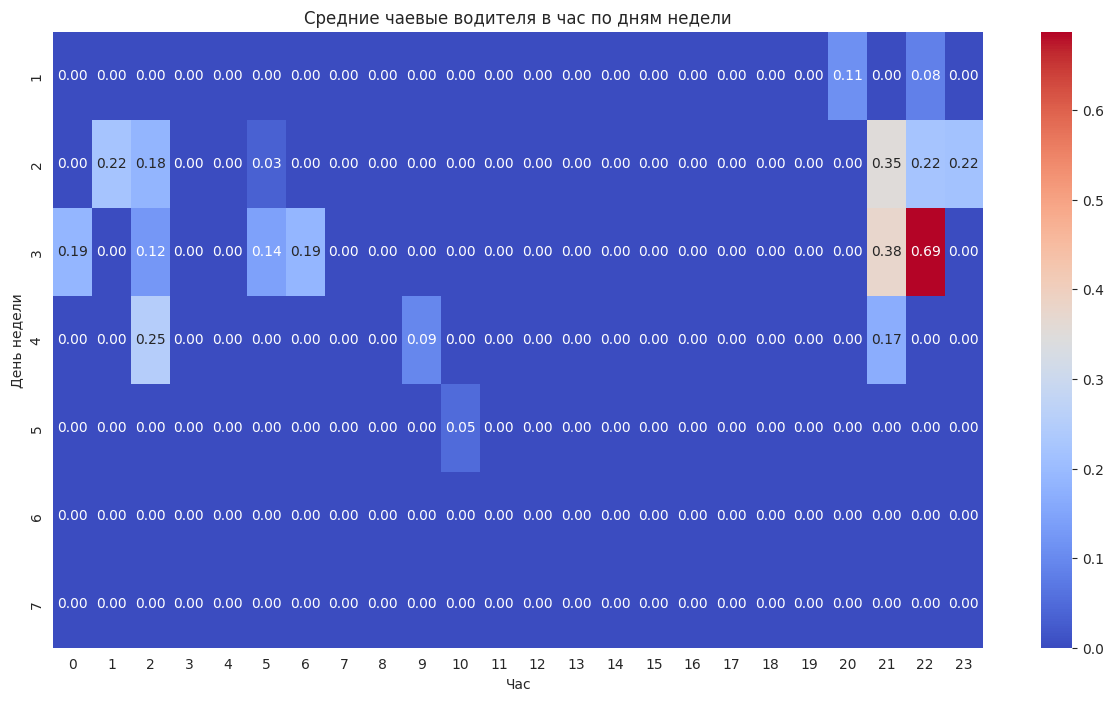

In [ ]:
pivot_table = tips_avg.pivot_table(index='weekday', columns='hour', values='tips_avg', aggfunc='mean')
plt.figure(figsize=(15, 8))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Средние чаевые водителя в час по дням недели')
plt.xlabel('Час')
plt.ylabel('День недели')
plt.show()

In [ ]:
print('Средние чаевые =', df['tips'].median())

Средние чаевые = 0.0


Водители получают выручку исходя из тарифа выше среднего только с 5 до 7 утра будни. В остальные периоды они получают получают выручку меньше среднего тарифа.

Если же смотреть по средней выручке водителя, то провалы в выручке в основном в будни с 7 утра до 6 вечера, то есть весь день.

А вот по чаевым обратная ситуация. Большая часть водителей вообще не получают чаевые и медиана равна 0. Однако выявлена интересная закономерность - больше всего чаевых получают водители вечером в будни и не получают чаевые в выходные.

### Периоды дефицита предложения услуг такси

In [ ]:
df_cover['hour'] = df_cover['hour_trip_start'].dt.hour
df_cover['month'] = df_cover['hour_trip_start'].dt.month_name()
df_cover['weekday'] = df_cover['hour_trip_start'].dt.weekday+1

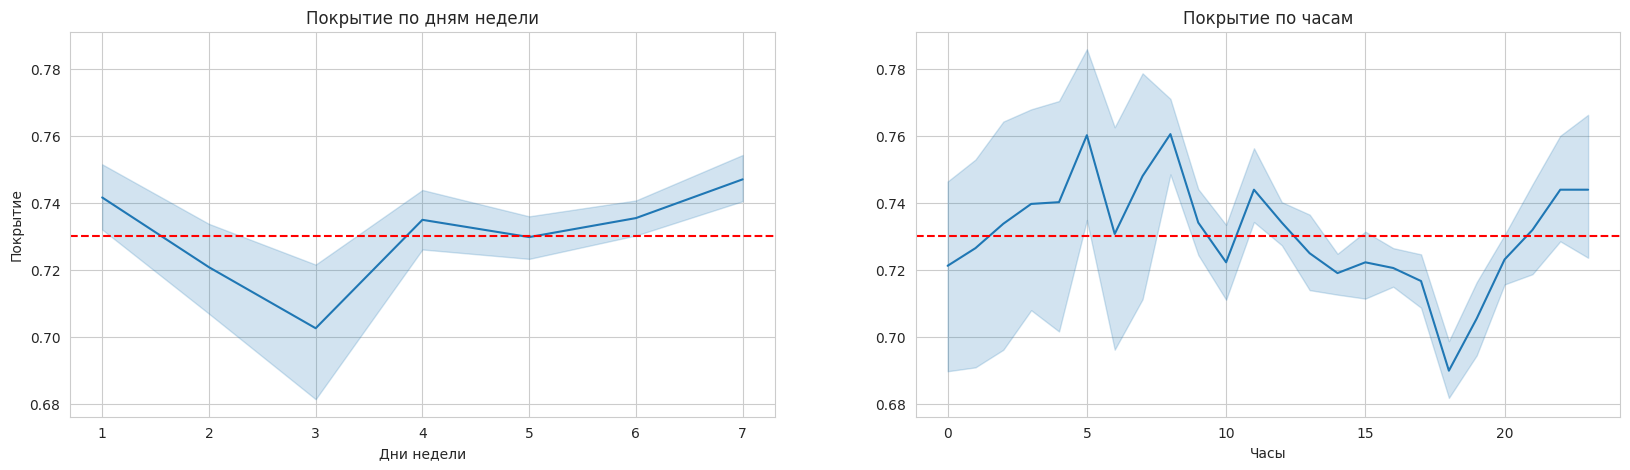

In [ ]:
plt.figure(figsize = (20, 5))
sns.set_style("whitegrid")

ax1 = sns.lineplot(data=df_cover,
                  x="weekday",
                  y="estimated_coverage",
                  ax=plt.subplot(1, 2, 1))
plt.axhline(y=df_cover['estimated_coverage'].median(), color='red', linestyle='--')
ax1.set_title('Покрытие по дням недели')
ax1.set_xlabel('Дни недели')
ax1.set_ylabel('Покрытие')

ax2 = sns.lineplot(data=df_cover,
                  x="hour",
                  y="estimated_coverage",
                  ax=plt.subplot(1, 2, 2, sharey=ax1))
plt.axhline(y=df_cover['estimated_coverage'].median(), color='red', linestyle='--')
ax2.set_title('Покрытие по часам')
ax2.set_xlabel('Часы')
ax2.set_ylabel('');

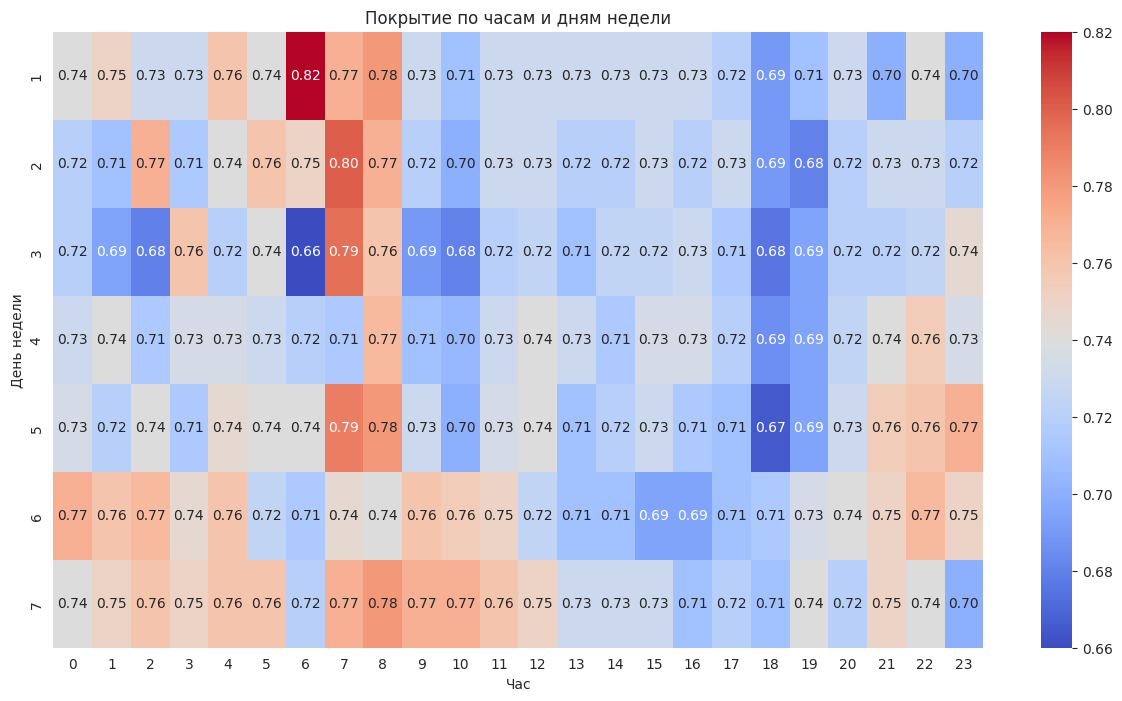

In [ ]:
pivot_table = df_cover.pivot_table(index='weekday', columns='hour', values='estimated_coverage', aggfunc='median')
plt.figure(figsize=(15, 8))

sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Покрытие по часам и дням недели')
plt.xlabel('Час')
plt.ylabel('День недели')
plt.show()

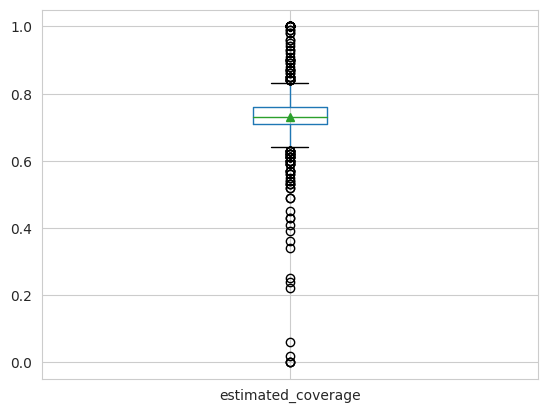

In [ ]:
df_cover.boxplot('estimated_coverage', showmeans=True, grid=True)
plt.show()

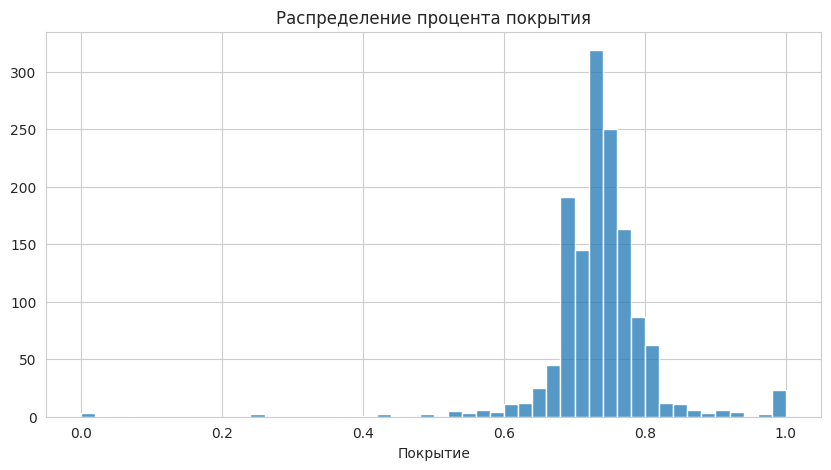

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df_cover, x='estimated_coverage', bins=50)
plt.title('Распределение процента покрытия')
plt.xlabel('Покрытие')
plt.ylabel('');

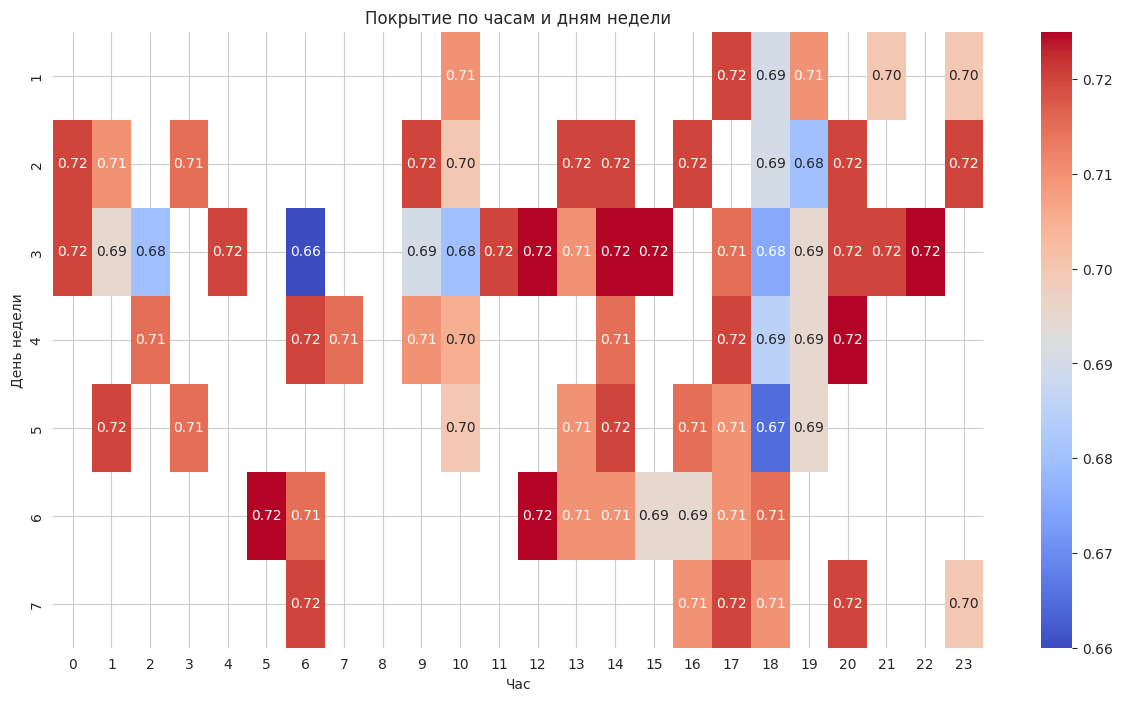

In [ ]:
pivot_table = df_cover.pivot_table(index='weekday', columns='hour', values='estimated_coverage', aggfunc='median')
plt.figure(figsize=(15, 8))
cutoff_value = df_cover['estimated_coverage'].median()
mask = pivot_table >= cutoff_value
sns.heatmap(pivot_table, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Покрытие по часам и дням недели')
plt.xlabel('Час')
plt.ylabel('День недели')
plt.show()

Будем считать нормальным покрытием медианное значение данных по покрытию (это 73%), так как она представляет представляет центральную точку, отражающую более типичное значение процента покрытия. 100% покрытия добиться все равно очень сложно.

Итак, мы видим, что основная нехватка машин у нас по средам, а также в будни днем часов с 9. Как раз в это время у нас водители получают меньше всего выручки.

#### Оптимальное число машин на линии для обеспечения нормального показателя покрытия

Объеденим таблицы с покрытие и средними значениями по количеству машин и поездок.

In [ ]:
df_merge = df_cover.merge(car_per_hour, on='hour_trip_start', how='inner')

In [ ]:
df_merge = df_merge.merge(trip_per_hour, on='hour_trip_start', how='inner')

In [ ]:
df_merge = df_merge.drop(columns =['hour_x', 'month_x', 'weekday_x', 'hour_y', 'week_x', 'day_x', 'month_y', 'weekday_y', 'week_y', 'day_y'])

In [ ]:
df_merge

hour_trip_start   estimated_coverage  car_count  trip_count  hour  \
0    2015-02-01 00:00:00                 0.36          6          10     0   
1    2015-02-01 01:00:00                 0.61          7          15     1   
2    2015-02-01 02:00:00                 0.74        840        1196     2   
3    2015-02-01 03:00:00                 0.73        976        2003     3   
4    2015-02-01 04:00:00                 0.79        452         591     4   
...                  ...                  ...        ...         ...   ...   
1404 2015-03-31 19:00:00                 0.70        794        1014    19   
1405 2015-03-31 20:00:00                 0.72        847        1131    20   
1406 2015-03-31 21:00:00                 0.82          6          15    21   
1407 2015-03-31 22:00:00                 0.45          8          11    22   
1408 2015-03-31 23:00:00                 0.65         18          18    23   

         month  weekday  
0     February        7  
1     February        7  
2     February        7  
3     February        7  
4     February        7  
...        ...      ...  
1404     March        2  
1405     March        2  
1406     March        2  
1407     March        2  
1408     March        2  

[1409 rows x 7 columns]

In [ ]:
df_merge['estimated_coverage'] = df_merge['estimated_coverage'].fillna(0)

Посчитаем сколько в среднем одна машина совершала поездок.

In [ ]:
df_merge['trip_per_car'] = df_merge['trip_count'] / df_merge['car_count']
df_merge

hour_trip_start   estimated_coverage  car_count  trip_count  hour  \
0    2015-02-01 00:00:00                 0.36          6          10     0   
1    2015-02-01 01:00:00                 0.61          7          15     1   
2    2015-02-01 02:00:00                 0.74        840        1196     2   
3    2015-02-01 03:00:00                 0.73        976        2003     3   
4    2015-02-01 04:00:00                 0.79        452         591     4   
...                  ...                  ...        ...         ...   ...   
1404 2015-03-31 19:00:00                 0.70        794        1014    19   
1405 2015-03-31 20:00:00                 0.72        847        1131    20   
1406 2015-03-31 21:00:00                 0.82          6          15    21   
1407 2015-03-31 22:00:00                 0.45          8          11    22   
1408 2015-03-31 23:00:00                 0.65         18          18    23   

         month  weekday         trip_per_car  
0     February        7                 1.67  
1     February        7                 2.14  
2     February        7                 1.42  
3     February        7                 2.05  
4     February        7                 1.31  
...        ...      ...                  ...  
1404     March        2                 1.28  
1405     March        2                 1.34  
1406     March        2                 2.50  
1407     March        2                 1.38  
1408     March        2                 1.00  

[1409 rows x 8 columns]

In [ ]:
df_merge[['car_count', 'trip_count', 'hour', 'weekday']] = df_merge[['car_count', 'trip_count', 'hour', 'weekday']].astype (int)

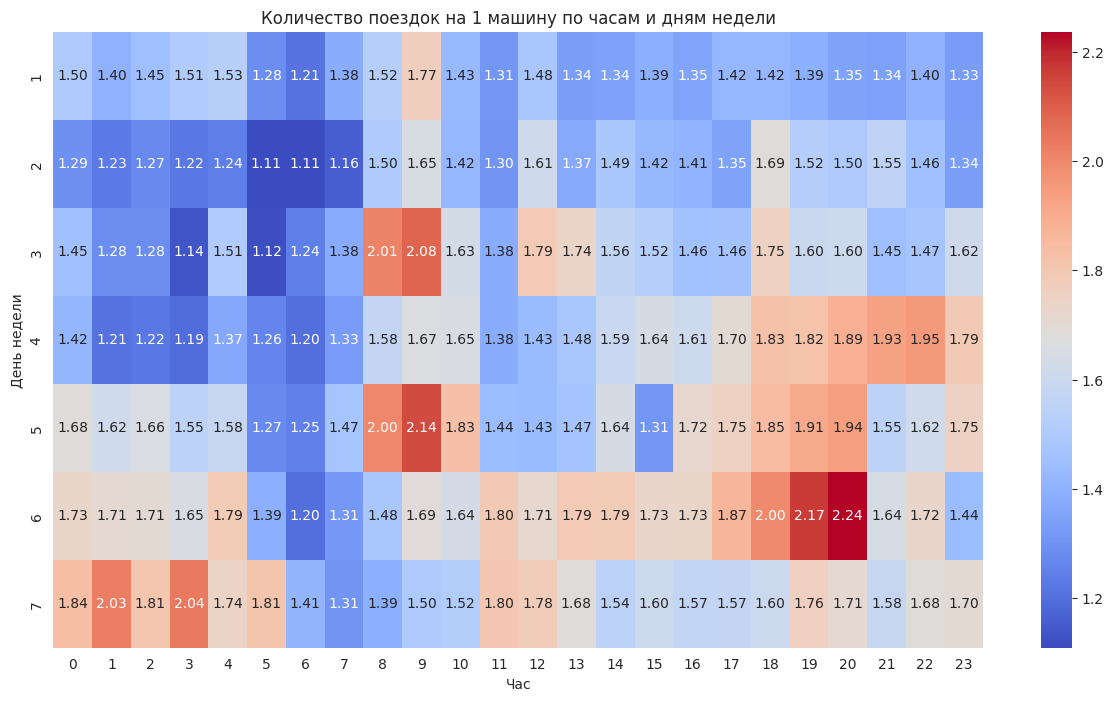

In [ ]:
pivot_table = df_merge.pivot_table(index='weekday', columns='hour', values='trip_per_car', aggfunc='median')
plt.figure(figsize=(15, 8))

sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Количество поездок на 1 машину по часам и дням недели')
plt.xlabel('Час')
plt.ylabel('День недели')
plt.show()

In [ ]:
df_opt = df_merge.query('estimated_coverage < @cutoff_value').copy()
df_opt

hour_trip_start   estimated_coverage  car_count  trip_count  hour  \
0    2015-02-01 00:00:00                 0.36          6          10     0   
1    2015-02-01 01:00:00                 0.61          7          15     1   
11   2015-02-01 11:00:00                 0.72        419         621    11   
16   2015-02-01 16:00:00                 0.69        340         456    16   
18   2015-02-01 18:00:00                 0.71        360         576    18   
...                  ...                  ...        ...         ...   ...   
1403 2015-03-31 18:00:00                 0.69       1137        1786    18   
1404 2015-03-31 19:00:00                 0.70        794        1014    19   
1405 2015-03-31 20:00:00                 0.72        847        1131    20   
1407 2015-03-31 22:00:00                 0.45          8          11    22   
1408 2015-03-31 23:00:00                 0.65         18          18    23   

         month  weekday         trip_per_car  
0     February        7                 1.67  
1     February        7                 2.14  
11    February        7                 1.48  
16    February        7                 1.34  
18    February        7                 1.60  
...        ...      ...                  ...  
1403     March        2                 1.57  
1404     March        2                 1.28  
1405     March        2                 1.34  
1407     March        2                 1.38  
1408     March        2                 1.00  

[625 rows x 8 columns]

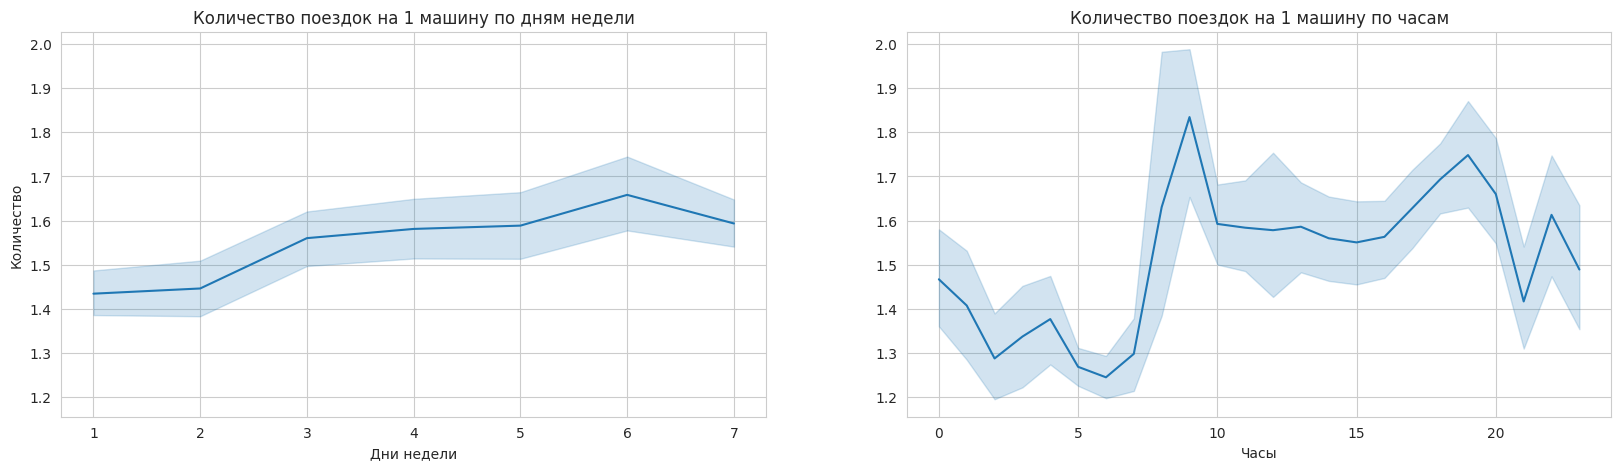

In [ ]:
plt.figure(figsize = (20, 5))
sns.set_style("whitegrid")

ax1 = sns.lineplot(data=df_opt,
                  x="weekday",
                  y="trip_per_car",
                  ax=plt.subplot(1, 2, 1))
ax1.set_title('Количество поездок на 1 машину по дням недели')
ax1.set_xlabel('Дни недели')
ax1.set_ylabel('Количество')

ax2 = sns.lineplot(data=df_opt,
                  x="hour",
                  y="trip_per_car",
                  ax=plt.subplot(1, 2, 2, sharey=ax1))
ax2.set_title('Количество поездок на 1 машину по часам')
ax2.set_xlabel('Часы')
ax2.set_ylabel('');

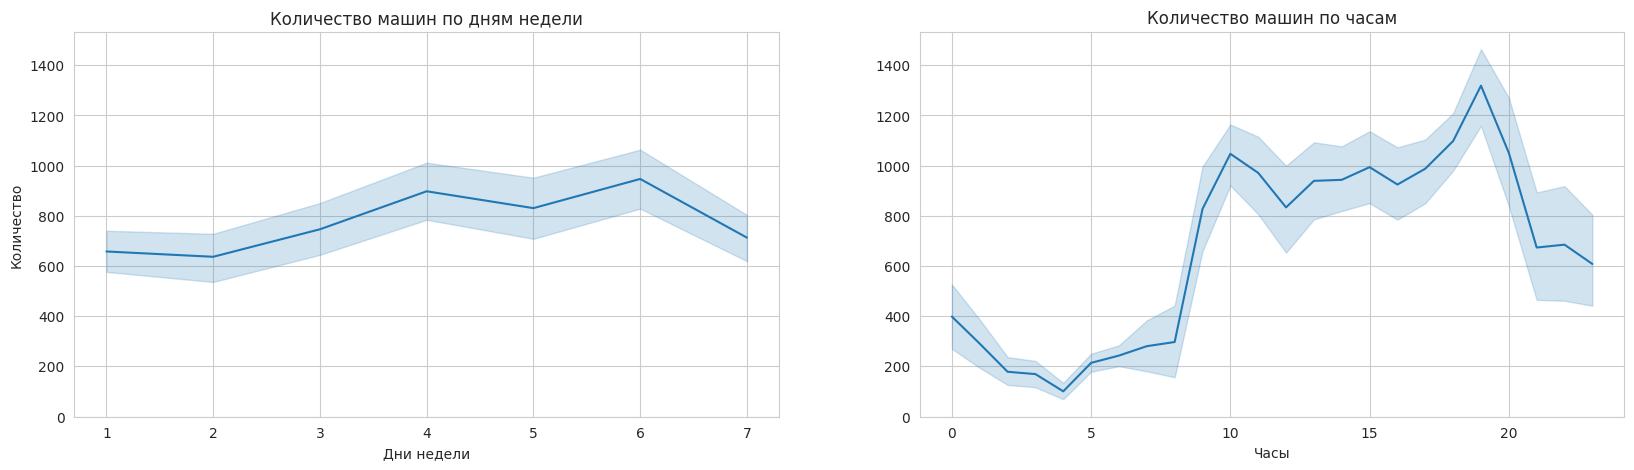

In [ ]:
plt.figure(figsize = (20, 5))
sns.set_style("whitegrid")

ax1 = sns.lineplot(data=df_opt,
                  x="weekday",
                  y="car_count",
                  ax=plt.subplot(1, 2, 1))
ax1.set_title('Количество машин по дням недели')
ax1.set_xlabel('Дни недели')
ax1.set_ylabel('Количество')

ax2 = sns.lineplot(data=df_opt,
                  x="hour",
                  y="car_count",
                  ax=plt.subplot(1, 2, 2, sharey=ax1))
ax2.set_title('Количество машин по часам')
ax2.set_xlabel('Часы')
ax2.set_ylabel('');

In [ ]:
df_opt['car_opt'] = (df_opt['car_count']*0.73 / df_opt['estimated_coverage']).round()
df_opt['car_plus'] = (df_opt['car_opt'] - df_opt['car_count'])
df_opt

hour_trip_start   estimated_coverage  car_count  trip_count  hour  \
0    2015-02-01 00:00:00                 0.36          6          10     0   
1    2015-02-01 01:00:00                 0.61          7          15     1   
11   2015-02-01 11:00:00                 0.72        419         621    11   
16   2015-02-01 16:00:00                 0.69        340         456    16   
18   2015-02-01 18:00:00                 0.71        360         576    18   
...                  ...                  ...        ...         ...   ...   
1403 2015-03-31 18:00:00                 0.69       1137        1786    18   
1404 2015-03-31 19:00:00                 0.70        794        1014    19   
1405 2015-03-31 20:00:00                 0.72        847        1131    20   
1407 2015-03-31 22:00:00                 0.45          8          11    22   
1408 2015-03-31 23:00:00                 0.65         18          18    23   

         month  weekday         trip_per_car              car_opt  \
0     February        7                 1.67                12.00   
1     February        7                 2.14                 8.00   
11    February        7                 1.48               425.00   
16    February        7                 1.34               360.00   
18    February        7                 1.60               370.00   
...        ...      ...                  ...                  ...   
1403     March        2                 1.57             1,203.00   
1404     March        2                 1.28               828.00   
1405     March        2                 1.34               859.00   
1407     March        2                 1.38                13.00   
1408     March        2                 1.00                20.00   

                 car_plus  
0                    6.00  
1                    1.00  
11                   6.00  
16                  20.00  
18                  10.00  
...                   ...  
1403                66.00  
1404                34.00  
1405                12.00  
1407                 5.00  
1408                 2.00  

[625 rows x 10 columns]

In [ ]:
df_opt_pivot = df_opt.groupby(['weekday','hour'])[['car_count', 'car_opt', 'car_plus']].median().astype(int).reset_index()
df_opt_pivot[['car_count', 'car_opt', 'car_plus']] = df_opt_pivot[['car_count', 'car_opt', 'car_plus']].fillna(0)
df_opt_pivot

weekday  hour  car_count  car_opt  car_plus
0          1     0        436      455        19
1          1     1        396      404         8
2          1     2        218      236         9
3          1     3        126      131         5
4          1     4        150      168        18
..       ...   ...        ...      ...       ...
145        7    19       1173     1223        50
146        7    20       1066     1096        17
147        7    21        989     1003        14
148        7    22        311      322        11
149        7    23        576      601        32

[150 rows x 5 columns]

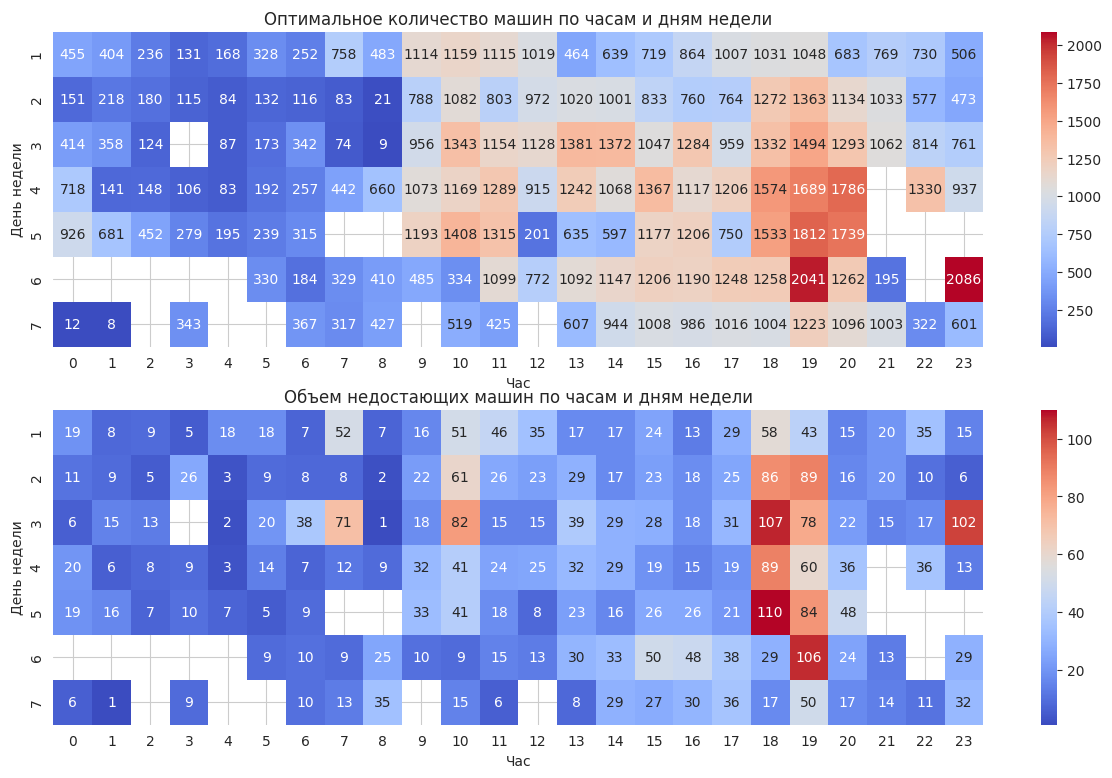

In [ ]:
pivot_table1 = df_opt_pivot.pivot_table(index='weekday', columns='hour', values='car_opt')
pivot_table2 = df_opt_pivot.pivot_table(index='weekday', columns='hour', values='car_plus')

plt.figure(figsize=(15, 9))

ax1 = sns.heatmap(pivot_table1, cmap='coolwarm', annot=True, fmt=".4g", ax=plt.subplot(2, 1, 1))
ax1.set_title('Оптимальное количество машин по часам и дням недели')
ax1.set_xlabel('Час')
ax1.set_ylabel('День недели')


ax2 = sns.heatmap(pivot_table2, cmap='coolwarm', annot=True, fmt=".4g", ax=plt.subplot(2, 1, 2))
ax2.set_title('Объем недостающих машин по часам и дням недели')
ax2.set_xlabel('Час')
ax2.set_ylabel('День недели');

Интересно, но больше всего не хватает машин начиная со вторника по пятницу в период с 6 до 8 вечера, а также в среду в 7 и 10 утра и в 11 вечера и субботу в 7 вечера.

Думаю, необходимо стимулировать выходить водителей на линию в эти же периоды так как именно тогда больше всего не хватает машин.

### Объём недополученной общей выручки из-за низкого предложения

Добавим в полученную ранее таблицу с периодами, когда покрытие ниже необходимого данные по общей выручке и выручке водителя.

In [ ]:
df_revenue = df.groupby('hour_trip_start')[['trip_total','driver_revenue']].sum().reset_index()
df_revenue

hour_trip_start           trip_total       driver_revenue
0    2015-02-01 00:00:00               146.35                81.67
1    2015-02-01 01:00:00               187.25               105.21
2    2015-02-01 02:00:00            12,969.53             7,789.63
3    2015-02-01 03:00:00            21,615.80            12,904.50
4    2015-02-01 04:00:00             6,826.41             4,101.39
...                  ...                  ...                  ...
1405 2015-03-31 19:00:00            12,268.62             7,473.32
1406 2015-03-31 20:00:00            14,573.33             8,973.90
1407 2015-03-31 21:00:00               204.65               121.21
1408 2015-03-31 22:00:00               131.44                79.20
1409 2015-03-31 23:00:00               244.74               152.86

[1410 rows x 3 columns]

In [ ]:
df_opt = df_opt.merge(df_revenue[['hour_trip_start','trip_total']], on='hour_trip_start')
df_opt = df_opt.merge(df_revenue[['hour_trip_start','driver_revenue']], on='hour_trip_start')
df_opt

hour_trip_start   estimated_coverage  car_count  trip_count  hour  \
0   2015-02-01 00:00:00                 0.36          6          10     0   
1   2015-02-01 01:00:00                 0.61          7          15     1   
2   2015-02-01 11:00:00                 0.72        419         621    11   
3   2015-02-01 16:00:00                 0.69        340         456    16   
4   2015-02-01 18:00:00                 0.71        360         576    18   
..                  ...                  ...        ...         ...   ...   
620 2015-03-31 18:00:00                 0.69       1137        1786    18   
621 2015-03-31 19:00:00                 0.70        794        1014    19   
622 2015-03-31 20:00:00                 0.72        847        1131    20   
623 2015-03-31 22:00:00                 0.45          8          11    22   
624 2015-03-31 23:00:00                 0.65         18          18    23   

        month  weekday         trip_per_car              car_opt  \
0    February        7                 1.67                12.00   
1    February        7                 2.14                 8.00   
2    February        7                 1.48               425.00   
3    February        7                 1.34               360.00   
4    February        7                 1.60               370.00   
..        ...      ...                  ...                  ...   
620     March        2                 1.57             1,203.00   
621     March        2                 1.28               828.00   
622     March        2                 1.34               859.00   
623     March        2                 1.38                13.00   
624     March        2                 1.00                20.00   

                car_plus           trip_total       driver_revenue  
0                   6.00               146.35                81.67  
1                   1.00               187.25               105.21  
2                   6.00             8,001.54             4,821.24  
3                  20.00             5,069.46             3,089.12  
4                  10.00             6,696.34             4,054.54  
..                   ...                  ...                  ...  
620                66.00            21,046.77            12,878.54  
621                34.00            12,268.62             7,473.32  
622                12.00            14,573.33             8,973.90  
623                 5.00               131.44                79.20  
624                 2.00               244.74               152.86  

[625 rows x 12 columns]

Теперь сделаем срез по необходимым нам периодам - со вторника по пятницу в период с 18 до 19, а также во вторник в 10 утра, среду в 7, 10, 23  и субботу в 19.

In [ ]:
df_opt_period = df_opt.loc[((df_opt['weekday'].isin([2, 3, 4, 5])) & (df_opt['hour'].between(18, 19))) | ((df_opt['weekday'] == 2) & (df_opt['hour'] == 10)) | ((df_opt['weekday'] == 3) & (df_opt['hour'].isin([7, 10, 23]))) | ((df_opt['weekday'] == 6) & (df_opt['hour'] == 19))].copy()
df_opt_period

hour_trip_start   estimated_coverage  car_count  trip_count  hour  \
23  2015-02-03 18:00:00                 0.59        697         948    18   
24  2015-02-03 19:00:00                 0.54       1008        1532    19   
32  2015-02-04 10:00:00                 0.64         11          13    10   
38  2015-02-04 18:00:00                 0.68        249         307    18   
42  2015-02-04 23:00:00                 0.52        479         547    23   
..                  ...                  ...        ...         ...   ...   
588 2015-03-27 18:00:00                 0.66        926        1229    18   
589 2015-03-27 19:00:00                 0.69       1540        2410    19   
614 2015-03-31 10:00:00                 0.72        587         718    10   
620 2015-03-31 18:00:00                 0.69       1137        1786    18   
621 2015-03-31 19:00:00                 0.70        794        1014    19   

        month  weekday         trip_per_car              car_opt  \
23   February        2                 1.36               862.00   
24   February        2                 1.52             1,363.00   
32   February        3                 1.18                13.00   
38   February        3                 1.23               267.00   
42   February        3                 1.14               672.00   
..        ...      ...                  ...                  ...   
588     March        5                 1.33             1,024.00   
589     March        5                 1.56             1,629.00   
614     March        2                 1.22               595.00   
620     March        2                 1.57             1,203.00   
621     March        2                 1.28               828.00   

                car_plus           trip_total       driver_revenue  
23                165.00            10,787.65             6,773.35  
24                355.00            17,044.61            10,624.35  
32                  2.00               147.63                91.31  
38                 18.00             3,278.52             2,063.00  
42                193.00             7,449.26             4,593.30  
..                   ...                  ...                  ...  
588                98.00            14,052.62             8,659.37  
589                89.00            27,046.96            16,392.34  
614                 8.00             8,367.08             5,089.24  
620                66.00            21,046.77            12,878.54  
621                34.00            12,268.62             7,473.32  

[79 rows x 12 columns]

Посчитаем возможное количество поездок при достижении необходимого покрытия, а также недополученную общую и водительскую выручку.

In [ ]:
df_opt_period['trip_opt'] = (df_opt_period['trip_count']*0.73 / df_opt_period['estimated_coverage']).round()
df_opt_period['unreceived_total_revenue'] = (df_opt_period['trip_total']*0.73 / df_opt_period['estimated_coverage'])-df_opt_period['trip_total']
df_opt_period['unreceived_driver_revenue'] = (df_opt_period['driver_revenue']*0.73 / df_opt_period['estimated_coverage'])-df_opt_period['driver_revenue']
df_opt_period

hour_trip_start   estimated_coverage  car_count  trip_count  hour  \
23  2015-02-03 18:00:00                 0.59        697         948    18   
24  2015-02-03 19:00:00                 0.54       1008        1532    19   
32  2015-02-04 10:00:00                 0.64         11          13    10   
38  2015-02-04 18:00:00                 0.68        249         307    18   
42  2015-02-04 23:00:00                 0.52        479         547    23   
..                  ...                  ...        ...         ...   ...   
588 2015-03-27 18:00:00                 0.66        926        1229    18   
589 2015-03-27 19:00:00                 0.69       1540        2410    19   
614 2015-03-31 10:00:00                 0.72        587         718    10   
620 2015-03-31 18:00:00                 0.69       1137        1786    18   
621 2015-03-31 19:00:00                 0.70        794        1014    19   

        month  weekday         trip_per_car              car_opt  \
23   February        2                 1.36               862.00   
24   February        2                 1.52             1,363.00   
32   February        3                 1.18                13.00   
38   February        3                 1.23               267.00   
42   February        3                 1.14               672.00   
..        ...      ...                  ...                  ...   
588     March        5                 1.33             1,024.00   
589     March        5                 1.56             1,629.00   
614     March        2                 1.22               595.00   
620     March        2                 1.57             1,203.00   
621     March        2                 1.28               828.00   

                car_plus           trip_total       driver_revenue  \
23                165.00            10,787.65             6,773.35   
24                355.00            17,044.61            10,624.35   
32                  2.00               147.63                91.31   
38                 18.00             3,278.52             2,063.00   
42                193.00             7,449.26             4,593.30   
..                   ...                  ...                  ...   
588                98.00            14,052.62             8,659.37   
589                89.00            27,046.96            16,392.34   
614                 8.00             8,367.08             5,089.24   
620                66.00            21,046.77            12,878.54   
621                34.00            12,268.62             7,473.32   

                trip_opt  unreceived_total_revenue  unreceived_driver_revenue  
23              1,173.00                  2,559.78                   1,607.24  
24              2,071.00                  5,997.18                   3,738.20  
32                 15.00                     20.76                      12.84  
38                330.00                    241.07                     151.69  
42                768.00                  3,008.35                   1,854.99  
..                   ...                       ...                        ...  
588             1,359.00                  1,490.43                     918.42  
589             2,550.00                  1,567.94                     950.28  
614               728.00                    116.21                      70.68  
620             1,890.00                  1,220.10                     746.58  
621             1,057.00                    525.80                     320.29  

[79 rows x 15 columns]

In [ ]:
print('Недополученная общая выручка - {:.2f}'.format(df_opt_period['unreceived_total_revenue'].sum()))


Недополученная общая выручка - 160325.06


In [ ]:
print('Недополученная выручка водителей - {:.2f}'.format(df_opt_period['unreceived_driver_revenue'].sum()))


Недополученная выручка водителей - 97673.76


In [ ]:
print('Недополученная выручка в час в расчете на одного водителя - {:.2f}'.format(df_opt_period['unreceived_driver_revenue'].sum()/df_opt_period['car_plus'].sum()))

Недополученная выручка в час в расчете на одного водителя - 13.06


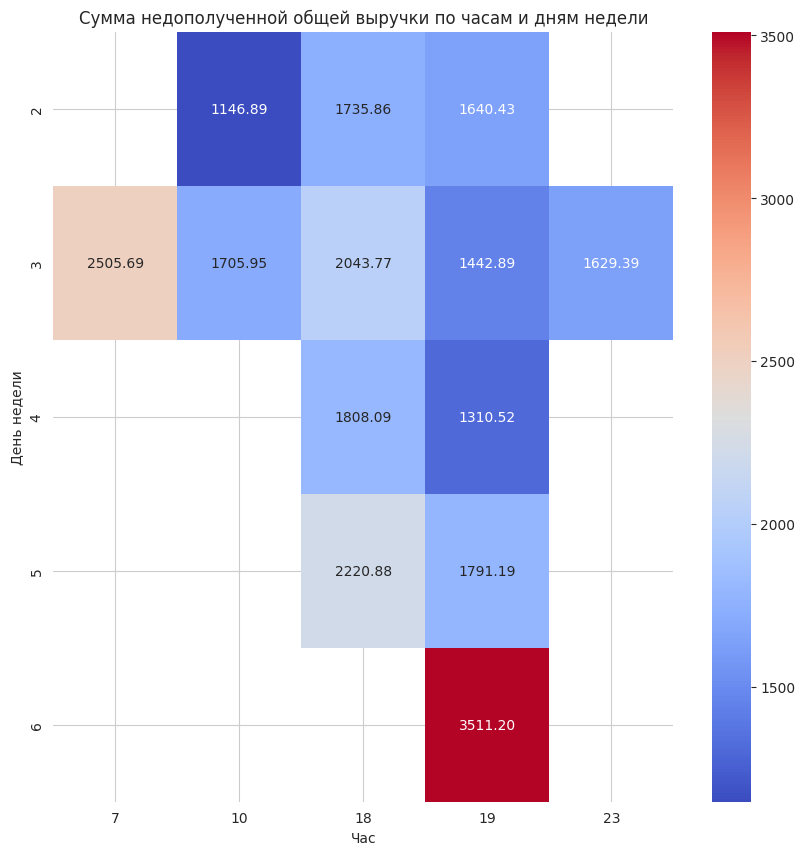

In [ ]:
pivot_table = df_opt_period.pivot_table(index='weekday', columns='hour', values='unreceived_total_revenue', aggfunc='median')
plt.figure(figsize=(10, 10))

sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Сумма недополученной общей выручки по часам и дням недели')
plt.xlabel('Час')
plt.ylabel('День недели')
plt.show()

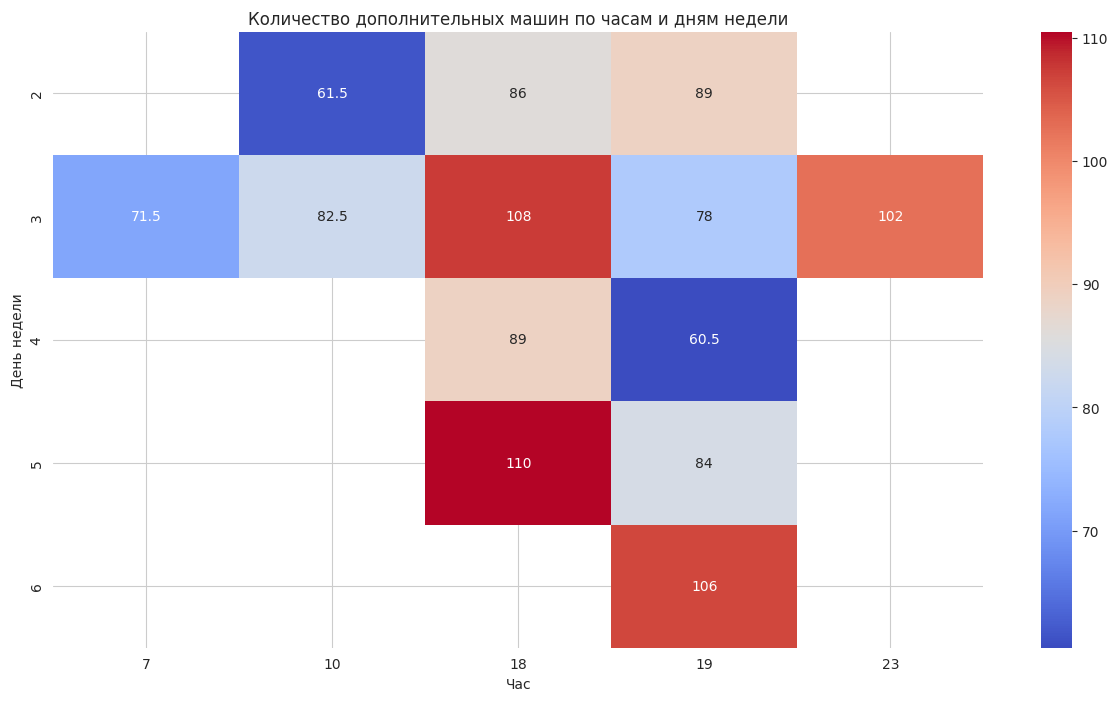

In [ ]:
pivot_table = df_opt_period.pivot_table(index='weekday', columns='hour', values='car_plus', aggfunc='median')

plt.figure(figsize=(15, 8))

sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt='.3g')
plt.title('Количество дополнительных машин по часам и дням недели')
plt.xlabel('Час')
plt.ylabel('День недели')
plt.show()

In [ ]:
pivot_table

hour                      7                    10                   18  \
weekday                                                                  
2                        NaN                61.50                86.00   
3                      71.50                82.50               107.50   
4                        NaN                  NaN                89.00   
5                        NaN                  NaN               110.50   
6                        NaN                  NaN                  NaN   

hour                      19                   23  
weekday                                            
2                      89.00                  NaN  
3                      78.00               102.50  
4                      60.50                  NaN  
5                      84.00                  NaN  
6                     106.50                  NaN

Больше всего недополученной выручки - в субботу в 7 вечера, это около 3,5 тысяч долларов за 2 месяца, а общая недополученная выручка - 160 тысяч долларов за 2 месяца.

Водители же не дополучили по 13 долларов в час.

Больше всего необходимо вывести машин в 6 часов вечера со среды по пятницу, в 11 вечера в среду и в 7 вечера в субботу.

## Презентация

https://drive.google.com/file/d/1V-29w52GYhGtFPr73kQWodRgZ9-skBhK/view?usp=share_link

## Общий вывод

Итак, мы рассчитали для каждого часа:

- Количество машин на линии
- Количество поездок
- Среднюю длительность поездки
- Среднюю длину поездки
- Среднюю тарифную стоимость поездки
- Показатели из расчёта на одного водителя, включая общую выручку и выручку водителя

Определили периоды когда водители получают

- выручку исходя из тарифа ниже среднего
- меньше чаевых

Определили критические периоды дефицита предложения, рассчитали оптимальное число машин на линии для обеспечения нормального показателя покрытия

Определили периоды, в которые меры стимулирования предложения услуг такси нужны и будут наиболее эффективны

Оценили:

- объём недополученной общей выручки из-за низкого предложения
- дефицит количества машин на линии

Подготовили презентацию на 7-10 слайдов с основными результатами проекта.

---



---



Видим следующие закономерности:
1. Меньше всего машин на линии в промежуток времени с 4 до 6 утра, больше всего - в 7-8 вечера, причем в марте машин больше. В период с 10 утра до 5 вечера количество машин приблизительно одинаковое. По дням недели наибольшее количество машин на линии - ближе к выходным.
2. Если смотреть количество машин в разбивке по часам и дням недели, то в выходные ночью машин больше, чем в будни. А вот вечером больше всего машин в четверг, пятницу и субботу. Во второй половине недели днем машин больше, чем в воскресенье, понедельник и вторник. Однако и этого количества, как оказалось, не хватает.
3. В 5 и 6 утра по будням (особенно в понедельник) резко увеличивается длительность и длина поездки, что скорее всего связно с поездками на работу с другого конца города. В субботу этот всплеск сдвигается примерно на час (возможно, люди едут за город), а в воскресенье его почти нет.
4. В феврале утренние поездки длиннее, возможно это связано с зимним периодом и погодой.
5. Самый высокий тариф утром с 5 до 7 утра так как спрос явно высок. В выходные в это время тариф ниже.
6. Самая высокая выручка (как общая, так и у водителей) - в понедельник утром. Ближе к выходным утренняя выручка падает. А вот дневная выручка в будни ниже, чем в выходные.
7. Водители получают выручку исходя из тарифа выше среднего только с 5 до 7 утра будни. В остальные периоды они получают получают выручку меньше среднего тарифа. Если же смотреть по средней выручке водителя, то провалы в выручке в основном в будни с 7 утра до 6 вечера, то есть весь день.
8. Большая часть водителей вообще не получают чаевые и медиана равна 0. Однако выявлена интересная закономерность - больше всего чаевых получают водители вечером в будни и не получают чаевые в выходные.

Мы посчитали нормальным покрытием медианное значение данных по покрытию (это 73%), так как она представляет центральную точку, отражающую более типичное значение процента покрытия. 100% покрытия добиться все равно очень сложно.

Основная нехватка машин у нас по средам, а также в будни днем часов с 9. Как раз в это время у нас водители получают меньше всего выручки. Но это данные по проценту покрытия, лучше смотреть по количеству машин.
Больше всего не хватает машин начиная со вторника по пятницу в период с 6 до 8 вечера, а также в среду в 7 и 10 утра и в 11 вечера и субботу в 7 вечера.

Больше всего недополученной выручки из-за нехватки машин на линии - в субботу в 7 вечера, это около 3,5 тысяч долларов за 2 месяца, а общая недополученная выручка - 160 тысяч долларов за 2 месяца. Водители же не дополучили по 13 долларов в час.

Больше всего необходимо вывести машин в 6 часов вечера со среды по пятницу, в 11 вечера в среду и в 7 вечера в субботу.

---



---



Думаю, необходимо стимулировать выходить водителей на линию в периоды, когда не хватает больше всего машин. Это возможно сделать путем повышения тарифа в это время. Однако увеличение количества машин на линии может спровоцировать увеличение пробок в городе, что повлечет за собой увеличение времени на поездки.